# **SWORDS dataset: Stanford Word Substitution Benchmark**

https://github.com/p-lambda/swords?tab=readme-ov-file#downloading-the-swords-benchmark

**TASK:**

Let's consider a substitute correct if at least two votes/labels are TRUE.

**Carefully load the dataset in proper key-value structures and calculate in how many contexts of the test set, a model gives at least one correct substitute among 5/10/50 first candidates** (all candidates in case of wordnet) which are selected after applying:

a) filtering (only letters a-zA-Z shall be inside the word, i.e. bool(re.search("^[\w\s_]+$", item))==True)

b) .strip() (needed at least for RoBERTa)

c) replace "_" with " " (needed at least for word2vec)

d) .lower()

Hint: generate more candidates so that you have the required amount after filtering.

Evaluate 4 models: 1) fasttext, 2) word2vec or glove, 3) wordnet, 4) BERT, RoBERTa or XLM-RoBERTa as applied in this notebook

Deliver a code and a short report with results of evaluations in a table 4x3 (4 models by 3 number of top substitutes 5/10/50). Provide interesting examples for each model (i.e., contexts and corresponding ranked model predictions with similarity scores. Predictions in examples may include both correct and incorrect substitutes - specify which of them are correct). Provide conclusions: make a brief comparative analysis of model performances based on results in the table.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# change the path to where your notebook is located
%cd "/content/gdrive/MyDrive/Curs 2023-2024/Introduction to Natural Language Processing"

/content/gdrive/MyDrive/Curs 2023-2024/Introduction to Natural Language Processing


In [3]:
! pip install pyfasttext

In [4]:
import json
import re
import spacy
from nltk.corpus import wordnet as wn
from gensim.models import KeyedVectors
from transformers import pipeline
from collections import defaultdict
from tqdm import tqdm
import nltk
import pandas as pd
from gensim.models.keyedvectors import KeyedVectors
from pyfasttext import FastText
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

nltk.download('wordnet')
nltk.download('omw-1.4')
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Common functions & Processing

In [5]:
def organize_substitutes_by_target(swords_data):
    tid_to_sids = defaultdict(list)
    for sid, substitute in swords_data['substitutes'].items():
        tid_to_sids[substitute['target_id']].append(sid)
    return tid_to_sids

def evaluate_predictions(predicted_substitutes, benchmark_substitutes, labels):
    # Initialize scores list
    prediction_scores = []
    valid_substitutes = []

    # Convert benchmark_substitutes and labels into a dictionary for easy lookup
    benchmark_dict = {sub: label for sub, label in zip(benchmark_substitutes, labels)}

    # Calculate scores based on presence in the normalized benchmark list and labels
    for predicted_sub in predicted_substitutes:
        if predicted_sub in benchmark_dict:
            true_count = benchmark_dict[predicted_sub].count('TRUE')
            score = true_count / len(benchmark_dict[predicted_sub])
            prediction_scores.append(score)
            valid_substitutes.append(true_count > 1)
        else:
            # Append 0 score if substitute is not in the benchmark
            prediction_scores.append(0)
            valid_substitutes.append(False)

    return prediction_scores, valid_substitutes



def evaluate_substitutes(swords, tid_to_sids, NLP_model, is_transformer, is_fasttext, top_k, verbose=False, debugging=False):
    results = {}  # Dictionary to store results
    count = 0
    # Get the total number of targets to track progress
    total_targets = len(swords['targets'])
    if not(verbose):
      progress_bar = tqdm(total=total_targets, desc='Evaluating Targets')  # Setup progress bar

    for tid, target in swords['targets'].items():
        context = swords['contexts'][target['context_id']]['context']
        substitutes = [swords['substitutes'][sid]['substitute'] for sid in tid_to_sids[tid]]
        labels = [swords['substitute_labels'][sid] for sid in tid_to_sids[tid]]

        # Generate predictions using one of the NLP methods
        if is_transformer:
            predicted_substitutes = get_predictions_transformer(NLP_model, context, target['target'], top_k=int(top_k*1.5))[:top_k]
            print(len(predicted_substitutes))
        elif NLP_model is None:
            predicted_substitutes = get_wordnet_synomyms(target['target'])
        elif is_fasttext:
            predicted_substitutes = get_similar_words_fasttext(NLP_model, target['target'], top_n=int(top_k*1.5))[:top_k]
        # elif is_fasttext:
        #     predicted_substitutes = get_similar_words_context_fasttext(NLP_model, context, target['target'], top_n=int(top_k*1.5))[:top_k]

        else:
            predicted_substitutes = get_similar_words_embeddings(NLP_model, target['target'], top_n=int(top_k*1.5))[:top_k]

        # Calculate prediction scores and validity of substitutes
        prediction_scores, valid_substitutes = evaluate_predictions(predicted_substitutes, substitutes, labels)
        if verbose:
          print('\n')
          print(f"Target: {target['target']}")
          print(f"Context: {context}")
          print(f"Substitutes of '{target['target']}':")
          print(', '.join(['{} ({}%)'.format(sub, round(score * 100))
                          for sub, score in sorted(zip(predicted_substitutes, prediction_scores), key=lambda x: -x[1])]))



        # Calculate averages and store results
        avg_score = sum(prediction_scores) / len(prediction_scores) if prediction_scores else 0
        num_valid = sum(valid_substitutes)
        percent_valid = (num_valid / len(valid_substitutes)) if valid_substitutes else 0
        results[tid] = {'target': target['target'], 'avg_score': avg_score, 'num_valid': num_valid, 'percent_valid': percent_valid}

        if not(verbose):
          progress_bar.update(1)  # Update progress bar

        count += 1  # Increment counter
        if count == 3 and debugging:
            print("Debugging break.")
            break  # Break after processing n items for debugging
    if not(verbose):
      progress_bar.close()  # Close the progress bar

    return pd.DataFrame(results).T  # Return the results dictionary


def normalize_word(word):
    word = word.replace('_', ' ').strip().lower()
    doc = nlp(word)
    return ' '.join(token.lemma_ for token in doc)

def valid_word(word):
    return re.search(r"^[\w\s]+$", word) is not None

def get_similar_words_embeddings(model, target_word, top_n=50):
    similar_words = model.most_similar(target_word, topn=top_n)
    return [normalize_word(word) for word, similarity in similar_words if valid_word(word)]

def get_similar_words_fasttext(model, target_word, top_n=50):
    similar_words = model.nearest_neighbors(target_word, k=top_n)
    return [normalize_word(word) for word, similarity in similar_words if valid_word(word)]

def get_enhanced_embedding(model, words, target_index, window_size=5):
    vectors = []
    start = max(0, target_index - window_size)
    end = min(len(words), target_index + window_size + 1)
    for i in range(start, end):
        vectors.append(model.get_word_vector(words[i]))
    return np.mean(vectors, axis=0)

def get_similar_words_context_fasttext(model, context, target_word, top_n=50):
    words = context.split()
    target_index = words.index(target_word)
    enhanced_embedding = get_enhanced_embedding(model, words, target_index)
    similar_words = model.similar_by_vector(enhanced_embedding, topn=top_n)
    return [normalize_word(word) for word, similarity in similar_words if valid_word(word)]

def get_wordnet_synomyms(target):
    substitutes = []
    for ss in wn.synsets(target):
        substitutes.extend(ss.lemma_names())
        for ss2 in ss.also_sees():
            substitutes.extend(ss2.lemma_names())
        for ss3 in ss.similar_tos():
            substitutes.extend(ss3.lemma_names())
    return list(set(substitutes))

def get_predictions_transformer(LM, context, target, top_k=50, mask_token='<mask>', extra_context=False):
    masked_context = context.replace(target, mask_token, 1)
    if extra_context:
      updated_context = context + "      " + masked_context
    else:
      updated_context = masked_context
    results = LM(updated_context, top_k=top_k)
    return [normalize_word(result['token_str']) for result in results if valid_word(result['token_str']) and result != target]

def print_stats(data, percent_plot = True):
  print(f"1. Valid candidates of all the dataset: {data['num_valid'].sum()} ({round(data['num_valid'].mean(),3)} valids/context)")
  print(f"2. Number of contexts with valid candidates: {len(data[data['num_valid']>0])} ({round(len(data[data['num_valid']>0])/len(data),3)*100}%)")
  print(f"3. Avg Score (% of TRUE of the candidate) of all tha dataset:  {round(data['avg_score'].mean(),3)*100}% ({round(data[data['avg_score']>0]['avg_score'].mean(),3)*100}% excluding 0 valids)")
  data.groupby('num_valid').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.show()
  if percent_plot:
    data.groupby('percent_valid').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
    plt.gca().spines[['top', 'right',]].set_visible(False)
    plt.show()



In [12]:
! gzip -d swords-v1.1_test.json.gz

gzip: swords-v1.1_test.json already exists; do you wish to overwrite (y or n)? y


In [6]:
file_path = 'swords-v1.1_test.json'

with open(file_path, 'r') as file:
    swords_data = json.load(file)


if not swords_data:
    print("The data is empty.")
else:
    print("Data loaded successfully.")

print(f"Data type: {type(swords_data)}")


if isinstance(swords_data, list):
    print(f"Number of items in the list: {len(swords_data)}")
elif isinstance(swords_data, dict):
    print(f"Number of keys in the dictionary: {len(swords_data.keys())}")
    print(f"Keys in dictionary: {swords_data.keys()}")
    for key in swords_data:
      if isinstance(swords_data[key], dict):
        length_dict = len(swords_data[key].keys())
        print(f"Number of keys in the {key}: {length_dict}")
        if length_dict < 100:
          print(f"Keys in dictionary: {swords_data[key].keys()}")
      else:
        print(f"{key}: {swords_data[key]}")

substitutes_by_target = organize_substitutes_by_target(swords_data)

Data loaded successfully.
Data type: <class 'dict'>
Number of keys in the dictionary: 5
Keys in dictionary: dict_keys(['contexts', 'targets', 'substitutes', 'substitutes_lemmatized', 'substitute_labels'])
Number of keys in the contexts: 762
Number of keys in the targets: 762
Number of keys in the substitutes: 45705
substitutes_lemmatized: True
Number of keys in the substitute_labels: 45705


## FastText

### Loading model

In [ ]:
! pip install pyfasttext

In [14]:
! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz

--2024-04-21 21:44:45--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.165.83.91, 18.165.83.35, 18.165.83.79, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.165.83.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G  37.2MB/s    in 1m 56s  

2024-04-21 21:46:41 (37.1 MB/s) - ‘cc.en.300.bin.gz’ saved [4503593528/4503593528]



In [15]:
! gzip -d cc.en.300.bin.gz

In [7]:
fasttext_model = FastText('cc.en.300.bin')

### Evaluation

In [ ]:
results_fasttext_5 = evaluate_substitutes(swords_data, substitutes_by_target, fasttext_model, is_transformer=False, is_fasttext=True,top_k=5, verbose=False, debugging=False)

Evaluating Targets: 100%|██████████| 762/762 [21:11<00:00,  1.67s/it]


In [ ]:
results_fasttext_10 = evaluate_substitutes(swords_data, substitutes_by_target, fasttext_model, is_transformer=False, is_fasttext=True,top_k=10, verbose=False, debugging=False)

Evaluating Targets: 100%|██████████| 762/762 [20:25<00:00,  1.61s/it]


In [ ]:
results_fasttext_50 = evaluate_substitutes(swords_data, substitutes_by_target, fasttext_model, is_transformer=False, is_fasttext=True,top_k=50, verbose=False, debugging=False)

Evaluating Targets: 100%|██████████| 762/762 [20:23<00:00,  1.61s/it]


### Results

1. Valid candidates of all the dataset: 434 (0.57 valids/context)
2. Number of contexts with valid candidates: 271 (35.6%)
3. Avg Score (% of TRUE of the candidate) of all tha dataset:  7.1% (19.6% excluding 0 valids)


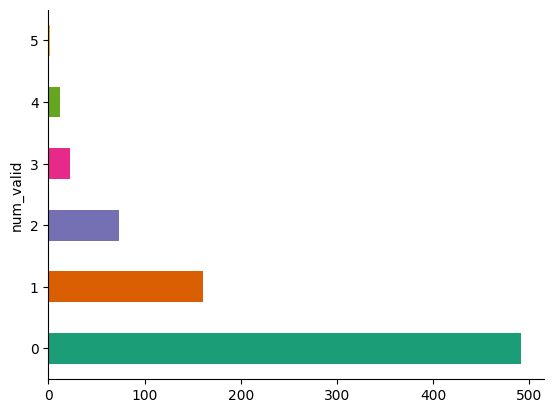

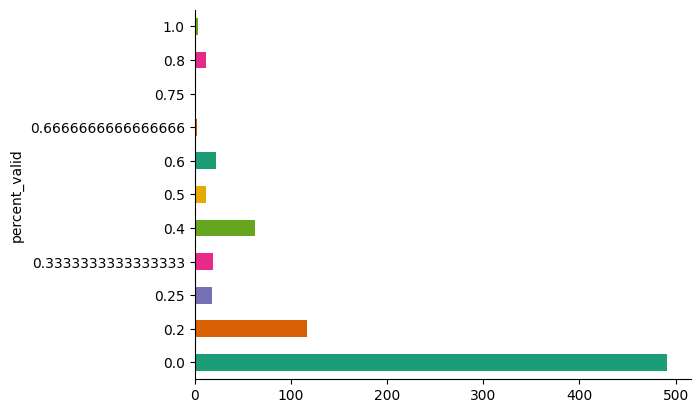

In [ ]:
print_stats(results_fasttext_5)

1. Valid candidates of all the dataset: 798 (1.047 valids/context)
2. Number of contexts with valid candidates: 395 (51.800000000000004%)
3. Avg Score (% of TRUE of the candidate) of all tha dataset:  6.800000000000001% (12.8% excluding 0 valids)


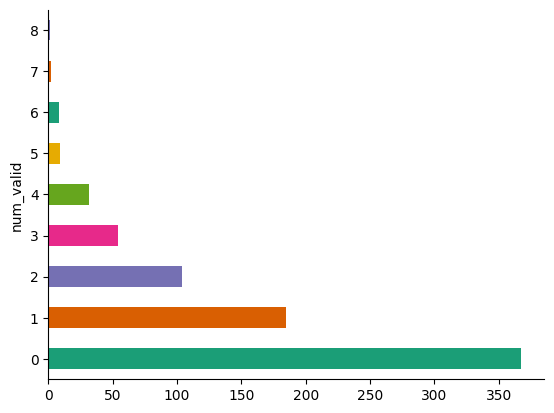

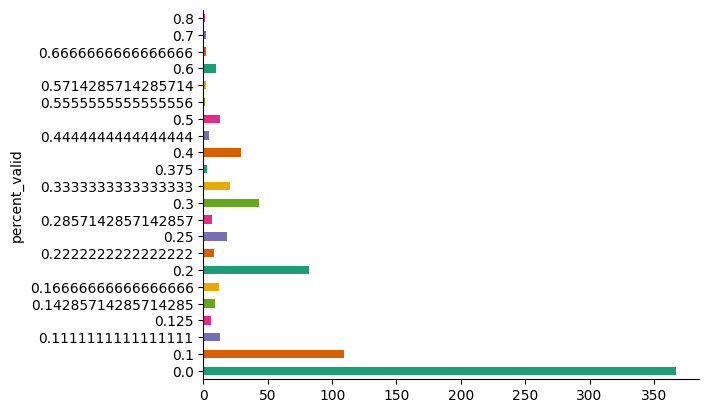

In [ ]:
print_stats(results_fasttext_10)

1. Valid candidates of all the dataset: 2800 (3.675 valids/context)
2. Number of contexts with valid candidates: 655 (86.0%)
3. Avg Score (% of TRUE of the candidate) of all tha dataset:  4.8% (5.5% excluding 0 valids)


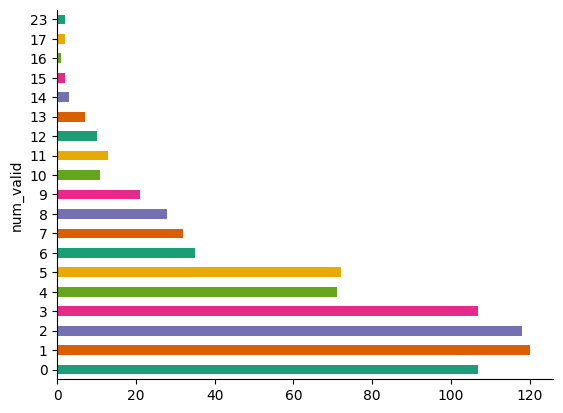

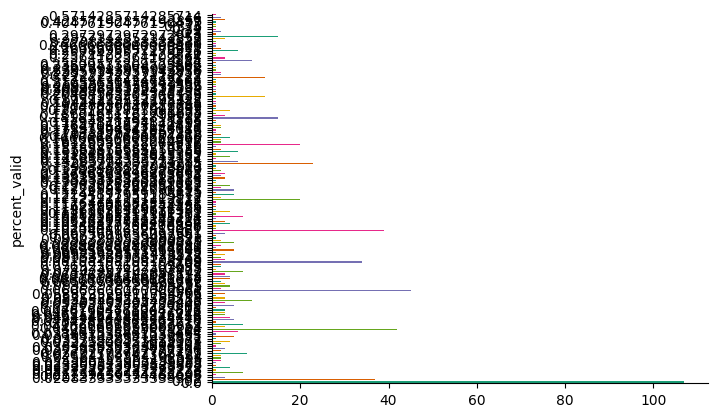

In [ ]:
print_stats(results_fasttext_50)

### Examples

In [ ]:
evaluate_substitutes(swords_data, substitutes_by_target, fasttext_model, is_transformer=False, is_fasttext=True,top_k=50, verbose=True, debugging=True)



Target: press
Context: "Noriega has closed every independent newspaper, radio and television station and arrested, tortured or forced into exile a long list of reporters," the statement declared.

It added: "In Cuba, public enemy No. 1 of press freedoms in the hemisphere, repression of journalists both Cuban and foreign is worse than ever."
And in Nicaragua, promises of press freedom by the Sandinistas "have not materialized."
Substitutes of 'press':
journalist (70%), newspaper (60%), reporter (40%), presss (0%), press (0%), press (0%), release (0%), press (0%), medium (0%), thepress (0%), pressthe (0%), presser (0%), press (0%), release (0%), conference (0%), agentry (0%), junket (0%), pressthe (0%), pressroom (0%), button (0%), presser (0%), prss (0%), briefing (0%), apress (0%), conferece (0%), pressman (0%), relase (0%), publicity (0%), pree (0%), news (0%), conferance (0%), spacebar (0%), releasethe (0%), newsmedia (0%), buttion (0%), presss (0%), presse (0%), pressroom (0%), bu

,target,avg_score,num_valid,percent_valid
t:288b94f02f153614ee0dc6474368f2e15ddff00c,press,0.040476,3,0.071429
t:903b731500e20dcfbdab21a501e8721e28f9b15f,house,0.073913,2,0.086957
t:9a3b5ea9b9e5a57e305f916e4d83109321bcbaab,page,0.0,0,0.0


## Word2Vec

### Loading model

In [ ]:
! gzip -d GoogleNews-vectors-negative300.bin.gz

In [ ]:
w2v_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

### Evaluation

In [ ]:
results_w2v_5 = evaluate_substitutes(swords_data, substitutes_by_target, w2v_model, is_transformer=False, is_fasttext=False,top_k=5, verbose=False, debugging=False)


Evaluating Targets: 100%|██████████| 762/762 [06:06<00:00,  2.08it/s]


In [ ]:
results_w2v_10 = evaluate_substitutes(swords_data, substitutes_by_target, w2v_model, is_transformer=False, is_fasttext=False,top_k=10, verbose=False, debugging=False)


Evaluating Targets: 100%|██████████| 762/762 [06:52<00:00,  1.85it/s]


In [ ]:
results_w2v_50 = evaluate_substitutes(swords_data, substitutes_by_target, w2v_model, is_transformer=False, is_fasttext=False,top_k=50, verbose=False, debugging=False)


Evaluating Targets: 100%|██████████| 762/762 [08:17<00:00,  1.53it/s]


### Results

1. Valid candidates of all the dataset: 621 (0.815 valids/context)
2. Number of contexts with valid candidates: 380 (49.9%)
3. Avg Score (% of TRUE of the candidate) of all tha dataset:  9.0% (17.8% excluding 0 valids)


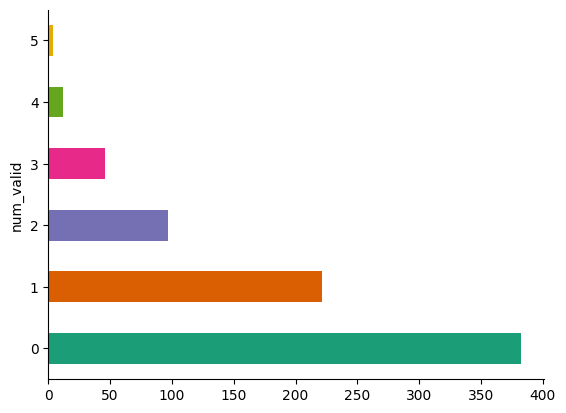

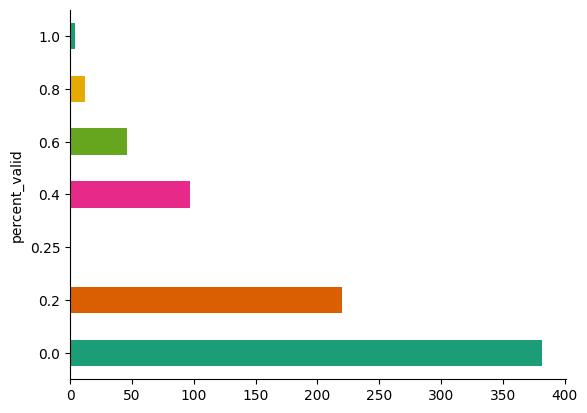

In [ ]:
print_stats(results_w2v_5)

1. Valid candidates of all the dataset: 1159 (1.521 valids/context)
2. Number of contexts with valid candidates: 508 (66.7%)
3. Avg Score (% of TRUE of the candidate) of all tha dataset:  8.1% (12.0% excluding 0 valids)


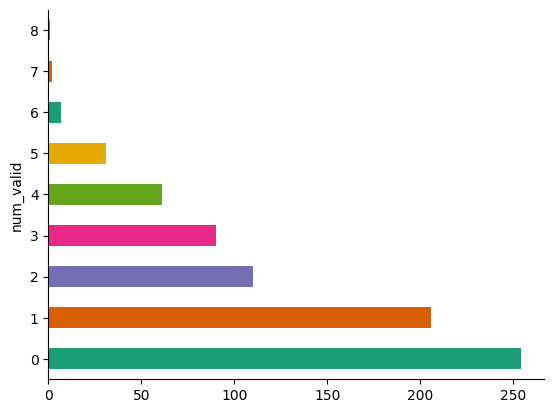

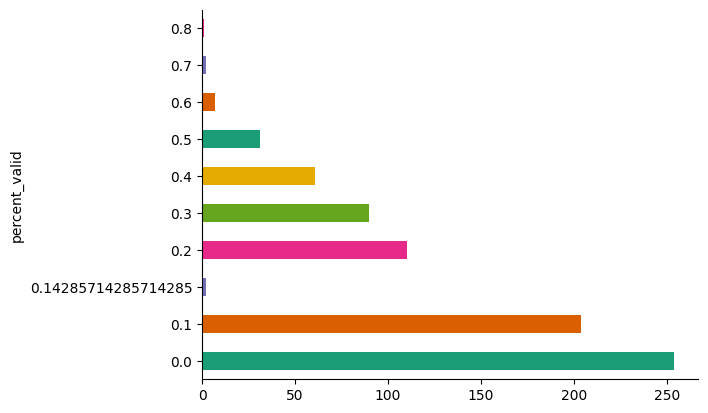

In [ ]:
print_stats(results_w2v_10)

1. Valid candidates of all the dataset: 3076 (4.037 valids/context)
2. Number of contexts with valid candidates: 641 (84.1%)
3. Avg Score (% of TRUE of the candidate) of all tha dataset:  4.1000000000000005% (4.8% excluding 0 valids)


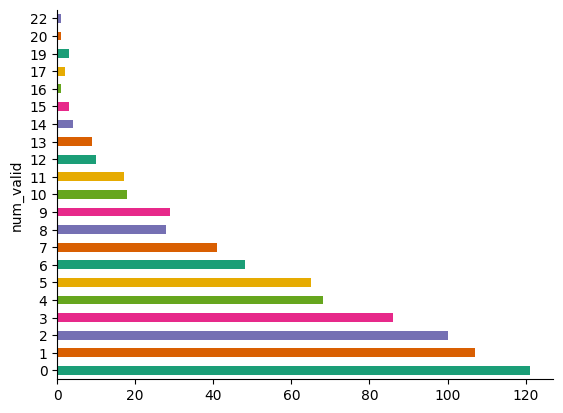

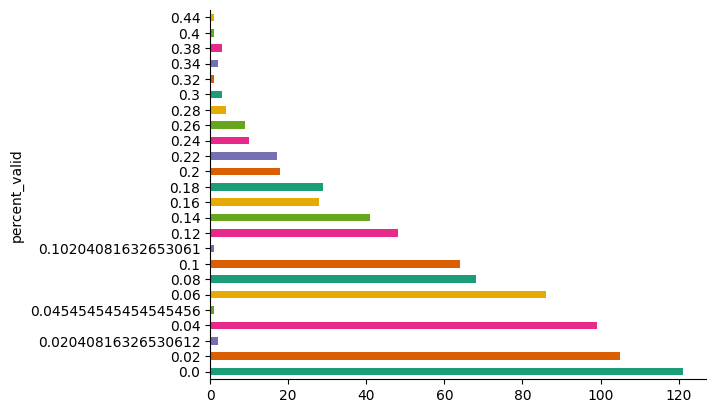

In [ ]:
print_stats(results_w2v_50)

### Examples

In [ ]:
evaluate_substitutes(swords_data, substitutes_by_target, w2v_model, is_transformer=False, is_fasttext=False,top_k=50, verbose=True, debugging=True)



Target: press
Context: "Noriega has closed every independent newspaper, radio and television station and arrested, tortured or forced into exile a long list of reporters," the statement declared.

It added: "In Cuba, public enemy No. 1 of press freedoms in the hemisphere, repression of journalists both Cuban and foreign is worse than ever."
And in Nicaragua, promises of press freedom by the Sandinistas "have not materialized."
Substitutes of 'press':
journalist (70%), reporter (40%), medium (0%), hastily convene press (0%), breife (0%), news (0%), briefing (0%), conference (0%), presser (0%), secretary natalia timakova (0%), grape fermentation (0%), secretary jacquelyn hear (0%), shams ul safa aminzai (0%), press (0%), secretary greg massoni (0%), secretary jane jankowski (0%), spokesman yasuhide yamashiro (0%), secretary margita thompson (0%), secretary joanna doven (0%), pressconference (0%), chief barnabe gome (0%), secretary denise bottcher (0%), secretary alexei gromov (0%), adv

,target,avg_score,num_valid,percent_valid
t:288b94f02f153614ee0dc6474368f2e15ddff00c,press,0.022,2,0.04
t:903b731500e20dcfbdab21a501e8721e28f9b15f,house,0.078,6,0.12
t:9a3b5ea9b9e5a57e305f916e4d83109321bcbaab,page,0.0,0,0.0


## WordNet

In [ ]:
results_wordnet = evaluate_substitutes(swords_data, substitutes_by_target, None, is_transformer=False, is_fasttext=False,top_k=-1, verbose=False, debugging=False)

Evaluating Targets: 100%|██████████| 762/762 [00:01<00:00, 755.62it/s]


1. Valid candidates of all the dataset: 1847 (2.424 valids/context)
2. Number of contexts with valid candidates: 608 (79.80000000000001%)
3. Avg Score (% of TRUE of the candidate) of all tha dataset:  8.1% (9.9% excluding 0 valids)


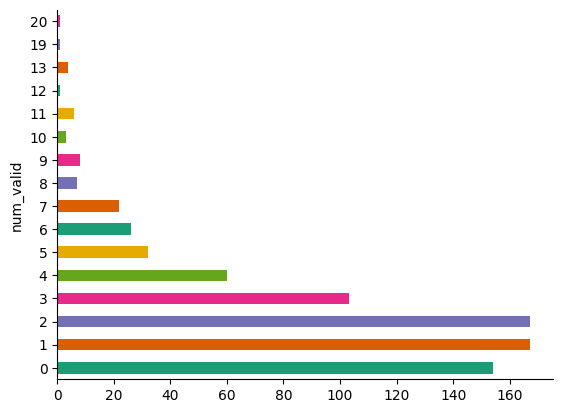

In [ ]:
print_stats(results_wordnet, percent_plot = False)

### Examples

In [ ]:
evaluate_substitutes(swords_data, substitutes_by_target, None, is_transformer=False, is_fasttext=False,top_k=-1, verbose=True, debugging=True)



Target: press
Context: "Noriega has closed every independent newspaper, radio and television station and arrested, tortured or forced into exile a long list of reporters," the statement declared.

It added: "In Cuba, public enemy No. 1 of press freedoms in the hemisphere, repression of journalists both Cuban and foreign is worse than ever."
And in Nicaragua, promises of press freedom by the Sandinistas "have not materialized."
Substitutes of 'press':
weigh (0%), squeeze (0%), compress (0%), exhort (0%), campaign (0%), agitate (0%), closet (0%), weight-lift (0%), pressing (0%), wardrobe (0%), urge_on (0%), iron_out (0%), imperativeness (0%), jam (0%), compact (0%), crusade (0%), printing_press (0%), iron (0%), public_press (0%), beseech (0%), military_press (0%), contract (0%), press (0%), insistence (0%), insistency (0%), push (0%), bid (0%), pressure (0%), entreat (0%), adjure (0%), fight (0%), urge (0%), mechanical_press (0%), constrict (0%), press_out (0%), weightlift (0%), conjur

,target,avg_score,num_valid,percent_valid
t:288b94f02f153614ee0dc6474368f2e15ddff00c,press,0.0,0,0.0
t:903b731500e20dcfbdab21a501e8721e28f9b15f,house,0.0625,1,0.0625
t:9a3b5ea9b9e5a57e305f916e4d83109321bcbaab,page,0.0,0,0.0


## XLM RoBERTa

### Loading model

In [ ]:
xlm_roberta = pipeline('fill-mask', model='xlm-roberta-large')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

### Evaluation

In [ ]:
results_xlm_roberta_5 = evaluate_substitutes(swords_data, substitutes_by_target, xlm_roberta, is_transformer=True, is_fasttext=False, top_k=5, verbose=False, debugging=False)

Evaluating Targets:   0%|          | 1/762 [00:03<49:29,  3.90s/it]

5


Evaluating Targets:   0%|          | 2/762 [00:04<27:32,  2.17s/it]

5


Evaluating Targets:   0%|          | 3/762 [00:05<21:05,  1.67s/it]

5


Evaluating Targets:   1%|          | 4/762 [00:08<24:51,  1.97s/it]

5


Evaluating Targets:   1%|          | 5/762 [00:10<23:35,  1.87s/it]

5


Evaluating Targets:   1%|          | 6/762 [00:11<20:23,  1.62s/it]

5


Evaluating Targets:   1%|          | 7/762 [00:11<16:49,  1.34s/it]

5


Evaluating Targets:   1%|          | 8/762 [00:13<15:48,  1.26s/it]

5


Evaluating Targets:   1%|          | 9/762 [00:13<14:05,  1.12s/it]

5


Evaluating Targets:   1%|▏         | 10/762 [00:16<18:13,  1.45s/it]

5


Evaluating Targets:   1%|▏         | 11/762 [00:18<21:03,  1.68s/it]

5


Evaluating Targets:   2%|▏         | 12/762 [00:20<21:23,  1.71s/it]

5


Evaluating Targets:   2%|▏         | 13/762 [00:22<25:30,  2.04s/it]

5


Evaluating Targets:   2%|▏         | 14/762 [00:23<21:53,  1.76s/it]

5


Evaluating Targets:   2%|▏         | 15/762 [00:25<20:22,  1.64s/it]

5


Evaluating Targets:   2%|▏         | 16/762 [00:26<18:01,  1.45s/it]

5


Evaluating Targets:   2%|▏         | 17/762 [00:27<18:25,  1.48s/it]

5


Evaluating Targets:   2%|▏         | 18/762 [00:28<15:56,  1.28s/it]

5


Evaluating Targets:   2%|▏         | 19/762 [00:30<18:03,  1.46s/it]

5


Evaluating Targets:   3%|▎         | 20/762 [00:32<19:32,  1.58s/it]

5


Evaluating Targets:   3%|▎         | 21/762 [00:39<40:38,  3.29s/it]

5


Evaluating Targets:   3%|▎         | 22/762 [00:43<42:07,  3.42s/it]

5


Evaluating Targets:   3%|▎         | 23/762 [00:47<43:38,  3.54s/it]

5


Evaluating Targets:   3%|▎         | 24/762 [00:48<34:39,  2.82s/it]

5


Evaluating Targets:   3%|▎         | 25/762 [00:49<29:22,  2.39s/it]

3


Evaluating Targets:   3%|▎         | 26/762 [00:51<26:27,  2.16s/it]

5


Evaluating Targets:   4%|▎         | 27/762 [00:53<25:19,  2.07s/it]

5


Evaluating Targets:   4%|▎         | 28/762 [00:54<22:33,  1.84s/it]

5


Evaluating Targets:   4%|▍         | 29/762 [00:55<18:28,  1.51s/it]

5


Evaluating Targets:   4%|▍         | 30/762 [00:56<15:58,  1.31s/it]

5


Evaluating Targets:   4%|▍         | 31/762 [00:57<14:46,  1.21s/it]

5


Evaluating Targets:   4%|▍         | 32/762 [00:57<13:19,  1.10s/it]

5


Evaluating Targets:   4%|▍         | 33/762 [00:58<12:03,  1.01it/s]

5


Evaluating Targets:   4%|▍         | 34/762 [00:59<10:50,  1.12it/s]

5


Evaluating Targets:   5%|▍         | 35/762 [01:00<10:15,  1.18it/s]

5


Evaluating Targets:   5%|▍         | 36/762 [01:01<10:45,  1.13it/s]

5


Evaluating Targets:   5%|▍         | 37/762 [01:03<14:44,  1.22s/it]

5


Evaluating Targets:   5%|▍         | 38/762 [01:06<21:11,  1.76s/it]

5


Evaluating Targets:   5%|▌         | 39/762 [01:06<18:08,  1.50s/it]

5


Evaluating Targets:   5%|▌         | 40/762 [01:08<19:32,  1.62s/it]

5


Evaluating Targets:   5%|▌         | 41/762 [01:09<17:09,  1.43s/it]

5


Evaluating Targets:   6%|▌         | 42/762 [01:11<18:38,  1.55s/it]

5


Evaluating Targets:   6%|▌         | 43/762 [01:12<15:28,  1.29s/it]

5


Evaluating Targets:   6%|▌         | 44/762 [01:13<14:21,  1.20s/it]

5


Evaluating Targets:   6%|▌         | 45/762 [01:14<12:40,  1.06s/it]

5


Evaluating Targets:   6%|▌         | 46/762 [01:14<11:20,  1.05it/s]

5


Evaluating Targets:   6%|▌         | 47/762 [01:16<13:37,  1.14s/it]

5


Evaluating Targets:   6%|▋         | 48/762 [01:17<12:37,  1.06s/it]

5


Evaluating Targets:   6%|▋         | 49/762 [01:20<21:13,  1.79s/it]

5


Evaluating Targets:   7%|▋         | 50/762 [01:22<19:43,  1.66s/it]

5


Evaluating Targets:   7%|▋         | 51/762 [01:23<17:41,  1.49s/it]

5


Evaluating Targets:   7%|▋         | 52/762 [01:25<21:44,  1.84s/it]

5


Evaluating Targets:   7%|▋         | 53/762 [01:26<17:30,  1.48s/it]

5


Evaluating Targets:   7%|▋         | 54/762 [01:27<14:30,  1.23s/it]

5


Evaluating Targets:   7%|▋         | 55/762 [01:28<13:34,  1.15s/it]

5


Evaluating Targets:   7%|▋         | 56/762 [01:28<12:25,  1.06s/it]

5


Evaluating Targets:   7%|▋         | 57/762 [01:29<11:40,  1.01it/s]

5


Evaluating Targets:   8%|▊         | 58/762 [01:30<11:10,  1.05it/s]

5


Evaluating Targets:   8%|▊         | 59/762 [01:31<10:51,  1.08it/s]

5


Evaluating Targets:   8%|▊         | 60/762 [01:34<17:06,  1.46s/it]

5


Evaluating Targets:   8%|▊         | 61/762 [01:36<20:12,  1.73s/it]

5


Evaluating Targets:   8%|▊         | 62/762 [01:37<18:13,  1.56s/it]

5


Evaluating Targets:   8%|▊         | 63/762 [01:38<15:48,  1.36s/it]

5


Evaluating Targets:   8%|▊         | 64/762 [01:39<13:40,  1.18s/it]

5


Evaluating Targets:   9%|▊         | 65/762 [01:40<12:21,  1.06s/it]

5


Evaluating Targets:   9%|▊         | 66/762 [01:41<14:48,  1.28s/it]

5


Evaluating Targets:   9%|▉         | 67/762 [01:44<17:27,  1.51s/it]

5


Evaluating Targets:   9%|▉         | 68/762 [01:44<15:06,  1.31s/it]

5


Evaluating Targets:   9%|▉         | 69/762 [01:46<16:25,  1.42s/it]

5


Evaluating Targets:   9%|▉         | 70/762 [01:49<21:37,  1.88s/it]

5


Evaluating Targets:   9%|▉         | 71/762 [01:50<19:28,  1.69s/it]

5


Evaluating Targets:   9%|▉         | 72/762 [01:53<21:39,  1.88s/it]

5


Evaluating Targets:  10%|▉         | 73/762 [01:53<17:41,  1.54s/it]

5


Evaluating Targets:  10%|▉         | 74/762 [01:54<15:15,  1.33s/it]

5


Evaluating Targets:  10%|▉         | 75/762 [01:57<20:20,  1.78s/it]

5


Evaluating Targets:  10%|▉         | 76/762 [01:58<17:06,  1.50s/it]

5


Evaluating Targets:  10%|█         | 77/762 [02:01<21:15,  1.86s/it]

5


Evaluating Targets:  10%|█         | 78/762 [02:04<26:49,  2.35s/it]

5


Evaluating Targets:  10%|█         | 79/762 [02:07<29:36,  2.60s/it]

5


Evaluating Targets:  10%|█         | 80/762 [02:10<29:24,  2.59s/it]

5


Evaluating Targets:  11%|█         | 81/762 [02:12<28:21,  2.50s/it]

5


Evaluating Targets:  11%|█         | 82/762 [02:15<28:42,  2.53s/it]

5


Evaluating Targets:  11%|█         | 83/762 [02:17<29:18,  2.59s/it]

5


Evaluating Targets:  11%|█         | 84/762 [02:18<23:32,  2.08s/it]

5


Evaluating Targets:  11%|█         | 85/762 [02:21<24:50,  2.20s/it]

5


Evaluating Targets:  11%|█▏        | 86/762 [02:22<20:18,  1.80s/it]

5


Evaluating Targets:  11%|█▏        | 87/762 [02:23<18:33,  1.65s/it]

5


Evaluating Targets:  12%|█▏        | 88/762 [02:24<16:50,  1.50s/it]

5


Evaluating Targets:  12%|█▏        | 89/762 [02:25<15:04,  1.34s/it]

5


Evaluating Targets:  12%|█▏        | 90/762 [02:26<13:43,  1.22s/it]

5


Evaluating Targets:  12%|█▏        | 91/762 [02:29<18:52,  1.69s/it]

5


Evaluating Targets:  12%|█▏        | 92/762 [02:30<16:28,  1.48s/it]

5


Evaluating Targets:  12%|█▏        | 93/762 [02:31<14:08,  1.27s/it]

5


Evaluating Targets:  12%|█▏        | 94/762 [02:33<17:15,  1.55s/it]

5


Evaluating Targets:  12%|█▏        | 95/762 [02:35<19:15,  1.73s/it]

5


Evaluating Targets:  13%|█▎        | 96/762 [02:37<21:31,  1.94s/it]

5


Evaluating Targets:  13%|█▎        | 97/762 [02:38<17:49,  1.61s/it]

5


Evaluating Targets:  13%|█▎        | 98/762 [02:39<14:36,  1.32s/it]

5


Evaluating Targets:  13%|█▎        | 99/762 [02:42<20:55,  1.89s/it]

5


Evaluating Targets:  13%|█▎        | 100/762 [02:45<25:11,  2.28s/it]

5


Evaluating Targets:  13%|█▎        | 101/762 [02:48<26:40,  2.42s/it]

5


Evaluating Targets:  13%|█▎        | 102/762 [02:49<20:43,  1.88s/it]

5


Evaluating Targets:  14%|█▎        | 103/762 [02:51<23:45,  2.16s/it]

5


Evaluating Targets:  14%|█▎        | 104/762 [02:52<19:27,  1.77s/it]

5


Evaluating Targets:  14%|█▍        | 105/762 [02:54<20:11,  1.84s/it]

5


Evaluating Targets:  14%|█▍        | 106/762 [02:58<24:44,  2.26s/it]

5


Evaluating Targets:  14%|█▍        | 107/762 [02:59<21:46,  1.99s/it]

5


Evaluating Targets:  14%|█▍        | 108/762 [03:00<18:02,  1.65s/it]

5


Evaluating Targets:  14%|█▍        | 109/762 [03:01<15:24,  1.42s/it]

5


Evaluating Targets:  14%|█▍        | 110/762 [03:02<15:00,  1.38s/it]

5


Evaluating Targets:  15%|█▍        | 111/762 [03:04<18:13,  1.68s/it]

5


Evaluating Targets:  15%|█▍        | 112/762 [03:05<15:56,  1.47s/it]

5


Evaluating Targets:  15%|█▍        | 113/762 [03:06<14:31,  1.34s/it]

5


Evaluating Targets:  15%|█▍        | 114/762 [03:08<17:00,  1.57s/it]

5


Evaluating Targets:  15%|█▌        | 115/762 [03:09<14:54,  1.38s/it]

5


Evaluating Targets:  15%|█▌        | 116/762 [03:11<15:22,  1.43s/it]

5


Evaluating Targets:  15%|█▌        | 117/762 [03:12<15:21,  1.43s/it]

5


Evaluating Targets:  15%|█▌        | 118/762 [03:14<17:09,  1.60s/it]

5


Evaluating Targets:  16%|█▌        | 119/762 [03:16<18:17,  1.71s/it]

5


Evaluating Targets:  16%|█▌        | 120/762 [03:17<16:36,  1.55s/it]

5


Evaluating Targets:  16%|█▌        | 121/762 [03:18<14:30,  1.36s/it]

5


Evaluating Targets:  16%|█▌        | 122/762 [03:19<12:47,  1.20s/it]

5


Evaluating Targets:  16%|█▌        | 123/762 [03:20<11:57,  1.12s/it]

5


Evaluating Targets:  16%|█▋        | 124/762 [03:22<14:56,  1.41s/it]

5


Evaluating Targets:  16%|█▋        | 125/762 [03:25<19:31,  1.84s/it]

5


Evaluating Targets:  17%|█▋        | 126/762 [03:27<18:08,  1.71s/it]

5


Evaluating Targets:  17%|█▋        | 127/762 [03:29<20:36,  1.95s/it]

5


Evaluating Targets:  17%|█▋        | 128/762 [03:30<16:46,  1.59s/it]

5


Evaluating Targets:  17%|█▋        | 129/762 [03:31<15:04,  1.43s/it]

5


Evaluating Targets:  17%|█▋        | 130/762 [03:33<17:10,  1.63s/it]

5


Evaluating Targets:  17%|█▋        | 131/762 [03:34<15:01,  1.43s/it]

5


Evaluating Targets:  17%|█▋        | 132/762 [03:35<13:15,  1.26s/it]

5


Evaluating Targets:  17%|█▋        | 133/762 [03:38<19:23,  1.85s/it]

5


Evaluating Targets:  18%|█▊        | 134/762 [03:41<22:03,  2.11s/it]

5


Evaluating Targets:  18%|█▊        | 135/762 [03:43<23:52,  2.28s/it]

5


Evaluating Targets:  18%|█▊        | 136/762 [03:46<23:29,  2.25s/it]

5


Evaluating Targets:  18%|█▊        | 137/762 [03:48<25:04,  2.41s/it]

5


Evaluating Targets:  18%|█▊        | 138/762 [03:51<27:23,  2.63s/it]

5


Evaluating Targets:  18%|█▊        | 139/762 [03:53<25:11,  2.43s/it]

5


Evaluating Targets:  18%|█▊        | 140/762 [03:55<21:30,  2.07s/it]

5


Evaluating Targets:  19%|█▊        | 141/762 [03:57<21:26,  2.07s/it]

5


Evaluating Targets:  19%|█▊        | 142/762 [03:59<22:42,  2.20s/it]

5


Evaluating Targets:  19%|█▉        | 143/762 [04:00<19:38,  1.90s/it]

5


Evaluating Targets:  19%|█▉        | 144/762 [04:01<16:25,  1.60s/it]

5


Evaluating Targets:  19%|█▉        | 145/762 [04:02<14:27,  1.41s/it]

5


Evaluating Targets:  19%|█▉        | 146/762 [04:05<17:26,  1.70s/it]

5


Evaluating Targets:  19%|█▉        | 147/762 [04:08<21:05,  2.06s/it]

5


Evaluating Targets:  19%|█▉        | 148/762 [04:08<17:13,  1.68s/it]

5


Evaluating Targets:  20%|█▉        | 149/762 [04:09<15:03,  1.47s/it]

5


Evaluating Targets:  20%|█▉        | 150/762 [04:10<13:32,  1.33s/it]

5


Evaluating Targets:  20%|█▉        | 151/762 [04:12<15:01,  1.47s/it]

5


Evaluating Targets:  20%|█▉        | 152/762 [04:15<18:40,  1.84s/it]

5


Evaluating Targets:  20%|██        | 153/762 [04:16<15:08,  1.49s/it]

4


Evaluating Targets:  20%|██        | 154/762 [04:16<12:42,  1.25s/it]

5


Evaluating Targets:  20%|██        | 155/762 [04:20<19:51,  1.96s/it]

5


Evaluating Targets:  20%|██        | 156/762 [04:21<18:30,  1.83s/it]

5


Evaluating Targets:  21%|██        | 157/762 [04:24<19:56,  1.98s/it]

5


Evaluating Targets:  21%|██        | 158/762 [04:25<19:21,  1.92s/it]

5


Evaluating Targets:  21%|██        | 159/762 [04:29<23:07,  2.30s/it]

5


Evaluating Targets:  21%|██        | 160/762 [04:30<19:22,  1.93s/it]

5


Evaluating Targets:  21%|██        | 161/762 [04:32<20:15,  2.02s/it]

5


Evaluating Targets:  21%|██▏       | 162/762 [04:35<22:19,  2.23s/it]

5


Evaluating Targets:  21%|██▏       | 163/762 [04:37<21:53,  2.19s/it]

5


Evaluating Targets:  22%|██▏       | 164/762 [04:38<18:16,  1.83s/it]

5


Evaluating Targets:  22%|██▏       | 165/762 [04:40<19:37,  1.97s/it]

5


Evaluating Targets:  22%|██▏       | 166/762 [04:41<17:43,  1.78s/it]

5


Evaluating Targets:  22%|██▏       | 167/762 [04:44<19:34,  1.97s/it]

5


Evaluating Targets:  22%|██▏       | 168/762 [04:45<16:55,  1.71s/it]

5


Evaluating Targets:  22%|██▏       | 169/762 [04:47<17:08,  1.73s/it]

5


Evaluating Targets:  22%|██▏       | 170/762 [04:49<17:52,  1.81s/it]

5


Evaluating Targets:  22%|██▏       | 171/762 [04:51<17:52,  1.82s/it]

5


Evaluating Targets:  23%|██▎       | 172/762 [04:51<15:16,  1.55s/it]

5


Evaluating Targets:  23%|██▎       | 173/762 [04:53<14:35,  1.49s/it]

5


Evaluating Targets:  23%|██▎       | 174/762 [04:54<14:02,  1.43s/it]

5


Evaluating Targets:  23%|██▎       | 175/762 [04:55<13:42,  1.40s/it]

5


Evaluating Targets:  23%|██▎       | 176/762 [04:58<17:11,  1.76s/it]

5


Evaluating Targets:  23%|██▎       | 177/762 [05:00<16:41,  1.71s/it]

5


Evaluating Targets:  23%|██▎       | 178/762 [05:02<17:28,  1.80s/it]

5


Evaluating Targets:  23%|██▎       | 179/762 [05:03<15:55,  1.64s/it]

5


Evaluating Targets:  24%|██▎       | 180/762 [05:04<13:38,  1.41s/it]

5


Evaluating Targets:  24%|██▍       | 181/762 [05:06<15:14,  1.57s/it]

5


Evaluating Targets:  24%|██▍       | 182/762 [05:08<17:52,  1.85s/it]

5


Evaluating Targets:  24%|██▍       | 183/762 [05:11<19:39,  2.04s/it]

5


Evaluating Targets:  24%|██▍       | 184/762 [05:12<17:25,  1.81s/it]

5


Evaluating Targets:  24%|██▍       | 185/762 [05:13<15:44,  1.64s/it]

5


Evaluating Targets:  24%|██▍       | 186/762 [05:17<21:40,  2.26s/it]

5


Evaluating Targets:  25%|██▍       | 187/762 [05:19<21:52,  2.28s/it]

5


Evaluating Targets:  25%|██▍       | 188/762 [05:21<20:44,  2.17s/it]

5


Evaluating Targets:  25%|██▍       | 189/762 [05:23<19:53,  2.08s/it]

5


Evaluating Targets:  25%|██▍       | 190/762 [05:26<21:15,  2.23s/it]

5


Evaluating Targets:  25%|██▌       | 191/762 [05:26<16:59,  1.79s/it]

5


Evaluating Targets:  25%|██▌       | 192/762 [05:29<20:08,  2.12s/it]

5


Evaluating Targets:  25%|██▌       | 193/762 [05:31<18:16,  1.93s/it]

5


Evaluating Targets:  25%|██▌       | 194/762 [05:31<14:46,  1.56s/it]

5


Evaluating Targets:  26%|██▌       | 195/762 [05:33<13:48,  1.46s/it]

5


Evaluating Targets:  26%|██▌       | 196/762 [05:34<12:02,  1.28s/it]

5


Evaluating Targets:  26%|██▌       | 197/762 [05:36<15:52,  1.69s/it]

5


Evaluating Targets:  26%|██▌       | 198/762 [05:39<17:38,  1.88s/it]

5


Evaluating Targets:  26%|██▌       | 199/762 [05:42<21:36,  2.30s/it]

5


Evaluating Targets:  26%|██▌       | 200/762 [05:44<22:16,  2.38s/it]

5


Evaluating Targets:  26%|██▋       | 201/762 [05:45<18:22,  1.97s/it]

5


Evaluating Targets:  27%|██▋       | 202/762 [05:46<15:46,  1.69s/it]

5


Evaluating Targets:  27%|██▋       | 203/762 [05:49<17:18,  1.86s/it]

5


Evaluating Targets:  27%|██▋       | 204/762 [05:51<18:18,  1.97s/it]

5


Evaluating Targets:  27%|██▋       | 205/762 [05:53<19:45,  2.13s/it]

5


Evaluating Targets:  27%|██▋       | 206/762 [05:55<17:02,  1.84s/it]

5


Evaluating Targets:  27%|██▋       | 207/762 [05:58<21:21,  2.31s/it]

5


Evaluating Targets:  27%|██▋       | 208/762 [06:01<23:30,  2.55s/it]

5


Evaluating Targets:  27%|██▋       | 209/762 [06:04<24:34,  2.67s/it]

5


Evaluating Targets:  28%|██▊       | 210/762 [06:05<19:25,  2.11s/it]

5


Evaluating Targets:  28%|██▊       | 211/762 [06:06<16:33,  1.80s/it]

0


Evaluating Targets:  28%|██▊       | 212/762 [06:07<14:54,  1.63s/it]

5


Evaluating Targets:  28%|██▊       | 213/762 [06:11<20:25,  2.23s/it]

5


Evaluating Targets:  28%|██▊       | 214/762 [06:14<22:06,  2.42s/it]

5


Evaluating Targets:  28%|██▊       | 215/762 [06:15<18:08,  1.99s/it]

5


Evaluating Targets:  28%|██▊       | 216/762 [06:16<15:47,  1.73s/it]

5


Evaluating Targets:  28%|██▊       | 217/762 [06:17<15:46,  1.74s/it]

5


Evaluating Targets:  29%|██▊       | 218/762 [06:18<13:43,  1.51s/it]

5


Evaluating Targets:  29%|██▊       | 219/762 [06:21<16:09,  1.78s/it]

5


Evaluating Targets:  29%|██▉       | 220/762 [06:25<21:12,  2.35s/it]

5


Evaluating Targets:  29%|██▉       | 221/762 [06:32<33:47,  3.75s/it]

5


Evaluating Targets:  29%|██▉       | 222/762 [06:34<29:00,  3.22s/it]

5


Evaluating Targets:  29%|██▉       | 223/762 [06:36<26:12,  2.92s/it]

5


Evaluating Targets:  29%|██▉       | 224/762 [06:37<20:18,  2.27s/it]

5


Evaluating Targets:  30%|██▉       | 225/762 [06:39<19:51,  2.22s/it]

5


Evaluating Targets:  30%|██▉       | 226/762 [06:40<18:42,  2.09s/it]

5


Evaluating Targets:  30%|██▉       | 227/762 [06:42<16:44,  1.88s/it]

5


Evaluating Targets:  30%|██▉       | 228/762 [06:44<18:05,  2.03s/it]

5


Evaluating Targets:  30%|███       | 229/762 [06:46<18:33,  2.09s/it]

5


Evaluating Targets:  30%|███       | 230/762 [06:48<16:25,  1.85s/it]

5


Evaluating Targets:  30%|███       | 231/762 [06:50<18:04,  2.04s/it]

5


Evaluating Targets:  30%|███       | 232/762 [06:51<15:59,  1.81s/it]

5


Evaluating Targets:  31%|███       | 233/762 [06:53<14:05,  1.60s/it]

5


Evaluating Targets:  31%|███       | 234/762 [06:55<15:32,  1.77s/it]

5


Evaluating Targets:  31%|███       | 235/762 [06:56<14:07,  1.61s/it]

5


Evaluating Targets:  31%|███       | 236/762 [07:00<19:19,  2.20s/it]

5


Evaluating Targets:  31%|███       | 237/762 [07:00<15:43,  1.80s/it]

5


Evaluating Targets:  31%|███       | 238/762 [07:02<15:34,  1.78s/it]

5


Evaluating Targets:  31%|███▏      | 239/762 [07:04<15:34,  1.79s/it]

5


Evaluating Targets:  31%|███▏      | 240/762 [07:06<16:57,  1.95s/it]

5


Evaluating Targets:  32%|███▏      | 241/762 [07:07<14:54,  1.72s/it]

5


Evaluating Targets:  32%|███▏      | 242/762 [07:10<17:43,  2.05s/it]

5


Evaluating Targets:  32%|███▏      | 243/762 [07:12<17:06,  1.98s/it]

5


Evaluating Targets:  32%|███▏      | 244/762 [07:13<14:19,  1.66s/it]

5


Evaluating Targets:  32%|███▏      | 245/762 [07:16<17:49,  2.07s/it]

5


Evaluating Targets:  32%|███▏      | 246/762 [07:17<15:40,  1.82s/it]

5


Evaluating Targets:  32%|███▏      | 247/762 [07:18<13:24,  1.56s/it]

5


Evaluating Targets:  33%|███▎      | 248/762 [07:21<16:53,  1.97s/it]

5


Evaluating Targets:  33%|███▎      | 249/762 [07:23<17:17,  2.02s/it]

5


Evaluating Targets:  33%|███▎      | 250/762 [07:27<21:02,  2.47s/it]

5


Evaluating Targets:  33%|███▎      | 251/762 [07:28<17:33,  2.06s/it]

5


Evaluating Targets:  33%|███▎      | 252/762 [07:30<17:22,  2.04s/it]

5


Evaluating Targets:  33%|███▎      | 253/762 [07:31<14:07,  1.67s/it]

5


Evaluating Targets:  33%|███▎      | 254/762 [07:32<13:09,  1.55s/it]

4


Evaluating Targets:  33%|███▎      | 255/762 [07:33<11:37,  1.38s/it]

5


Evaluating Targets:  34%|███▎      | 256/762 [07:34<10:53,  1.29s/it]

5


Evaluating Targets:  34%|███▎      | 257/762 [07:37<14:27,  1.72s/it]

5


Evaluating Targets:  34%|███▍      | 258/762 [07:38<13:32,  1.61s/it]

5


Evaluating Targets:  34%|███▍      | 259/762 [07:41<15:31,  1.85s/it]

5


Evaluating Targets:  34%|███▍      | 260/762 [07:42<15:28,  1.85s/it]

5


Evaluating Targets:  34%|███▍      | 261/762 [07:43<13:28,  1.61s/it]

5


Evaluating Targets:  34%|███▍      | 262/762 [07:45<14:16,  1.71s/it]

5


Evaluating Targets:  35%|███▍      | 263/762 [07:47<14:33,  1.75s/it]

5


Evaluating Targets:  35%|███▍      | 264/762 [07:48<13:13,  1.59s/it]

5


Evaluating Targets:  35%|███▍      | 265/762 [07:49<11:38,  1.41s/it]

5


Evaluating Targets:  35%|███▍      | 266/762 [07:54<18:34,  2.25s/it]

5


Evaluating Targets:  35%|███▌      | 267/762 [07:55<16:49,  2.04s/it]

5


Evaluating Targets:  35%|███▌      | 268/762 [07:56<14:09,  1.72s/it]

5


Evaluating Targets:  35%|███▌      | 269/762 [07:59<16:24,  2.00s/it]

5


Evaluating Targets:  35%|███▌      | 270/762 [08:00<14:14,  1.74s/it]

5


Evaluating Targets:  36%|███▌      | 271/762 [08:02<14:39,  1.79s/it]

5


Evaluating Targets:  36%|███▌      | 272/762 [08:04<15:46,  1.93s/it]

5


Evaluating Targets:  36%|███▌      | 273/762 [08:08<21:20,  2.62s/it]

5


Evaluating Targets:  36%|███▌      | 274/762 [08:09<16:57,  2.08s/it]

5


Evaluating Targets:  36%|███▌      | 275/762 [08:10<13:54,  1.71s/it]

5


Evaluating Targets:  36%|███▌      | 276/762 [08:12<14:00,  1.73s/it]

5


Evaluating Targets:  36%|███▋      | 277/762 [08:14<15:00,  1.86s/it]

5


Evaluating Targets:  36%|███▋      | 278/762 [08:15<13:33,  1.68s/it]

5


Evaluating Targets:  37%|███▋      | 279/762 [08:17<14:21,  1.78s/it]

5


Evaluating Targets:  37%|███▋      | 280/762 [08:19<13:04,  1.63s/it]

5


Evaluating Targets:  37%|███▋      | 281/762 [08:20<13:25,  1.67s/it]

5


Evaluating Targets:  37%|███▋      | 282/762 [08:22<12:55,  1.62s/it]

5


Evaluating Targets:  37%|███▋      | 283/762 [08:25<16:04,  2.01s/it]

5


Evaluating Targets:  37%|███▋      | 284/762 [08:27<17:17,  2.17s/it]

5


Evaluating Targets:  37%|███▋      | 285/762 [08:29<16:30,  2.08s/it]

5


Evaluating Targets:  38%|███▊      | 286/762 [08:31<16:39,  2.10s/it]

5


Evaluating Targets:  38%|███▊      | 287/762 [08:34<18:03,  2.28s/it]

5


Evaluating Targets:  38%|███▊      | 288/762 [08:37<18:45,  2.37s/it]

5


Evaluating Targets:  38%|███▊      | 289/762 [08:39<19:27,  2.47s/it]

5


Evaluating Targets:  38%|███▊      | 290/762 [08:41<18:15,  2.32s/it]

5


Evaluating Targets:  38%|███▊      | 291/762 [08:43<16:56,  2.16s/it]

5


Evaluating Targets:  38%|███▊      | 292/762 [08:44<14:17,  1.83s/it]

5


Evaluating Targets:  38%|███▊      | 293/762 [08:45<12:37,  1.62s/it]

5


Evaluating Targets:  39%|███▊      | 294/762 [08:49<16:36,  2.13s/it]

5


Evaluating Targets:  39%|███▊      | 295/762 [08:50<15:30,  1.99s/it]

5


Evaluating Targets:  39%|███▉      | 296/762 [08:53<17:15,  2.22s/it]

5


Evaluating Targets:  39%|███▉      | 297/762 [08:55<16:30,  2.13s/it]

5


Evaluating Targets:  39%|███▉      | 298/762 [08:57<17:06,  2.21s/it]

5


Evaluating Targets:  39%|███▉      | 299/762 [08:59<16:29,  2.14s/it]

5


Evaluating Targets:  39%|███▉      | 300/762 [09:01<14:36,  1.90s/it]

5


Evaluating Targets:  40%|███▉      | 301/762 [09:02<12:45,  1.66s/it]

5


Evaluating Targets:  40%|███▉      | 302/762 [09:04<15:03,  1.96s/it]

5


Evaluating Targets:  40%|███▉      | 303/762 [09:07<16:00,  2.09s/it]

5


Evaluating Targets:  40%|███▉      | 304/762 [09:08<15:07,  1.98s/it]

5


Evaluating Targets:  40%|████      | 305/762 [09:10<13:04,  1.72s/it]

5


Evaluating Targets:  40%|████      | 306/762 [09:10<11:02,  1.45s/it]

5


Evaluating Targets:  40%|████      | 307/762 [09:12<12:02,  1.59s/it]

5


Evaluating Targets:  40%|████      | 308/762 [09:13<10:56,  1.45s/it]

5


Evaluating Targets:  41%|████      | 309/762 [09:16<14:32,  1.93s/it]

5


Evaluating Targets:  41%|████      | 310/762 [09:18<13:04,  1.74s/it]

5


Evaluating Targets:  41%|████      | 311/762 [09:18<10:34,  1.41s/it]

5


Evaluating Targets:  41%|████      | 312/762 [09:21<12:59,  1.73s/it]

5


Evaluating Targets:  41%|████      | 313/762 [09:24<15:48,  2.11s/it]

5


Evaluating Targets:  41%|████      | 314/762 [09:26<15:10,  2.03s/it]

5


Evaluating Targets:  41%|████▏     | 315/762 [09:29<16:52,  2.27s/it]

5


Evaluating Targets:  41%|████▏     | 316/762 [09:31<18:16,  2.46s/it]

5


Evaluating Targets:  42%|████▏     | 317/762 [09:33<16:43,  2.25s/it]

5


Evaluating Targets:  42%|████▏     | 318/762 [09:36<17:23,  2.35s/it]

5


Evaluating Targets:  42%|████▏     | 319/762 [09:38<17:20,  2.35s/it]

5


Evaluating Targets:  42%|████▏     | 320/762 [09:42<20:15,  2.75s/it]

5


Evaluating Targets:  42%|████▏     | 321/762 [09:46<23:32,  3.20s/it]

5


Evaluating Targets:  42%|████▏     | 322/762 [09:49<22:08,  3.02s/it]

5


Evaluating Targets:  42%|████▏     | 323/762 [09:51<21:05,  2.88s/it]

5


Evaluating Targets:  43%|████▎     | 324/762 [09:53<19:38,  2.69s/it]

5


Evaluating Targets:  43%|████▎     | 325/762 [09:55<18:06,  2.49s/it]

5


Evaluating Targets:  43%|████▎     | 326/762 [10:00<21:37,  2.98s/it]

5


Evaluating Targets:  43%|████▎     | 327/762 [10:01<17:16,  2.38s/it]

5


Evaluating Targets:  43%|████▎     | 328/762 [10:03<17:21,  2.40s/it]

5


Evaluating Targets:  43%|████▎     | 329/762 [10:05<16:38,  2.31s/it]

5


Evaluating Targets:  43%|████▎     | 330/762 [10:08<17:57,  2.49s/it]

5


Evaluating Targets:  43%|████▎     | 331/762 [10:10<17:28,  2.43s/it]

5


Evaluating Targets:  44%|████▎     | 332/762 [10:13<17:52,  2.49s/it]

5


Evaluating Targets:  44%|████▎     | 333/762 [10:16<17:57,  2.51s/it]

5


Evaluating Targets:  44%|████▍     | 334/762 [10:17<15:32,  2.18s/it]

5


Evaluating Targets:  44%|████▍     | 335/762 [10:20<16:40,  2.34s/it]

5


Evaluating Targets:  44%|████▍     | 336/762 [10:22<16:50,  2.37s/it]

5


Evaluating Targets:  44%|████▍     | 337/762 [10:26<19:38,  2.77s/it]

5


Evaluating Targets:  44%|████▍     | 338/762 [10:29<20:06,  2.85s/it]

5


Evaluating Targets:  44%|████▍     | 339/762 [10:30<16:26,  2.33s/it]

5


Evaluating Targets:  45%|████▍     | 340/762 [10:32<16:26,  2.34s/it]

5


Evaluating Targets:  45%|████▍     | 341/762 [10:33<12:53,  1.84s/it]

5


Evaluating Targets:  45%|████▍     | 342/762 [10:36<15:57,  2.28s/it]

5


Evaluating Targets:  45%|████▌     | 343/762 [10:39<16:44,  2.40s/it]

5


Evaluating Targets:  45%|████▌     | 344/762 [10:40<14:09,  2.03s/it]

5


Evaluating Targets:  45%|████▌     | 345/762 [10:42<14:27,  2.08s/it]

5


Evaluating Targets:  45%|████▌     | 346/762 [10:43<12:12,  1.76s/it]

5


Evaluating Targets:  46%|████▌     | 347/762 [10:46<13:06,  1.89s/it]

5


Evaluating Targets:  46%|████▌     | 348/762 [10:48<14:52,  2.16s/it]

5


Evaluating Targets:  46%|████▌     | 349/762 [10:50<12:58,  1.88s/it]

5


Evaluating Targets:  46%|████▌     | 350/762 [10:52<14:14,  2.07s/it]

5


Evaluating Targets:  46%|████▌     | 351/762 [10:56<17:14,  2.52s/it]

5


Evaluating Targets:  46%|████▌     | 352/762 [10:59<18:41,  2.73s/it]

5


Evaluating Targets:  46%|████▋     | 353/762 [11:01<17:14,  2.53s/it]

5


Evaluating Targets:  46%|████▋     | 354/762 [11:03<17:05,  2.51s/it]

5


Evaluating Targets:  47%|████▋     | 355/762 [11:05<14:43,  2.17s/it]

5


Evaluating Targets:  47%|████▋     | 356/762 [11:07<14:27,  2.14s/it]

5


Evaluating Targets:  47%|████▋     | 357/762 [11:09<13:27,  1.99s/it]

5


Evaluating Targets:  47%|████▋     | 358/762 [11:11<14:08,  2.10s/it]

5


Evaluating Targets:  47%|████▋     | 359/762 [11:13<14:39,  2.18s/it]

5


Evaluating Targets:  47%|████▋     | 360/762 [11:15<13:43,  2.05s/it]

5


Evaluating Targets:  47%|████▋     | 361/762 [11:16<11:45,  1.76s/it]

5


Evaluating Targets:  48%|████▊     | 362/762 [11:19<13:09,  1.97s/it]

5


Evaluating Targets:  48%|████▊     | 363/762 [11:21<13:29,  2.03s/it]

5


Evaluating Targets:  48%|████▊     | 364/762 [11:22<12:43,  1.92s/it]

5


Evaluating Targets:  48%|████▊     | 365/762 [11:23<11:04,  1.67s/it]

5


Evaluating Targets:  48%|████▊     | 366/762 [11:25<09:49,  1.49s/it]

5


Evaluating Targets:  48%|████▊     | 367/762 [11:25<08:07,  1.23s/it]

5


Evaluating Targets:  48%|████▊     | 368/762 [11:27<09:04,  1.38s/it]

5


Evaluating Targets:  48%|████▊     | 369/762 [11:28<07:49,  1.20s/it]

5


Evaluating Targets:  49%|████▊     | 370/762 [11:30<09:36,  1.47s/it]

5


Evaluating Targets:  49%|████▊     | 371/762 [11:31<09:00,  1.38s/it]

5


Evaluating Targets:  49%|████▉     | 372/762 [11:33<11:07,  1.71s/it]

5


Evaluating Targets:  49%|████▉     | 373/762 [11:37<14:12,  2.19s/it]

5


Evaluating Targets:  49%|████▉     | 374/762 [11:39<15:08,  2.34s/it]

5


Evaluating Targets:  49%|████▉     | 375/762 [11:41<12:46,  1.98s/it]

5


Evaluating Targets:  49%|████▉     | 376/762 [11:43<13:36,  2.11s/it]

5


Evaluating Targets:  49%|████▉     | 377/762 [11:46<15:35,  2.43s/it]

5


Evaluating Targets:  50%|████▉     | 378/762 [11:49<17:12,  2.69s/it]

5


Evaluating Targets:  50%|████▉     | 379/762 [11:53<19:05,  2.99s/it]

5


Evaluating Targets:  50%|████▉     | 380/762 [11:57<20:28,  3.22s/it]

5


Evaluating Targets:  50%|█████     | 381/762 [12:00<20:12,  3.18s/it]

5


Evaluating Targets:  50%|█████     | 382/762 [12:01<16:16,  2.57s/it]

5


Evaluating Targets:  50%|█████     | 383/762 [12:08<25:10,  3.99s/it]

5


Evaluating Targets:  50%|█████     | 384/762 [12:10<19:49,  3.15s/it]

5


Evaluating Targets:  51%|█████     | 385/762 [12:12<17:38,  2.81s/it]

5


Evaluating Targets:  51%|█████     | 386/762 [12:15<19:14,  3.07s/it]

5


Evaluating Targets:  51%|█████     | 387/762 [12:21<24:36,  3.94s/it]

5


Evaluating Targets:  51%|█████     | 388/762 [12:25<23:51,  3.83s/it]

5


Evaluating Targets:  51%|█████     | 389/762 [12:39<42:33,  6.85s/it]

5


Evaluating Targets:  51%|█████     | 390/762 [12:41<34:03,  5.49s/it]

5


Evaluating Targets:  51%|█████▏    | 391/762 [12:43<26:30,  4.29s/it]

5


Evaluating Targets:  51%|█████▏    | 392/762 [12:45<23:10,  3.76s/it]

5


Evaluating Targets:  52%|█████▏    | 393/762 [12:46<18:04,  2.94s/it]

5


Evaluating Targets:  52%|█████▏    | 394/762 [12:49<17:07,  2.79s/it]

5


Evaluating Targets:  52%|█████▏    | 395/762 [12:51<16:24,  2.68s/it]

5


Evaluating Targets:  52%|█████▏    | 396/762 [12:52<13:46,  2.26s/it]

5


Evaluating Targets:  52%|█████▏    | 397/762 [12:55<15:20,  2.52s/it]

5


Evaluating Targets:  52%|█████▏    | 398/762 [12:57<14:34,  2.40s/it]

5


Evaluating Targets:  52%|█████▏    | 399/762 [12:59<12:29,  2.07s/it]

5


Evaluating Targets:  52%|█████▏    | 400/762 [13:01<12:20,  2.05s/it]

5


Evaluating Targets:  53%|█████▎    | 401/762 [13:02<11:44,  1.95s/it]

5


Evaluating Targets:  53%|█████▎    | 402/762 [13:04<11:47,  1.97s/it]

5


Evaluating Targets:  53%|█████▎    | 403/762 [13:06<10:22,  1.73s/it]

5


Evaluating Targets:  53%|█████▎    | 404/762 [13:08<10:45,  1.80s/it]

5


Evaluating Targets:  53%|█████▎    | 405/762 [13:09<09:33,  1.61s/it]

5


Evaluating Targets:  53%|█████▎    | 406/762 [13:11<09:54,  1.67s/it]

5


Evaluating Targets:  53%|█████▎    | 407/762 [13:13<11:13,  1.90s/it]

5


Evaluating Targets:  54%|█████▎    | 408/762 [13:14<09:35,  1.63s/it]

5


Evaluating Targets:  54%|█████▎    | 409/762 [13:15<07:53,  1.34s/it]

5


Evaluating Targets:  54%|█████▍    | 410/762 [13:17<09:46,  1.67s/it]

5


Evaluating Targets:  54%|█████▍    | 411/762 [13:18<08:37,  1.47s/it]

5


Evaluating Targets:  54%|█████▍    | 412/762 [13:19<07:53,  1.35s/it]

5


Evaluating Targets:  54%|█████▍    | 413/762 [13:22<10:32,  1.81s/it]

5


Evaluating Targets:  54%|█████▍    | 414/762 [13:24<11:04,  1.91s/it]

5


Evaluating Targets:  54%|█████▍    | 415/762 [13:26<11:15,  1.95s/it]

5


Evaluating Targets:  55%|█████▍    | 416/762 [13:27<09:16,  1.61s/it]

5


Evaluating Targets:  55%|█████▍    | 417/762 [13:28<08:37,  1.50s/it]

5


Evaluating Targets:  55%|█████▍    | 418/762 [13:30<09:17,  1.62s/it]

5


Evaluating Targets:  55%|█████▍    | 419/762 [13:32<09:40,  1.69s/it]

5


Evaluating Targets:  55%|█████▌    | 420/762 [13:35<11:44,  2.06s/it]

5


Evaluating Targets:  55%|█████▌    | 421/762 [13:38<12:30,  2.20s/it]

5


Evaluating Targets:  55%|█████▌    | 422/762 [13:39<10:44,  1.90s/it]

5


Evaluating Targets:  56%|█████▌    | 423/762 [13:41<11:00,  1.95s/it]

5


Evaluating Targets:  56%|█████▌    | 424/762 [13:43<11:21,  2.01s/it]

5


Evaluating Targets:  56%|█████▌    | 425/762 [13:44<09:21,  1.67s/it]

5


Evaluating Targets:  56%|█████▌    | 426/762 [13:45<08:30,  1.52s/it]

5


Evaluating Targets:  56%|█████▌    | 427/762 [13:48<10:56,  1.96s/it]

5


Evaluating Targets:  56%|█████▌    | 428/762 [13:50<10:20,  1.86s/it]

5


Evaluating Targets:  56%|█████▋    | 429/762 [13:52<11:07,  2.00s/it]

5


Evaluating Targets:  56%|█████▋    | 430/762 [13:53<09:36,  1.74s/it]

5


Evaluating Targets:  57%|█████▋    | 431/762 [13:56<11:34,  2.10s/it]

5


Evaluating Targets:  57%|█████▋    | 432/762 [13:58<11:36,  2.11s/it]

5


Evaluating Targets:  57%|█████▋    | 433/762 [14:01<12:38,  2.31s/it]

5


Evaluating Targets:  57%|█████▋    | 434/762 [14:05<16:15,  2.97s/it]

5


Evaluating Targets:  57%|█████▋    | 435/762 [14:07<13:21,  2.45s/it]

5


Evaluating Targets:  57%|█████▋    | 436/762 [14:09<13:07,  2.42s/it]

5


Evaluating Targets:  57%|█████▋    | 437/762 [14:11<12:54,  2.38s/it]

5


Evaluating Targets:  57%|█████▋    | 438/762 [14:14<13:39,  2.53s/it]

5


Evaluating Targets:  58%|█████▊    | 439/762 [14:18<15:50,  2.94s/it]

5


Evaluating Targets:  58%|█████▊    | 440/762 [14:20<14:30,  2.70s/it]

5


Evaluating Targets:  58%|█████▊    | 441/762 [14:22<12:55,  2.42s/it]

5


Evaluating Targets:  58%|█████▊    | 442/762 [14:23<10:07,  1.90s/it]

5


Evaluating Targets:  58%|█████▊    | 443/762 [14:25<10:32,  1.98s/it]

5


Evaluating Targets:  58%|█████▊    | 444/762 [14:27<11:31,  2.18s/it]

5


Evaluating Targets:  58%|█████▊    | 445/762 [14:30<12:36,  2.39s/it]

5


Evaluating Targets:  59%|█████▊    | 446/762 [14:33<13:09,  2.50s/it]

5


Evaluating Targets:  59%|█████▊    | 447/762 [14:36<13:33,  2.58s/it]

5


Evaluating Targets:  59%|█████▉    | 448/762 [14:39<13:56,  2.66s/it]

5


Evaluating Targets:  59%|█████▉    | 449/762 [14:41<13:13,  2.54s/it]

5


Evaluating Targets:  59%|█████▉    | 450/762 [14:42<11:06,  2.14s/it]

5


Evaluating Targets:  59%|█████▉    | 451/762 [14:46<13:12,  2.55s/it]

5


Evaluating Targets:  59%|█████▉    | 452/762 [14:47<11:07,  2.15s/it]

5


Evaluating Targets:  59%|█████▉    | 453/762 [14:49<10:39,  2.07s/it]

5


Evaluating Targets:  60%|█████▉    | 454/762 [14:51<11:00,  2.14s/it]

5


Evaluating Targets:  60%|█████▉    | 455/762 [14:52<09:33,  1.87s/it]

5


Evaluating Targets:  60%|█████▉    | 456/762 [14:53<08:19,  1.63s/it]

5


Evaluating Targets:  60%|█████▉    | 457/762 [14:57<10:35,  2.08s/it]

5


Evaluating Targets:  60%|██████    | 458/762 [14:58<09:04,  1.79s/it]

5


Evaluating Targets:  60%|██████    | 459/762 [15:01<11:18,  2.24s/it]

5


Evaluating Targets:  60%|██████    | 460/762 [15:03<11:30,  2.29s/it]

5


Evaluating Targets:  60%|██████    | 461/762 [15:05<09:47,  1.95s/it]

5


Evaluating Targets:  61%|██████    | 462/762 [15:07<10:09,  2.03s/it]

5


Evaluating Targets:  61%|██████    | 463/762 [15:09<11:07,  2.23s/it]

5


Evaluating Targets:  61%|██████    | 464/762 [15:12<12:15,  2.47s/it]

5


Evaluating Targets:  61%|██████    | 465/762 [15:15<12:40,  2.56s/it]

5


Evaluating Targets:  61%|██████    | 466/762 [15:18<12:24,  2.51s/it]

5


Evaluating Targets:  61%|██████▏   | 467/762 [15:19<10:21,  2.11s/it]

5


Evaluating Targets:  61%|██████▏   | 468/762 [15:21<09:45,  1.99s/it]

5


Evaluating Targets:  62%|██████▏   | 469/762 [15:23<10:35,  2.17s/it]

5


Evaluating Targets:  62%|██████▏   | 470/762 [15:26<10:54,  2.24s/it]

5


Evaluating Targets:  62%|██████▏   | 471/762 [15:29<11:57,  2.46s/it]

5


Evaluating Targets:  62%|██████▏   | 472/762 [15:31<11:36,  2.40s/it]

5


Evaluating Targets:  62%|██████▏   | 473/762 [15:34<12:08,  2.52s/it]

5


Evaluating Targets:  62%|██████▏   | 474/762 [15:36<12:40,  2.64s/it]

5


Evaluating Targets:  62%|██████▏   | 475/762 [15:38<10:53,  2.28s/it]

5


Evaluating Targets:  62%|██████▏   | 476/762 [15:42<13:29,  2.83s/it]

3


Evaluating Targets:  63%|██████▎   | 477/762 [15:43<10:58,  2.31s/it]

5


Evaluating Targets:  63%|██████▎   | 478/762 [15:46<11:16,  2.38s/it]

5


Evaluating Targets:  63%|██████▎   | 479/762 [15:47<09:32,  2.02s/it]

5


Evaluating Targets:  63%|██████▎   | 480/762 [15:48<08:21,  1.78s/it]

5


Evaluating Targets:  63%|██████▎   | 481/762 [15:50<09:06,  1.94s/it]

5


Evaluating Targets:  63%|██████▎   | 482/762 [15:54<11:47,  2.53s/it]

5


Evaluating Targets:  63%|██████▎   | 483/762 [15:57<11:42,  2.52s/it]

5


Evaluating Targets:  64%|██████▎   | 484/762 [16:00<12:53,  2.78s/it]

5


Evaluating Targets:  64%|██████▎   | 485/762 [16:02<11:45,  2.55s/it]

5


Evaluating Targets:  64%|██████▍   | 486/762 [16:03<09:53,  2.15s/it]

5


Evaluating Targets:  64%|██████▍   | 487/762 [16:06<10:10,  2.22s/it]

5


Evaluating Targets:  64%|██████▍   | 488/762 [16:10<12:11,  2.67s/it]

5


Evaluating Targets:  64%|██████▍   | 489/762 [16:10<09:32,  2.10s/it]

5


Evaluating Targets:  64%|██████▍   | 490/762 [16:13<10:36,  2.34s/it]

5


Evaluating Targets:  64%|██████▍   | 491/762 [16:14<08:25,  1.86s/it]

5


Evaluating Targets:  65%|██████▍   | 492/762 [16:15<06:58,  1.55s/it]

5


Evaluating Targets:  65%|██████▍   | 493/762 [16:16<06:24,  1.43s/it]

5


Evaluating Targets:  65%|██████▍   | 494/762 [16:17<05:57,  1.34s/it]

5


Evaluating Targets:  65%|██████▍   | 495/762 [16:18<05:28,  1.23s/it]

5


Evaluating Targets:  65%|██████▌   | 496/762 [16:21<07:27,  1.68s/it]

5


Evaluating Targets:  65%|██████▌   | 497/762 [16:22<06:53,  1.56s/it]

5


Evaluating Targets:  65%|██████▌   | 498/762 [16:24<08:01,  1.83s/it]

5


Evaluating Targets:  65%|██████▌   | 499/762 [16:27<09:20,  2.13s/it]

5


Evaluating Targets:  66%|██████▌   | 500/762 [16:29<09:06,  2.09s/it]

5


Evaluating Targets:  66%|██████▌   | 501/762 [16:33<11:01,  2.53s/it]

5


Evaluating Targets:  66%|██████▌   | 502/762 [16:39<15:39,  3.61s/it]

5


Evaluating Targets:  66%|██████▌   | 503/762 [16:42<14:18,  3.31s/it]

5


Evaluating Targets:  66%|██████▌   | 504/762 [16:43<12:20,  2.87s/it]

5


Evaluating Targets:  66%|██████▋   | 505/762 [16:44<09:41,  2.26s/it]

5


Evaluating Targets:  66%|██████▋   | 506/762 [16:47<09:58,  2.34s/it]

5


Evaluating Targets:  67%|██████▋   | 507/762 [16:50<10:44,  2.53s/it]

5


Evaluating Targets:  67%|██████▋   | 508/762 [16:51<08:53,  2.10s/it]

5


Evaluating Targets:  67%|██████▋   | 509/762 [16:53<08:40,  2.06s/it]

5


Evaluating Targets:  67%|██████▋   | 510/762 [16:54<07:15,  1.73s/it]

5


Evaluating Targets:  67%|██████▋   | 511/762 [16:56<07:50,  1.88s/it]

5


Evaluating Targets:  67%|██████▋   | 512/762 [16:58<07:39,  1.84s/it]

5


Evaluating Targets:  67%|██████▋   | 513/762 [17:00<07:51,  1.89s/it]

5


Evaluating Targets:  67%|██████▋   | 514/762 [17:03<08:51,  2.14s/it]

5


Evaluating Targets:  68%|██████▊   | 515/762 [17:04<07:46,  1.89s/it]

5


Evaluating Targets:  68%|██████▊   | 516/762 [17:05<06:46,  1.65s/it]

5


Evaluating Targets:  68%|██████▊   | 517/762 [17:09<09:19,  2.28s/it]

5


Evaluating Targets:  68%|██████▊   | 518/762 [17:11<08:51,  2.18s/it]

5


Evaluating Targets:  68%|██████▊   | 519/762 [17:12<07:37,  1.88s/it]

5


Evaluating Targets:  68%|██████▊   | 520/762 [17:14<08:17,  2.06s/it]

5


Evaluating Targets:  68%|██████▊   | 521/762 [17:15<06:48,  1.70s/it]

5


Evaluating Targets:  69%|██████▊   | 522/762 [17:16<06:15,  1.56s/it]

5


Evaluating Targets:  69%|██████▊   | 523/762 [17:19<07:43,  1.94s/it]

5


Evaluating Targets:  69%|██████▉   | 524/762 [17:22<08:37,  2.18s/it]

5


Evaluating Targets:  69%|██████▉   | 525/762 [17:24<08:16,  2.10s/it]

5


Evaluating Targets:  69%|██████▉   | 526/762 [17:25<07:15,  1.85s/it]

5


Evaluating Targets:  69%|██████▉   | 527/762 [17:28<08:34,  2.19s/it]

5


Evaluating Targets:  69%|██████▉   | 528/762 [17:31<09:01,  2.31s/it]

5


Evaluating Targets:  69%|██████▉   | 529/762 [17:32<07:53,  2.03s/it]

5


Evaluating Targets:  70%|██████▉   | 530/762 [17:36<09:52,  2.55s/it]

5


Evaluating Targets:  70%|██████▉   | 531/762 [17:38<09:33,  2.48s/it]

5


Evaluating Targets:  70%|██████▉   | 532/762 [17:39<07:45,  2.02s/it]

5


Evaluating Targets:  70%|██████▉   | 533/762 [17:42<08:11,  2.15s/it]

5


Evaluating Targets:  70%|███████   | 534/762 [17:44<07:59,  2.10s/it]

5


Evaluating Targets:  70%|███████   | 535/762 [17:45<06:45,  1.79s/it]

0


Evaluating Targets:  70%|███████   | 536/762 [17:49<09:31,  2.53s/it]

5


Evaluating Targets:  70%|███████   | 537/762 [17:52<10:13,  2.73s/it]

5


Evaluating Targets:  71%|███████   | 538/762 [17:54<09:39,  2.59s/it]

5


Evaluating Targets:  71%|███████   | 539/762 [17:57<09:14,  2.49s/it]

5


Evaluating Targets:  71%|███████   | 540/762 [17:59<09:12,  2.49s/it]

5


Evaluating Targets:  71%|███████   | 541/762 [18:01<08:02,  2.18s/it]

5


Evaluating Targets:  71%|███████   | 542/762 [18:02<06:47,  1.85s/it]

5


Evaluating Targets:  71%|███████▏  | 543/762 [18:05<08:08,  2.23s/it]

5


Evaluating Targets:  71%|███████▏  | 544/762 [18:07<08:08,  2.24s/it]

5


Evaluating Targets:  72%|███████▏  | 545/762 [18:09<08:04,  2.23s/it]

5


Evaluating Targets:  72%|███████▏  | 546/762 [18:11<07:44,  2.15s/it]

5


Evaluating Targets:  72%|███████▏  | 547/762 [18:13<07:03,  1.97s/it]

5


Evaluating Targets:  72%|███████▏  | 548/762 [18:14<06:33,  1.84s/it]

5


Evaluating Targets:  72%|███████▏  | 549/762 [18:16<06:25,  1.81s/it]

5


Evaluating Targets:  72%|███████▏  | 550/762 [18:17<05:47,  1.64s/it]

5


Evaluating Targets:  72%|███████▏  | 551/762 [18:20<07:24,  2.11s/it]

5


Evaluating Targets:  72%|███████▏  | 552/762 [18:23<08:12,  2.34s/it]

5


Evaluating Targets:  73%|███████▎  | 553/762 [18:26<08:06,  2.33s/it]

5


Evaluating Targets:  73%|███████▎  | 554/762 [18:27<07:02,  2.03s/it]

5


Evaluating Targets:  73%|███████▎  | 555/762 [18:31<09:12,  2.67s/it]

5


Evaluating Targets:  73%|███████▎  | 556/762 [18:34<09:54,  2.89s/it]

5


Evaluating Targets:  73%|███████▎  | 557/762 [18:38<10:09,  2.97s/it]

5


Evaluating Targets:  73%|███████▎  | 558/762 [18:41<10:08,  2.98s/it]

5


Evaluating Targets:  73%|███████▎  | 559/762 [18:43<09:04,  2.68s/it]

5


Evaluating Targets:  73%|███████▎  | 560/762 [18:47<10:16,  3.05s/it]

5


Evaluating Targets:  74%|███████▎  | 561/762 [18:50<10:07,  3.02s/it]

5


Evaluating Targets:  74%|███████▍  | 562/762 [18:51<08:18,  2.49s/it]

5


Evaluating Targets:  74%|███████▍  | 563/762 [18:54<08:41,  2.62s/it]

5


Evaluating Targets:  74%|███████▍  | 564/762 [18:56<07:55,  2.40s/it]

5


Evaluating Targets:  74%|███████▍  | 565/762 [18:59<09:12,  2.80s/it]

5


Evaluating Targets:  74%|███████▍  | 566/762 [19:02<09:21,  2.87s/it]

5


Evaluating Targets:  74%|███████▍  | 567/762 [19:04<08:15,  2.54s/it]

5


Evaluating Targets:  75%|███████▍  | 568/762 [19:05<06:45,  2.09s/it]

5


Evaluating Targets:  75%|███████▍  | 569/762 [19:08<07:05,  2.21s/it]

5


Evaluating Targets:  75%|███████▍  | 570/762 [19:09<06:18,  1.97s/it]

5


Evaluating Targets:  75%|███████▍  | 571/762 [19:10<05:33,  1.74s/it]

5


Evaluating Targets:  75%|███████▌  | 572/762 [19:12<05:47,  1.83s/it]

5


Evaluating Targets:  75%|███████▌  | 573/762 [19:16<07:26,  2.36s/it]

5


Evaluating Targets:  75%|███████▌  | 574/762 [19:18<07:03,  2.26s/it]

5


Evaluating Targets:  75%|███████▌  | 575/762 [19:20<06:58,  2.24s/it]

5


Evaluating Targets:  76%|███████▌  | 576/762 [19:23<07:21,  2.37s/it]

5


Evaluating Targets:  76%|███████▌  | 577/762 [19:24<06:19,  2.05s/it]

5


Evaluating Targets:  76%|███████▌  | 578/762 [19:25<05:13,  1.70s/it]

5


Evaluating Targets:  76%|███████▌  | 579/762 [19:28<06:32,  2.14s/it]

5


Evaluating Targets:  76%|███████▌  | 580/762 [19:31<07:04,  2.33s/it]

5


Evaluating Targets:  76%|███████▌  | 581/762 [19:33<07:06,  2.36s/it]

5


Evaluating Targets:  76%|███████▋  | 582/762 [19:36<07:16,  2.43s/it]

5


Evaluating Targets:  77%|███████▋  | 583/762 [19:38<07:15,  2.43s/it]

5


Evaluating Targets:  77%|███████▋  | 584/762 [19:41<07:07,  2.40s/it]

5


Evaluating Targets:  77%|███████▋  | 585/762 [19:43<07:17,  2.47s/it]

5


Evaluating Targets:  77%|███████▋  | 586/762 [19:45<06:35,  2.25s/it]

5


Evaluating Targets:  77%|███████▋  | 587/762 [19:47<06:09,  2.11s/it]

5


Evaluating Targets:  77%|███████▋  | 588/762 [19:48<05:01,  1.73s/it]

5


Evaluating Targets:  77%|███████▋  | 589/762 [19:50<05:30,  1.91s/it]

5


Evaluating Targets:  77%|███████▋  | 590/762 [19:51<04:56,  1.72s/it]

5


Evaluating Targets:  78%|███████▊  | 591/762 [19:53<04:56,  1.73s/it]

5


Evaluating Targets:  78%|███████▊  | 592/762 [19:54<04:18,  1.52s/it]

5


Evaluating Targets:  78%|███████▊  | 593/762 [19:58<06:23,  2.27s/it]

5


Evaluating Targets:  78%|███████▊  | 594/762 [20:00<06:04,  2.17s/it]

5


Evaluating Targets:  78%|███████▊  | 595/762 [20:03<06:18,  2.26s/it]

5


Evaluating Targets:  78%|███████▊  | 596/762 [20:04<05:17,  1.91s/it]

5


Evaluating Targets:  78%|███████▊  | 597/762 [20:06<05:14,  1.91s/it]

5


Evaluating Targets:  78%|███████▊  | 598/762 [20:06<04:18,  1.58s/it]

5


Evaluating Targets:  79%|███████▊  | 599/762 [20:10<05:46,  2.13s/it]

5


Evaluating Targets:  79%|███████▊  | 600/762 [20:11<04:56,  1.83s/it]

5


Evaluating Targets:  79%|███████▉  | 601/762 [20:12<04:16,  1.59s/it]

5


Evaluating Targets:  79%|███████▉  | 602/762 [20:13<03:54,  1.47s/it]

5


Evaluating Targets:  79%|███████▉  | 603/762 [20:15<04:31,  1.71s/it]

5


Evaluating Targets:  79%|███████▉  | 604/762 [20:17<04:37,  1.76s/it]

5


Evaluating Targets:  79%|███████▉  | 605/762 [20:18<04:09,  1.59s/it]

5


Evaluating Targets:  80%|███████▉  | 606/762 [20:19<03:30,  1.35s/it]

5


Evaluating Targets:  80%|███████▉  | 607/762 [20:20<03:08,  1.21s/it]

5


Evaluating Targets:  80%|███████▉  | 608/762 [20:21<02:44,  1.07s/it]

5


Evaluating Targets:  80%|███████▉  | 609/762 [20:24<04:11,  1.64s/it]

5


Evaluating Targets:  80%|████████  | 610/762 [20:25<03:48,  1.51s/it]

5


Evaluating Targets:  80%|████████  | 611/762 [20:26<03:27,  1.38s/it]

4


Evaluating Targets:  80%|████████  | 612/762 [20:27<03:00,  1.20s/it]

5


Evaluating Targets:  80%|████████  | 613/762 [20:28<02:48,  1.13s/it]

5


Evaluating Targets:  81%|████████  | 614/762 [20:29<02:35,  1.05s/it]

5


Evaluating Targets:  81%|████████  | 615/762 [20:30<02:25,  1.01it/s]

5


Evaluating Targets:  81%|████████  | 616/762 [20:31<02:33,  1.05s/it]

5


Evaluating Targets:  81%|████████  | 617/762 [20:32<02:29,  1.03s/it]

5


Evaluating Targets:  81%|████████  | 618/762 [20:33<02:37,  1.09s/it]

5


Evaluating Targets:  81%|████████  | 619/762 [20:34<02:29,  1.05s/it]

5


Evaluating Targets:  81%|████████▏ | 620/762 [20:38<04:26,  1.88s/it]

5


Evaluating Targets:  81%|████████▏ | 621/762 [20:39<03:51,  1.64s/it]

5


Evaluating Targets:  82%|████████▏ | 622/762 [20:40<03:30,  1.50s/it]

5


Evaluating Targets:  82%|████████▏ | 623/762 [20:41<03:00,  1.30s/it]

5


Evaluating Targets:  82%|████████▏ | 624/762 [20:42<02:46,  1.20s/it]

5


Evaluating Targets:  82%|████████▏ | 625/762 [20:43<02:45,  1.21s/it]

5


Evaluating Targets:  82%|████████▏ | 626/762 [20:44<02:45,  1.22s/it]

5


Evaluating Targets:  82%|████████▏ | 627/762 [20:45<02:31,  1.13s/it]

5


Evaluating Targets:  82%|████████▏ | 628/762 [20:48<03:19,  1.49s/it]

5


Evaluating Targets:  83%|████████▎ | 629/762 [20:48<02:55,  1.32s/it]

5


Evaluating Targets:  83%|████████▎ | 630/762 [20:49<02:36,  1.19s/it]

5


Evaluating Targets:  83%|████████▎ | 631/762 [20:51<02:39,  1.21s/it]

5


Evaluating Targets:  83%|████████▎ | 632/762 [20:54<04:01,  1.86s/it]

5


Evaluating Targets:  83%|████████▎ | 633/762 [20:55<03:21,  1.56s/it]

5


Evaluating Targets:  83%|████████▎ | 634/762 [20:57<03:25,  1.61s/it]

5


Evaluating Targets:  83%|████████▎ | 635/762 [20:59<03:45,  1.77s/it]

5


Evaluating Targets:  83%|████████▎ | 636/762 [21:01<04:12,  2.01s/it]

5


Evaluating Targets:  84%|████████▎ | 637/762 [21:02<03:31,  1.69s/it]

5


Evaluating Targets:  84%|████████▎ | 638/762 [21:03<03:06,  1.51s/it]

5


Evaluating Targets:  84%|████████▍ | 639/762 [21:07<04:36,  2.25s/it]

5


Evaluating Targets:  84%|████████▍ | 640/762 [21:10<04:35,  2.26s/it]

5


Evaluating Targets:  84%|████████▍ | 641/762 [21:12<04:31,  2.25s/it]

5


Evaluating Targets:  84%|████████▍ | 642/762 [21:12<03:33,  1.78s/it]

5


Evaluating Targets:  84%|████████▍ | 643/762 [21:13<02:55,  1.48s/it]

5


Evaluating Targets:  85%|████████▍ | 644/762 [21:16<03:26,  1.75s/it]

5


Evaluating Targets:  85%|████████▍ | 645/762 [21:16<02:49,  1.45s/it]

5


Evaluating Targets:  85%|████████▍ | 646/762 [21:18<02:46,  1.43s/it]

5


Evaluating Targets:  85%|████████▍ | 647/762 [21:21<04:01,  2.10s/it]

5


Evaluating Targets:  85%|████████▌ | 648/762 [21:22<03:24,  1.79s/it]

5


Evaluating Targets:  85%|████████▌ | 649/762 [21:23<02:55,  1.55s/it]

5


Evaluating Targets:  85%|████████▌ | 650/762 [21:25<03:01,  1.62s/it]

5


Evaluating Targets:  85%|████████▌ | 651/762 [21:28<03:21,  1.81s/it]

5


Evaluating Targets:  86%|████████▌ | 652/762 [21:30<03:43,  2.03s/it]

5


Evaluating Targets:  86%|████████▌ | 653/762 [21:31<03:05,  1.70s/it]

5


Evaluating Targets:  86%|████████▌ | 654/762 [21:33<03:13,  1.79s/it]

5


Evaluating Targets:  86%|████████▌ | 655/762 [21:35<03:28,  1.95s/it]

5


Evaluating Targets:  86%|████████▌ | 656/762 [21:36<02:49,  1.60s/it]

5


Evaluating Targets:  86%|████████▌ | 657/762 [21:37<02:25,  1.38s/it]

5


Evaluating Targets:  86%|████████▋ | 658/762 [21:38<02:08,  1.24s/it]

5


Evaluating Targets:  86%|████████▋ | 659/762 [21:39<02:11,  1.28s/it]

5


Evaluating Targets:  87%|████████▋ | 660/762 [21:41<02:27,  1.45s/it]

5


Evaluating Targets:  87%|████████▋ | 661/762 [21:42<02:09,  1.28s/it]

5


Evaluating Targets:  87%|████████▋ | 662/762 [21:43<01:52,  1.12s/it]

5


Evaluating Targets:  87%|████████▋ | 663/762 [21:44<01:45,  1.07s/it]

5


Evaluating Targets:  87%|████████▋ | 664/762 [21:45<01:55,  1.17s/it]

5


Evaluating Targets:  87%|████████▋ | 665/762 [21:48<02:55,  1.81s/it]

5


Evaluating Targets:  87%|████████▋ | 666/762 [21:49<02:28,  1.55s/it]

5


Evaluating Targets:  88%|████████▊ | 667/762 [21:52<02:57,  1.87s/it]

5


Evaluating Targets:  88%|████████▊ | 668/762 [21:53<02:34,  1.64s/it]

5


Evaluating Targets:  88%|████████▊ | 669/762 [21:54<02:13,  1.44s/it]

5


Evaluating Targets:  88%|████████▊ | 670/762 [21:55<01:51,  1.21s/it]

5


Evaluating Targets:  88%|████████▊ | 671/762 [21:57<02:20,  1.54s/it]

5


Evaluating Targets:  88%|████████▊ | 672/762 [21:59<02:34,  1.72s/it]

5


Evaluating Targets:  88%|████████▊ | 673/762 [22:02<02:57,  1.99s/it]

5


Evaluating Targets:  88%|████████▊ | 674/762 [22:03<02:26,  1.66s/it]

5


Evaluating Targets:  89%|████████▊ | 675/762 [22:04<02:13,  1.54s/it]

5


Evaluating Targets:  89%|████████▊ | 676/762 [22:06<02:22,  1.66s/it]

5


Evaluating Targets:  89%|████████▉ | 677/762 [22:07<01:57,  1.38s/it]

5


Evaluating Targets:  89%|████████▉ | 678/762 [22:09<02:16,  1.63s/it]

5


Evaluating Targets:  89%|████████▉ | 679/762 [22:10<02:06,  1.52s/it]

5


Evaluating Targets:  89%|████████▉ | 680/762 [22:11<01:56,  1.42s/it]

5


Evaluating Targets:  89%|████████▉ | 681/762 [22:12<01:46,  1.32s/it]

5


Evaluating Targets:  90%|████████▉ | 682/762 [22:14<01:43,  1.30s/it]

5


Evaluating Targets:  90%|████████▉ | 683/762 [22:15<01:35,  1.21s/it]

5


Evaluating Targets:  90%|████████▉ | 684/762 [22:17<02:01,  1.56s/it]

5


Evaluating Targets:  90%|████████▉ | 685/762 [22:18<01:45,  1.38s/it]

5


Evaluating Targets:  90%|█████████ | 686/762 [22:20<02:10,  1.71s/it]

5


Evaluating Targets:  90%|█████████ | 687/762 [22:22<01:55,  1.54s/it]

3


Evaluating Targets:  90%|█████████ | 688/762 [22:22<01:37,  1.32s/it]

5


Evaluating Targets:  90%|█████████ | 689/762 [22:23<01:30,  1.25s/it]

5


Evaluating Targets:  91%|█████████ | 690/762 [22:25<01:26,  1.20s/it]

5


Evaluating Targets:  91%|█████████ | 691/762 [22:25<01:13,  1.04s/it]

5


Evaluating Targets:  91%|█████████ | 692/762 [22:26<01:11,  1.01s/it]

5


Evaluating Targets:  91%|█████████ | 693/762 [22:28<01:27,  1.27s/it]

5


Evaluating Targets:  91%|█████████ | 694/762 [22:29<01:22,  1.22s/it]

5


Evaluating Targets:  91%|█████████ | 695/762 [22:32<01:52,  1.68s/it]

5


Evaluating Targets:  91%|█████████▏| 696/762 [22:33<01:35,  1.45s/it]

5


Evaluating Targets:  91%|█████████▏| 697/762 [22:34<01:20,  1.23s/it]

5


Evaluating Targets:  92%|█████████▏| 698/762 [22:35<01:20,  1.25s/it]

5


Evaluating Targets:  92%|█████████▏| 699/762 [22:36<01:09,  1.10s/it]

5


Evaluating Targets:  92%|█████████▏| 700/762 [22:36<01:04,  1.04s/it]

5


Evaluating Targets:  92%|█████████▏| 701/762 [22:39<01:32,  1.51s/it]

5


Evaluating Targets:  92%|█████████▏| 702/762 [22:40<01:16,  1.28s/it]

5


Evaluating Targets:  92%|█████████▏| 703/762 [22:41<01:16,  1.30s/it]

5


Evaluating Targets:  92%|█████████▏| 704/762 [22:43<01:30,  1.56s/it]

5


Evaluating Targets:  93%|█████████▎| 705/762 [22:45<01:27,  1.53s/it]

5


Evaluating Targets:  93%|█████████▎| 706/762 [22:46<01:13,  1.31s/it]

5


Evaluating Targets:  93%|█████████▎| 707/762 [22:46<01:04,  1.17s/it]

5


Evaluating Targets:  93%|█████████▎| 708/762 [22:48<01:17,  1.44s/it]

5


Evaluating Targets:  93%|█████████▎| 709/762 [22:50<01:10,  1.33s/it]

5


Evaluating Targets:  93%|█████████▎| 710/762 [22:51<01:08,  1.32s/it]

5


Evaluating Targets:  93%|█████████▎| 711/762 [22:53<01:22,  1.62s/it]

5


Evaluating Targets:  93%|█████████▎| 712/762 [22:54<01:14,  1.50s/it]

5


Evaluating Targets:  94%|█████████▎| 713/762 [22:57<01:28,  1.82s/it]

5


Evaluating Targets:  94%|█████████▎| 714/762 [23:00<01:43,  2.15s/it]

5


Evaluating Targets:  94%|█████████▍| 715/762 [23:02<01:44,  2.22s/it]

5


Evaluating Targets:  94%|█████████▍| 716/762 [23:04<01:38,  2.14s/it]

5


Evaluating Targets:  94%|█████████▍| 717/762 [23:06<01:33,  2.08s/it]

5


Evaluating Targets:  94%|█████████▍| 718/762 [23:07<01:14,  1.70s/it]

5


Evaluating Targets:  94%|█████████▍| 719/762 [23:10<01:26,  2.01s/it]

5


Evaluating Targets:  94%|█████████▍| 720/762 [23:11<01:20,  1.91s/it]

5


Evaluating Targets:  95%|█████████▍| 721/762 [23:14<01:27,  2.14s/it]

5


Evaluating Targets:  95%|█████████▍| 722/762 [23:15<01:15,  1.88s/it]

5


Evaluating Targets:  95%|█████████▍| 723/762 [23:16<01:01,  1.57s/it]

5


Evaluating Targets:  95%|█████████▌| 724/762 [23:18<00:57,  1.50s/it]

5


Evaluating Targets:  95%|█████████▌| 725/762 [23:20<01:03,  1.73s/it]

5


Evaluating Targets:  95%|█████████▌| 726/762 [23:21<00:56,  1.57s/it]

5


Evaluating Targets:  95%|█████████▌| 727/762 [23:24<01:15,  2.15s/it]

5


Evaluating Targets:  96%|█████████▌| 728/762 [23:27<01:16,  2.24s/it]

5


Evaluating Targets:  96%|█████████▌| 729/762 [23:29<01:16,  2.31s/it]

5


Evaluating Targets:  96%|█████████▌| 730/762 [23:30<01:01,  1.91s/it]

5


Evaluating Targets:  96%|█████████▌| 731/762 [23:32<00:58,  1.89s/it]

5


Evaluating Targets:  96%|█████████▌| 732/762 [23:33<00:50,  1.67s/it]

5


Evaluating Targets:  96%|█████████▌| 733/762 [23:35<00:43,  1.51s/it]

5


Evaluating Targets:  96%|█████████▋| 734/762 [23:35<00:37,  1.33s/it]

5


Evaluating Targets:  96%|█████████▋| 735/762 [23:37<00:36,  1.35s/it]

5


Evaluating Targets:  97%|█████████▋| 736/762 [23:38<00:37,  1.45s/it]

5


Evaluating Targets:  97%|█████████▋| 737/762 [23:41<00:40,  1.64s/it]

3


Evaluating Targets:  97%|█████████▋| 738/762 [23:41<00:32,  1.37s/it]

4


Evaluating Targets:  97%|█████████▋| 739/762 [23:44<00:39,  1.73s/it]

5


Evaluating Targets:  97%|█████████▋| 740/762 [23:46<00:39,  1.78s/it]

5


Evaluating Targets:  97%|█████████▋| 741/762 [23:48<00:41,  1.97s/it]

5


Evaluating Targets:  97%|█████████▋| 742/762 [23:49<00:35,  1.77s/it]

5


Evaluating Targets:  98%|█████████▊| 743/762 [23:51<00:34,  1.82s/it]

5


Evaluating Targets:  98%|█████████▊| 744/762 [23:55<00:42,  2.38s/it]

5


Evaluating Targets:  98%|█████████▊| 745/762 [23:58<00:45,  2.66s/it]

4


Evaluating Targets:  98%|█████████▊| 746/762 [23:59<00:34,  2.18s/it]

5


Evaluating Targets:  98%|█████████▊| 747/762 [24:01<00:30,  2.06s/it]

5


Evaluating Targets:  98%|█████████▊| 748/762 [24:02<00:23,  1.69s/it]

5


Evaluating Targets:  98%|█████████▊| 749/762 [24:06<00:32,  2.48s/it]

5


Evaluating Targets:  98%|█████████▊| 750/762 [24:09<00:30,  2.58s/it]

5


Evaluating Targets:  99%|█████████▊| 751/762 [24:12<00:27,  2.49s/it]

5


Evaluating Targets:  99%|█████████▊| 752/762 [24:14<00:23,  2.38s/it]

5


Evaluating Targets:  99%|█████████▉| 753/762 [24:17<00:23,  2.65s/it]

5


Evaluating Targets:  99%|█████████▉| 754/762 [24:18<00:18,  2.25s/it]

4


Evaluating Targets:  99%|█████████▉| 755/762 [24:20<00:13,  1.96s/it]

5


Evaluating Targets:  99%|█████████▉| 756/762 [24:21<00:11,  1.87s/it]

5


Evaluating Targets:  99%|█████████▉| 757/762 [24:23<00:09,  1.94s/it]

5


Evaluating Targets:  99%|█████████▉| 758/762 [24:24<00:06,  1.69s/it]

5


Evaluating Targets: 100%|█████████▉| 759/762 [24:25<00:04,  1.47s/it]

5


Evaluating Targets: 100%|█████████▉| 760/762 [24:28<00:03,  1.82s/it]

5


Evaluating Targets: 100%|█████████▉| 761/762 [24:29<00:01,  1.53s/it]

5


Evaluating Targets: 100%|██████████| 762/762 [24:32<00:00,  1.93s/it]

5


In [ ]:
results_xlm_roberta_10 = evaluate_substitutes(swords_data, substitutes_by_target, xlm_roberta, is_transformer=True, is_fasttext=False, top_k=10, verbose=False, debugging=False)

Evaluating Targets:   0%|          | 1/762 [00:03<44:08,  3.48s/it]

10


Evaluating Targets:   0%|          | 2/762 [00:04<25:17,  2.00s/it]

10


Evaluating Targets:   0%|          | 3/762 [00:05<19:55,  1.58s/it]

10


Evaluating Targets:   1%|          | 4/762 [00:07<22:28,  1.78s/it]

10


Evaluating Targets:   1%|          | 5/762 [00:08<19:32,  1.55s/it]

10


Evaluating Targets:   1%|          | 6/762 [00:09<17:07,  1.36s/it]

10


Evaluating Targets:   1%|          | 7/762 [00:10<14:47,  1.18s/it]

10


Evaluating Targets:   1%|          | 8/762 [00:11<14:29,  1.15s/it]

10


Evaluating Targets:   1%|          | 9/762 [00:12<13:17,  1.06s/it]

10


Evaluating Targets:   1%|▏         | 10/762 [00:15<22:44,  1.81s/it]

10


Evaluating Targets:   1%|▏         | 11/762 [00:18<26:10,  2.09s/it]

10


Evaluating Targets:   2%|▏         | 12/762 [00:20<25:55,  2.07s/it]

10


Evaluating Targets:   2%|▏         | 13/762 [00:23<26:39,  2.14s/it]

10


Evaluating Targets:   2%|▏         | 14/762 [00:23<21:24,  1.72s/it]

10


Evaluating Targets:   2%|▏         | 15/762 [00:24<19:23,  1.56s/it]

10


Evaluating Targets:   2%|▏         | 16/762 [00:26<17:26,  1.40s/it]

10


Evaluating Targets:   2%|▏         | 17/762 [00:28<20:32,  1.65s/it]

10


Evaluating Targets:   2%|▏         | 18/762 [00:29<19:07,  1.54s/it]

10


Evaluating Targets:   2%|▏         | 19/762 [00:31<22:17,  1.80s/it]

10


Evaluating Targets:   3%|▎         | 20/762 [00:34<23:23,  1.89s/it]

10


Evaluating Targets:   3%|▎         | 21/762 [00:36<26:12,  2.12s/it]

10


Evaluating Targets:   3%|▎         | 22/762 [00:39<27:16,  2.21s/it]

10


Evaluating Targets:   3%|▎         | 23/762 [00:42<30:27,  2.47s/it]

10


Evaluating Targets:   3%|▎         | 24/762 [00:43<24:55,  2.03s/it]

10


Evaluating Targets:   3%|▎         | 25/762 [00:44<20:58,  1.71s/it]

8


Evaluating Targets:   3%|▎         | 26/762 [00:45<18:09,  1.48s/it]

10


Evaluating Targets:   4%|▎         | 27/762 [00:46<17:08,  1.40s/it]

10


Evaluating Targets:   4%|▎         | 28/762 [00:47<16:52,  1.38s/it]

10


Evaluating Targets:   4%|▍         | 29/762 [00:48<14:32,  1.19s/it]

10


Evaluating Targets:   4%|▍         | 30/762 [00:49<13:14,  1.09s/it]

10


Evaluating Targets:   4%|▍         | 31/762 [00:50<12:55,  1.06s/it]

10


Evaluating Targets:   4%|▍         | 32/762 [00:51<12:08,  1.00it/s]

10


Evaluating Targets:   4%|▍         | 33/762 [00:51<11:17,  1.08it/s]

10


Evaluating Targets:   4%|▍         | 34/762 [00:52<10:20,  1.17it/s]

10


Evaluating Targets:   5%|▍         | 35/762 [00:53<09:59,  1.21it/s]

10


Evaluating Targets:   5%|▍         | 36/762 [00:54<10:41,  1.13it/s]

10


Evaluating Targets:   5%|▍         | 37/762 [00:57<18:50,  1.56s/it]

10


Evaluating Targets:   5%|▍         | 38/762 [01:00<22:36,  1.87s/it]

10


Evaluating Targets:   5%|▌         | 39/762 [01:00<18:02,  1.50s/it]

10


Evaluating Targets:   5%|▌         | 40/762 [01:02<20:03,  1.67s/it]

10


Evaluating Targets:   5%|▌         | 41/762 [01:03<17:37,  1.47s/it]

10


Evaluating Targets:   6%|▌         | 42/762 [01:05<19:56,  1.66s/it]

10


Evaluating Targets:   6%|▌         | 43/762 [01:06<16:25,  1.37s/it]

10


Evaluating Targets:   6%|▌         | 44/762 [01:07<15:09,  1.27s/it]

10


Evaluating Targets:   6%|▌         | 45/762 [01:08<13:23,  1.12s/it]

10


Evaluating Targets:   6%|▌         | 46/762 [01:09<13:08,  1.10s/it]

10


Evaluating Targets:   6%|▌         | 47/762 [01:12<18:41,  1.57s/it]

10


Evaluating Targets:   6%|▋         | 48/762 [01:13<16:25,  1.38s/it]

10


Evaluating Targets:   6%|▋         | 49/762 [01:15<20:44,  1.75s/it]

10


Evaluating Targets:   7%|▋         | 50/762 [01:16<18:56,  1.60s/it]

10


Evaluating Targets:   7%|▋         | 51/762 [01:17<17:13,  1.45s/it]

10


Evaluating Targets:   7%|▋         | 52/762 [01:20<22:24,  1.89s/it]

10


Evaluating Targets:   7%|▋         | 53/762 [01:21<18:02,  1.53s/it]

10


Evaluating Targets:   7%|▋         | 54/762 [01:22<15:04,  1.28s/it]

10


Evaluating Targets:   7%|▋         | 55/762 [01:23<15:49,  1.34s/it]

10


Evaluating Targets:   7%|▋         | 56/762 [01:25<15:33,  1.32s/it]

10


Evaluating Targets:   7%|▋         | 57/762 [01:26<15:13,  1.30s/it]

10


Evaluating Targets:   8%|▊         | 58/762 [01:27<13:40,  1.17s/it]

10


Evaluating Targets:   8%|▊         | 59/762 [01:27<12:10,  1.04s/it]

10


Evaluating Targets:   8%|▊         | 60/762 [01:29<15:29,  1.32s/it]

10


Evaluating Targets:   8%|▊         | 61/762 [01:32<18:42,  1.60s/it]

10


Evaluating Targets:   8%|▊         | 62/762 [01:33<17:17,  1.48s/it]

10


Evaluating Targets:   8%|▊         | 63/762 [01:34<15:13,  1.31s/it]

10


Evaluating Targets:   8%|▊         | 64/762 [01:35<13:29,  1.16s/it]

10


Evaluating Targets:   9%|▊         | 65/762 [01:35<12:20,  1.06s/it]

10


Evaluating Targets:   9%|▊         | 66/762 [01:38<17:49,  1.54s/it]

10


Evaluating Targets:   9%|▉         | 67/762 [01:41<21:40,  1.87s/it]

10


Evaluating Targets:   9%|▉         | 68/762 [01:42<18:10,  1.57s/it]

10


Evaluating Targets:   9%|▉         | 69/762 [01:43<16:54,  1.46s/it]

10


Evaluating Targets:   9%|▉         | 70/762 [01:45<19:57,  1.73s/it]

10


Evaluating Targets:   9%|▉         | 71/762 [01:46<18:23,  1.60s/it]

10


Evaluating Targets:   9%|▉         | 72/762 [01:49<20:57,  1.82s/it]

10


Evaluating Targets:  10%|▉         | 73/762 [01:49<17:14,  1.50s/it]

10


Evaluating Targets:  10%|▉         | 74/762 [01:51<16:26,  1.43s/it]

10


Evaluating Targets:  10%|▉         | 75/762 [01:55<24:38,  2.15s/it]

10


Evaluating Targets:  10%|▉         | 76/762 [01:55<20:04,  1.76s/it]

10


Evaluating Targets:  10%|█         | 77/762 [01:57<21:09,  1.85s/it]

10


Evaluating Targets:  10%|█         | 78/762 [02:00<22:54,  2.01s/it]

10


Evaluating Targets:  10%|█         | 79/762 [02:01<20:21,  1.79s/it]

10


Evaluating Targets:  10%|█         | 80/762 [02:03<21:38,  1.90s/it]

10


Evaluating Targets:  11%|█         | 81/762 [02:07<26:32,  2.34s/it]

10


Evaluating Targets:  11%|█         | 82/762 [02:09<26:50,  2.37s/it]

10


Evaluating Targets:  11%|█         | 83/762 [02:14<36:00,  3.18s/it]

10


Evaluating Targets:  11%|█         | 84/762 [02:16<31:24,  2.78s/it]

10


Evaluating Targets:  11%|█         | 85/762 [02:20<34:01,  3.02s/it]

10


Evaluating Targets:  11%|█▏        | 86/762 [02:21<28:27,  2.53s/it]

10


Evaluating Targets:  11%|█▏        | 87/762 [02:22<24:26,  2.17s/it]

10


Evaluating Targets:  12%|█▏        | 88/762 [02:23<21:01,  1.87s/it]

10


Evaluating Targets:  12%|█▏        | 89/762 [02:24<18:03,  1.61s/it]

10


Evaluating Targets:  12%|█▏        | 90/762 [02:25<15:57,  1.42s/it]

10


Evaluating Targets:  12%|█▏        | 91/762 [02:27<17:40,  1.58s/it]

10


Evaluating Targets:  12%|█▏        | 92/762 [02:28<14:35,  1.31s/it]

10


Evaluating Targets:  12%|█▏        | 93/762 [02:29<12:37,  1.13s/it]

10


Evaluating Targets:  12%|█▏        | 94/762 [02:31<16:20,  1.47s/it]

10


Evaluating Targets:  12%|█▏        | 95/762 [02:34<22:00,  1.98s/it]

10


Evaluating Targets:  13%|█▎        | 96/762 [02:37<24:04,  2.17s/it]

10


Evaluating Targets:  13%|█▎        | 97/762 [02:38<19:40,  1.78s/it]

10


Evaluating Targets:  13%|█▎        | 98/762 [02:38<15:54,  1.44s/it]

10


Evaluating Targets:  13%|█▎        | 99/762 [02:41<19:53,  1.80s/it]

10


Evaluating Targets:  13%|█▎        | 100/762 [02:44<22:42,  2.06s/it]

10


Evaluating Targets:  13%|█▎        | 101/762 [02:47<28:16,  2.57s/it]

10


Evaluating Targets:  13%|█▎        | 102/762 [02:48<23:00,  2.09s/it]

10


Evaluating Targets:  14%|█▎        | 103/762 [02:52<26:20,  2.40s/it]

10


Evaluating Targets:  14%|█▎        | 104/762 [02:52<21:20,  1.95s/it]

10


Evaluating Targets:  14%|█▍        | 105/762 [02:54<21:05,  1.93s/it]

10


Evaluating Targets:  14%|█▍        | 106/762 [02:57<22:14,  2.03s/it]

10


Evaluating Targets:  14%|█▍        | 107/762 [02:58<19:55,  1.83s/it]

10


Evaluating Targets:  14%|█▍        | 108/762 [02:59<16:55,  1.55s/it]

10


Evaluating Targets:  14%|█▍        | 109/762 [03:00<16:09,  1.48s/it]

10


Evaluating Targets:  14%|█▍        | 110/762 [03:02<17:55,  1.65s/it]

10


Evaluating Targets:  15%|█▍        | 111/762 [03:05<20:52,  1.92s/it]

10


Evaluating Targets:  15%|█▍        | 112/762 [03:06<17:50,  1.65s/it]

10


Evaluating Targets:  15%|█▍        | 113/762 [03:07<15:55,  1.47s/it]

10


Evaluating Targets:  15%|█▍        | 114/762 [03:09<17:16,  1.60s/it]

10


Evaluating Targets:  15%|█▌        | 115/762 [03:09<14:07,  1.31s/it]

10


Evaluating Targets:  15%|█▌        | 116/762 [03:10<13:10,  1.22s/it]

10


Evaluating Targets:  15%|█▌        | 117/762 [03:12<13:14,  1.23s/it]

10


Evaluating Targets:  15%|█▌        | 118/762 [03:14<17:16,  1.61s/it]

10


Evaluating Targets:  16%|█▌        | 119/762 [03:17<20:44,  1.94s/it]

10


Evaluating Targets:  16%|█▌        | 120/762 [03:18<18:25,  1.72s/it]

10


Evaluating Targets:  16%|█▌        | 121/762 [03:19<15:53,  1.49s/it]

10


Evaluating Targets:  16%|█▌        | 122/762 [03:20<13:48,  1.29s/it]

10


Evaluating Targets:  16%|█▌        | 123/762 [03:21<12:46,  1.20s/it]

10


Evaluating Targets:  16%|█▋        | 124/762 [03:23<14:52,  1.40s/it]

10


Evaluating Targets:  16%|█▋        | 125/762 [03:25<16:45,  1.58s/it]

10


Evaluating Targets:  17%|█▋        | 126/762 [03:26<15:55,  1.50s/it]

10


Evaluating Targets:  17%|█▋        | 127/762 [03:29<22:04,  2.09s/it]

10


Evaluating Targets:  17%|█▋        | 128/762 [03:30<18:39,  1.77s/it]

10


Evaluating Targets:  17%|█▋        | 129/762 [03:32<16:26,  1.56s/it]

10


Evaluating Targets:  17%|█▋        | 130/762 [03:34<18:10,  1.72s/it]

10


Evaluating Targets:  17%|█▋        | 131/762 [03:35<15:46,  1.50s/it]

10


Evaluating Targets:  17%|█▋        | 132/762 [03:36<13:50,  1.32s/it]

10


Evaluating Targets:  17%|█▋        | 133/762 [03:38<17:14,  1.64s/it]

10


Evaluating Targets:  18%|█▊        | 134/762 [03:40<19:26,  1.86s/it]

10


Evaluating Targets:  18%|█▊        | 135/762 [03:44<25:51,  2.47s/it]

10


Evaluating Targets:  18%|█▊        | 136/762 [03:46<24:55,  2.39s/it]

10


Evaluating Targets:  18%|█▊        | 137/762 [03:49<26:02,  2.50s/it]

10


Evaluating Targets:  18%|█▊        | 138/762 [03:52<25:56,  2.50s/it]

10


Evaluating Targets:  18%|█▊        | 139/762 [03:53<22:21,  2.15s/it]

10


Evaluating Targets:  18%|█▊        | 140/762 [03:54<19:44,  1.90s/it]

10


Evaluating Targets:  19%|█▊        | 141/762 [03:57<23:07,  2.23s/it]

10


Evaluating Targets:  19%|█▊        | 142/762 [04:00<24:26,  2.37s/it]

10


Evaluating Targets:  19%|█▉        | 143/762 [04:01<20:55,  2.03s/it]

10


Evaluating Targets:  19%|█▉        | 144/762 [04:02<17:20,  1.68s/it]

10


Evaluating Targets:  19%|█▉        | 145/762 [04:03<15:07,  1.47s/it]

10


Evaluating Targets:  19%|█▉        | 146/762 [04:05<16:35,  1.62s/it]

10


Evaluating Targets:  19%|█▉        | 147/762 [04:07<18:17,  1.79s/it]

10


Evaluating Targets:  19%|█▉        | 148/762 [04:08<15:33,  1.52s/it]

10


Evaluating Targets:  20%|█▉        | 149/762 [04:10<15:31,  1.52s/it]

10


Evaluating Targets:  20%|█▉        | 150/762 [04:11<15:27,  1.51s/it]

10


Evaluating Targets:  20%|█▉        | 151/762 [04:13<17:04,  1.68s/it]

10


Evaluating Targets:  20%|█▉        | 152/762 [04:16<20:11,  1.99s/it]

10


Evaluating Targets:  20%|██        | 153/762 [04:17<16:16,  1.60s/it]

10


Evaluating Targets:  20%|██        | 154/762 [04:17<13:32,  1.34s/it]

10


Evaluating Targets:  20%|██        | 155/762 [04:20<17:51,  1.77s/it]

10


Evaluating Targets:  20%|██        | 156/762 [04:21<16:00,  1.59s/it]

10


Evaluating Targets:  21%|██        | 157/762 [04:24<20:36,  2.04s/it]

10


Evaluating Targets:  21%|██        | 158/762 [04:27<21:08,  2.10s/it]

10


Evaluating Targets:  21%|██        | 159/762 [04:30<24:24,  2.43s/it]

10


Evaluating Targets:  21%|██        | 160/762 [04:31<20:18,  2.02s/it]

10


Evaluating Targets:  21%|██        | 161/762 [04:33<19:57,  1.99s/it]

10


Evaluating Targets:  21%|██▏       | 162/762 [04:35<19:36,  1.96s/it]

10


Evaluating Targets:  21%|██▏       | 163/762 [04:37<21:35,  2.16s/it]

10


Evaluating Targets:  22%|██▏       | 164/762 [04:39<19:35,  1.97s/it]

10


Evaluating Targets:  22%|██▏       | 165/762 [04:41<21:17,  2.14s/it]

10


Evaluating Targets:  22%|██▏       | 166/762 [04:43<18:58,  1.91s/it]

10


Evaluating Targets:  22%|██▏       | 167/762 [04:45<20:23,  2.06s/it]

10


Evaluating Targets:  22%|██▏       | 168/762 [04:46<17:14,  1.74s/it]

10


Evaluating Targets:  22%|██▏       | 169/762 [04:47<15:32,  1.57s/it]

10


Evaluating Targets:  22%|██▏       | 170/762 [04:49<14:49,  1.50s/it]

10


Evaluating Targets:  22%|██▏       | 171/762 [04:51<17:16,  1.75s/it]

10


Evaluating Targets:  23%|██▎       | 172/762 [04:52<16:19,  1.66s/it]

10


Evaluating Targets:  23%|██▎       | 173/762 [04:54<16:17,  1.66s/it]

10


Evaluating Targets:  23%|██▎       | 174/762 [04:55<15:14,  1.56s/it]

10


Evaluating Targets:  23%|██▎       | 175/762 [04:57<14:36,  1.49s/it]

10


Evaluating Targets:  23%|██▎       | 176/762 [04:59<17:54,  1.83s/it]

10


Evaluating Targets:  23%|██▎       | 177/762 [05:01<16:09,  1.66s/it]

10


Evaluating Targets:  23%|██▎       | 178/762 [05:02<15:07,  1.55s/it]

10


Evaluating Targets:  23%|██▎       | 179/762 [05:03<13:33,  1.40s/it]

10


Evaluating Targets:  24%|██▎       | 180/762 [05:04<12:51,  1.33s/it]

10


Evaluating Targets:  24%|██▍       | 181/762 [05:07<17:19,  1.79s/it]

10


Evaluating Targets:  24%|██▍       | 182/762 [05:10<19:28,  2.01s/it]

10


Evaluating Targets:  24%|██▍       | 183/762 [05:12<20:55,  2.17s/it]

10


Evaluating Targets:  24%|██▍       | 184/762 [05:13<18:23,  1.91s/it]

10


Evaluating Targets:  24%|██▍       | 185/762 [05:14<15:42,  1.63s/it]

10


Evaluating Targets:  24%|██▍       | 186/762 [05:17<18:53,  1.97s/it]

10


Evaluating Targets:  25%|██▍       | 187/762 [05:20<22:56,  2.39s/it]

10


Evaluating Targets:  25%|██▍       | 188/762 [05:23<21:53,  2.29s/it]

10


Evaluating Targets:  25%|██▍       | 189/762 [05:24<20:49,  2.18s/it]

10


Evaluating Targets:  25%|██▍       | 190/762 [05:27<22:00,  2.31s/it]

10


Evaluating Targets:  25%|██▌       | 191/762 [05:28<17:28,  1.84s/it]

10


Evaluating Targets:  25%|██▌       | 192/762 [05:30<17:54,  1.88s/it]

10


Evaluating Targets:  25%|██▌       | 193/762 [05:31<16:04,  1.70s/it]

10


Evaluating Targets:  25%|██▌       | 194/762 [05:32<14:15,  1.51s/it]

10


Evaluating Targets:  26%|██▌       | 195/762 [05:34<15:24,  1.63s/it]

10


Evaluating Targets:  26%|██▌       | 196/762 [05:35<13:57,  1.48s/it]

10


Evaluating Targets:  26%|██▌       | 197/762 [05:38<17:18,  1.84s/it]

10


Evaluating Targets:  26%|██▌       | 198/762 [05:40<18:40,  1.99s/it]

10


Evaluating Targets:  26%|██▌       | 199/762 [05:43<20:49,  2.22s/it]

10


Evaluating Targets:  26%|██▌       | 200/762 [05:45<19:56,  2.13s/it]

10


Evaluating Targets:  26%|██▋       | 201/762 [05:46<18:12,  1.95s/it]

10


Evaluating Targets:  27%|██▋       | 202/762 [05:48<17:11,  1.84s/it]

10


Evaluating Targets:  27%|██▋       | 203/762 [05:50<18:55,  2.03s/it]

10


Evaluating Targets:  27%|██▋       | 204/762 [05:53<19:27,  2.09s/it]

10


Evaluating Targets:  27%|██▋       | 205/762 [05:55<20:31,  2.21s/it]

10


Evaluating Targets:  27%|██▋       | 206/762 [05:56<17:03,  1.84s/it]

10


Evaluating Targets:  27%|██▋       | 207/762 [05:59<18:27,  2.00s/it]

10


Evaluating Targets:  27%|██▋       | 208/762 [06:03<24:47,  2.68s/it]

10


Evaluating Targets:  27%|██▋       | 209/762 [06:06<25:28,  2.76s/it]

10


Evaluating Targets:  28%|██▊       | 210/762 [06:07<20:03,  2.18s/it]

10


Evaluating Targets:  28%|██▊       | 211/762 [06:08<17:03,  1.86s/it]

6


Evaluating Targets:  28%|██▊       | 212/762 [06:09<15:22,  1.68s/it]

10


Evaluating Targets:  28%|██▊       | 213/762 [06:12<18:17,  2.00s/it]

10


Evaluating Targets:  28%|██▊       | 214/762 [06:15<22:13,  2.43s/it]

10


Evaluating Targets:  28%|██▊       | 215/762 [06:16<19:15,  2.11s/it]

10


Evaluating Targets:  28%|██▊       | 216/762 [06:18<16:32,  1.82s/it]

10


Evaluating Targets:  28%|██▊       | 217/762 [06:19<16:18,  1.80s/it]

10


Evaluating Targets:  29%|██▊       | 218/762 [06:20<14:04,  1.55s/it]

10


Evaluating Targets:  29%|██▊       | 219/762 [06:23<16:25,  1.82s/it]

10


Evaluating Targets:  29%|██▉       | 220/762 [06:24<13:57,  1.55s/it]

10


Evaluating Targets:  29%|██▉       | 221/762 [06:26<16:43,  1.85s/it]

10


Evaluating Targets:  29%|██▉       | 222/762 [06:29<19:26,  2.16s/it]

10


Evaluating Targets:  29%|██▉       | 223/762 [06:32<20:14,  2.25s/it]

10


Evaluating Targets:  29%|██▉       | 224/762 [06:32<16:10,  1.80s/it]

10


Evaluating Targets:  30%|██▉       | 225/762 [06:34<16:52,  1.89s/it]

10


Evaluating Targets:  30%|██▉       | 226/762 [06:36<16:41,  1.87s/it]

10


Evaluating Targets:  30%|██▉       | 227/762 [06:37<14:37,  1.64s/it]

10


Evaluating Targets:  30%|██▉       | 228/762 [06:39<14:47,  1.66s/it]

10


Evaluating Targets:  30%|███       | 229/762 [06:42<17:02,  1.92s/it]

10


Evaluating Targets:  30%|███       | 230/762 [06:44<17:16,  1.95s/it]

10


Evaluating Targets:  30%|███       | 231/762 [06:46<18:51,  2.13s/it]

10


Evaluating Targets:  30%|███       | 232/762 [06:47<16:35,  1.88s/it]

10


Evaluating Targets:  31%|███       | 233/762 [06:49<14:32,  1.65s/it]

10


Evaluating Targets:  31%|███       | 234/762 [06:51<15:51,  1.80s/it]

10


Evaluating Targets:  31%|███       | 235/762 [06:52<13:25,  1.53s/it]

10


Evaluating Targets:  31%|███       | 236/762 [06:55<17:11,  1.96s/it]

10


Evaluating Targets:  31%|███       | 237/762 [06:56<15:26,  1.77s/it]

10


Evaluating Targets:  31%|███       | 238/762 [06:58<16:47,  1.92s/it]

10


Evaluating Targets:  31%|███▏      | 239/762 [07:00<16:29,  1.89s/it]

10


Evaluating Targets:  31%|███▏      | 240/762 [07:02<17:36,  2.02s/it]

10


Evaluating Targets:  32%|███▏      | 241/762 [07:04<15:27,  1.78s/it]

10


Evaluating Targets:  32%|███▏      | 242/762 [07:06<16:47,  1.94s/it]

10


Evaluating Targets:  32%|███▏      | 243/762 [07:07<14:53,  1.72s/it]

10


Evaluating Targets:  32%|███▏      | 244/762 [07:08<12:32,  1.45s/it]

10


Evaluating Targets:  32%|███▏      | 245/762 [07:12<19:35,  2.27s/it]

10


Evaluating Targets:  32%|███▏      | 246/762 [07:13<17:04,  1.98s/it]

10


Evaluating Targets:  32%|███▏      | 247/762 [07:14<14:24,  1.68s/it]

10


Evaluating Targets:  33%|███▎      | 248/762 [07:17<17:40,  2.06s/it]

10


Evaluating Targets:  33%|███▎      | 249/762 [07:19<17:22,  2.03s/it]

10


Evaluating Targets:  33%|███▎      | 250/762 [07:22<18:48,  2.20s/it]

10


Evaluating Targets:  33%|███▎      | 251/762 [07:24<17:37,  2.07s/it]

10


Evaluating Targets:  33%|███▎      | 252/762 [07:26<18:48,  2.21s/it]

10


Evaluating Targets:  33%|███▎      | 253/762 [07:27<15:12,  1.79s/it]

10


Evaluating Targets:  33%|███▎      | 254/762 [07:28<13:58,  1.65s/it]

9


Evaluating Targets:  33%|███▎      | 255/762 [07:29<12:15,  1.45s/it]

10


Evaluating Targets:  34%|███▎      | 256/762 [07:30<11:25,  1.35s/it]

10


Evaluating Targets:  34%|███▎      | 257/762 [07:33<14:36,  1.74s/it]

10


Evaluating Targets:  34%|███▍      | 258/762 [07:34<12:30,  1.49s/it]

10


Evaluating Targets:  34%|███▍      | 259/762 [07:36<13:34,  1.62s/it]

10


Evaluating Targets:  34%|███▍      | 260/762 [07:39<16:11,  1.93s/it]

10


Evaluating Targets:  34%|███▍      | 261/762 [07:40<14:41,  1.76s/it]

10


Evaluating Targets:  34%|███▍      | 262/762 [07:42<15:12,  1.82s/it]

10


Evaluating Targets:  35%|███▍      | 263/762 [07:44<15:12,  1.83s/it]

10


Evaluating Targets:  35%|███▍      | 264/762 [07:45<13:40,  1.65s/it]

10


Evaluating Targets:  35%|███▍      | 265/762 [07:46<11:56,  1.44s/it]

10


Evaluating Targets:  35%|███▍      | 266/762 [07:49<16:07,  1.95s/it]

10


Evaluating Targets:  35%|███▌      | 267/762 [07:51<15:57,  1.93s/it]

10


Evaluating Targets:  35%|███▌      | 268/762 [07:52<14:46,  1.79s/it]

10


Evaluating Targets:  35%|███▌      | 269/762 [07:55<17:21,  2.11s/it]

10


Evaluating Targets:  35%|███▌      | 270/762 [07:56<14:53,  1.82s/it]

10


Evaluating Targets:  36%|███▌      | 271/762 [07:58<15:05,  1.84s/it]

10


Evaluating Targets:  36%|███▌      | 272/762 [08:01<16:07,  1.97s/it]

10


Evaluating Targets:  36%|███▌      | 273/762 [08:04<19:11,  2.36s/it]

10


Evaluating Targets:  36%|███▌      | 274/762 [08:05<16:32,  2.03s/it]

10


Evaluating Targets:  36%|███▌      | 275/762 [08:06<14:43,  1.81s/it]

10


Evaluating Targets:  36%|███▌      | 276/762 [08:08<14:59,  1.85s/it]

10


Evaluating Targets:  36%|███▋      | 277/762 [08:11<15:44,  1.95s/it]

10


Evaluating Targets:  36%|███▋      | 278/762 [08:12<14:05,  1.75s/it]

10


Evaluating Targets:  37%|███▋      | 279/762 [08:14<14:52,  1.85s/it]

10


Evaluating Targets:  37%|███▋      | 280/762 [08:15<13:06,  1.63s/it]

10


Evaluating Targets:  37%|███▋      | 281/762 [08:16<11:58,  1.49s/it]

10


Evaluating Targets:  37%|███▋      | 282/762 [08:17<10:56,  1.37s/it]

10


Evaluating Targets:  37%|███▋      | 283/762 [08:21<17:18,  2.17s/it]

10


Evaluating Targets:  37%|███▋      | 284/762 [08:24<18:08,  2.28s/it]

10


Evaluating Targets:  37%|███▋      | 285/762 [08:26<17:08,  2.16s/it]

10


Evaluating Targets:  38%|███▊      | 286/762 [08:28<17:11,  2.17s/it]

10


Evaluating Targets:  38%|███▊      | 287/762 [08:30<16:57,  2.14s/it]

10


Evaluating Targets:  38%|███▊      | 288/762 [08:33<18:04,  2.29s/it]

10


Evaluating Targets:  38%|███▊      | 289/762 [08:36<20:41,  2.62s/it]

10


Evaluating Targets:  38%|███▊      | 290/762 [08:38<19:09,  2.43s/it]

10


Evaluating Targets:  38%|███▊      | 291/762 [08:40<17:30,  2.23s/it]

10


Evaluating Targets:  38%|███▊      | 292/762 [08:41<14:43,  1.88s/it]

10


Evaluating Targets:  38%|███▊      | 293/762 [08:42<12:58,  1.66s/it]

10


Evaluating Targets:  39%|███▊      | 294/762 [08:44<14:51,  1.91s/it]

10


Evaluating Targets:  39%|███▊      | 295/762 [08:46<14:46,  1.90s/it]

10


Evaluating Targets:  39%|███▉      | 296/762 [08:50<18:23,  2.37s/it]

10


Evaluating Targets:  39%|███▉      | 297/762 [08:52<17:19,  2.24s/it]

10


Evaluating Targets:  39%|███▉      | 298/762 [08:54<17:43,  2.29s/it]

10


Evaluating Targets:  39%|███▉      | 299/762 [08:56<17:01,  2.21s/it]

10


Evaluating Targets:  39%|███▉      | 300/762 [08:57<14:17,  1.86s/it]

10


Evaluating Targets:  40%|███▉      | 301/762 [08:58<11:43,  1.53s/it]

10


Evaluating Targets:  40%|███▉      | 302/762 [09:01<14:44,  1.92s/it]

10


Evaluating Targets:  40%|███▉      | 303/762 [09:04<16:52,  2.21s/it]

10


Evaluating Targets:  40%|███▉      | 304/762 [09:05<15:48,  2.07s/it]

10


Evaluating Targets:  40%|████      | 305/762 [09:07<13:37,  1.79s/it]

10


Evaluating Targets:  40%|████      | 306/762 [09:07<11:28,  1.51s/it]

10


Evaluating Targets:  40%|████      | 307/762 [09:09<12:26,  1.64s/it]

10


Evaluating Targets:  40%|████      | 308/762 [09:10<11:14,  1.48s/it]

10


Evaluating Targets:  41%|████      | 309/762 [09:13<13:15,  1.76s/it]

10


Evaluating Targets:  41%|████      | 310/762 [09:14<12:28,  1.66s/it]

10


Evaluating Targets:  41%|████      | 311/762 [09:15<10:49,  1.44s/it]

10


Evaluating Targets:  41%|████      | 312/762 [09:18<13:49,  1.84s/it]

10


Evaluating Targets:  41%|████      | 313/762 [09:21<16:24,  2.19s/it]

10


Evaluating Targets:  41%|████      | 314/762 [09:23<15:39,  2.10s/it]

10


Evaluating Targets:  41%|████▏     | 315/762 [09:25<16:31,  2.22s/it]

10


Evaluating Targets:  41%|████▏     | 316/762 [09:28<17:29,  2.35s/it]

10


Evaluating Targets:  42%|████▏     | 317/762 [09:30<17:25,  2.35s/it]

10


Evaluating Targets:  42%|████▏     | 318/762 [09:33<17:59,  2.43s/it]

10


Evaluating Targets:  42%|████▏     | 319/762 [09:35<17:47,  2.41s/it]

10


Evaluating Targets:  42%|████▏     | 320/762 [09:39<20:12,  2.74s/it]

10


Evaluating Targets:  42%|████▏     | 321/762 [09:43<23:21,  3.18s/it]

10


Evaluating Targets:  42%|████▏     | 322/762 [09:46<22:26,  3.06s/it]

10


Evaluating Targets:  42%|████▏     | 323/762 [09:48<21:22,  2.92s/it]

10


Evaluating Targets:  43%|████▎     | 324/762 [09:51<19:50,  2.72s/it]

10


Evaluating Targets:  43%|████▎     | 325/762 [09:53<18:01,  2.48s/it]

10


Evaluating Targets:  43%|████▎     | 326/762 [09:57<21:00,  2.89s/it]

10


Evaluating Targets:  43%|████▎     | 327/762 [09:58<17:44,  2.45s/it]

10


Evaluating Targets:  43%|████▎     | 328/762 [10:00<17:35,  2.43s/it]

10


Evaluating Targets:  43%|████▎     | 329/762 [10:02<16:46,  2.32s/it]

10


Evaluating Targets:  43%|████▎     | 330/762 [10:05<18:05,  2.51s/it]

10


Evaluating Targets:  43%|████▎     | 331/762 [10:07<16:45,  2.33s/it]

10


Evaluating Targets:  44%|████▎     | 332/762 [10:10<17:15,  2.41s/it]

10


Evaluating Targets:  44%|████▎     | 333/762 [10:13<18:39,  2.61s/it]

10


Evaluating Targets:  44%|████▍     | 334/762 [10:14<16:05,  2.26s/it]

10


Evaluating Targets:  44%|████▍     | 335/762 [10:17<17:06,  2.40s/it]

10


Evaluating Targets:  44%|████▍     | 336/762 [10:20<17:08,  2.41s/it]

10


Evaluating Targets:  44%|████▍     | 337/762 [10:23<18:37,  2.63s/it]

10


Evaluating Targets:  44%|████▍     | 338/762 [10:26<20:30,  2.90s/it]

10


Evaluating Targets:  44%|████▍     | 339/762 [10:27<16:42,  2.37s/it]

10


Evaluating Targets:  45%|████▍     | 340/762 [10:30<16:39,  2.37s/it]

10


Evaluating Targets:  45%|████▍     | 341/762 [10:30<13:03,  1.86s/it]

10


Evaluating Targets:  45%|████▍     | 342/762 [10:34<16:01,  2.29s/it]

10


Evaluating Targets:  45%|████▌     | 343/762 [10:36<15:41,  2.25s/it]

10


Evaluating Targets:  45%|████▌     | 344/762 [10:37<13:26,  1.93s/it]

10


Evaluating Targets:  45%|████▌     | 345/762 [10:40<14:58,  2.15s/it]

10


Evaluating Targets:  45%|████▌     | 346/762 [10:41<12:35,  1.82s/it]

10


Evaluating Targets:  46%|████▌     | 347/762 [10:43<13:19,  1.93s/it]

10


Evaluating Targets:  46%|████▌     | 348/762 [10:46<15:01,  2.18s/it]

10


Evaluating Targets:  46%|████▌     | 349/762 [10:47<13:03,  1.90s/it]

10


Evaluating Targets:  46%|████▌     | 350/762 [10:49<13:26,  1.96s/it]

10


Evaluating Targets:  46%|████▌     | 351/762 [10:53<17:26,  2.55s/it]

10


Evaluating Targets:  46%|████▌     | 352/762 [10:56<18:55,  2.77s/it]

10


Evaluating Targets:  46%|████▋     | 353/762 [10:58<17:24,  2.55s/it]

10


Evaluating Targets:  46%|████▋     | 354/762 [11:01<17:12,  2.53s/it]

10


Evaluating Targets:  47%|████▋     | 355/762 [11:02<14:42,  2.17s/it]

10


Evaluating Targets:  47%|████▋     | 356/762 [11:04<13:22,  1.98s/it]

10


Evaluating Targets:  47%|████▋     | 357/762 [11:05<12:48,  1.90s/it]

10


Evaluating Targets:  47%|████▋     | 358/762 [11:08<14:45,  2.19s/it]

10


Evaluating Targets:  47%|████▋     | 359/762 [11:11<15:11,  2.26s/it]

10


Evaluating Targets:  47%|████▋     | 360/762 [11:12<14:08,  2.11s/it]

10


Evaluating Targets:  47%|████▋     | 361/762 [11:13<12:07,  1.81s/it]

10


Evaluating Targets:  48%|████▊     | 362/762 [11:16<13:28,  2.02s/it]

10


Evaluating Targets:  48%|████▊     | 363/762 [11:18<12:46,  1.92s/it]

10


Evaluating Targets:  48%|████▊     | 364/762 [11:19<12:19,  1.86s/it]

10


Evaluating Targets:  48%|████▊     | 365/762 [11:21<11:47,  1.78s/it]

10


Evaluating Targets:  48%|████▊     | 366/762 [11:22<10:24,  1.58s/it]

10


Evaluating Targets:  48%|████▊     | 367/762 [11:23<08:34,  1.30s/it]

10


Evaluating Targets:  48%|████▊     | 368/762 [11:25<09:26,  1.44s/it]

10


Evaluating Targets:  48%|████▊     | 369/762 [11:25<08:06,  1.24s/it]

10


Evaluating Targets:  49%|████▊     | 370/762 [11:27<09:51,  1.51s/it]

10


Evaluating Targets:  49%|████▊     | 371/762 [11:29<09:16,  1.42s/it]

10


Evaluating Targets:  49%|████▉     | 372/762 [11:31<10:52,  1.67s/it]

10


Evaluating Targets:  49%|████▉     | 373/762 [11:37<19:04,  2.94s/it]

10


Evaluating Targets:  49%|████▉     | 374/762 [11:41<21:03,  3.26s/it]

10


Evaluating Targets:  49%|████▉     | 375/762 [11:43<18:05,  2.81s/it]

10


Evaluating Targets:  49%|████▉     | 376/762 [11:46<19:23,  3.01s/it]

10


Evaluating Targets:  49%|████▉     | 377/762 [11:52<24:33,  3.83s/it]

10


Evaluating Targets:  50%|████▉     | 378/762 [11:54<22:10,  3.46s/it]

10


Evaluating Targets:  50%|████▉     | 379/762 [11:57<19:50,  3.11s/it]

10


Evaluating Targets:  50%|████▉     | 380/762 [12:00<20:20,  3.20s/it]

10


Evaluating Targets:  50%|█████     | 381/762 [12:04<21:11,  3.34s/it]

10


Evaluating Targets:  50%|█████     | 382/762 [12:05<17:43,  2.80s/it]

10


Evaluating Targets:  50%|█████     | 383/762 [12:10<20:28,  3.24s/it]

10


Evaluating Targets:  50%|█████     | 384/762 [12:10<16:04,  2.55s/it]

10


Evaluating Targets:  51%|█████     | 385/762 [12:12<14:26,  2.30s/it]

10


Evaluating Targets:  51%|█████     | 386/762 [12:15<15:43,  2.51s/it]

10


Evaluating Targets:  51%|█████     | 387/762 [12:26<30:54,  4.95s/it]

10


Evaluating Targets:  51%|█████     | 388/762 [12:29<27:59,  4.49s/it]

10


Evaluating Targets:  51%|█████     | 389/762 [12:32<24:17,  3.91s/it]

10


Evaluating Targets:  51%|█████     | 390/762 [12:33<19:51,  3.20s/it]

10


Evaluating Targets:  51%|█████▏    | 391/762 [12:35<16:37,  2.69s/it]

10


Evaluating Targets:  51%|█████▏    | 392/762 [12:39<18:49,  3.05s/it]

10


Evaluating Targets:  52%|█████▏    | 393/762 [12:41<16:41,  2.71s/it]

10


Evaluating Targets:  52%|█████▏    | 394/762 [12:43<16:50,  2.74s/it]

10


Evaluating Targets:  52%|█████▏    | 395/762 [12:46<17:10,  2.81s/it]

10


Evaluating Targets:  52%|█████▏    | 396/762 [12:48<14:33,  2.39s/it]

10


Evaluating Targets:  52%|█████▏    | 397/762 [12:52<17:06,  2.81s/it]

10


Evaluating Targets:  52%|█████▏    | 398/762 [12:56<19:44,  3.25s/it]

10


Evaluating Targets:  52%|█████▏    | 399/762 [12:58<17:05,  2.82s/it]

10


Evaluating Targets:  52%|█████▏    | 400/762 [13:01<16:57,  2.81s/it]

10


Evaluating Targets:  53%|█████▎    | 401/762 [13:03<16:16,  2.71s/it]

10


Evaluating Targets:  53%|█████▎    | 402/762 [13:06<17:28,  2.91s/it]

10


Evaluating Targets:  53%|█████▎    | 403/762 [13:09<16:37,  2.78s/it]

10


Evaluating Targets:  53%|█████▎    | 404/762 [13:11<15:50,  2.65s/it]

10


Evaluating Targets:  53%|█████▎    | 405/762 [13:12<12:57,  2.18s/it]

10


Evaluating Targets:  53%|█████▎    | 406/762 [13:15<13:12,  2.23s/it]

10


Evaluating Targets:  53%|█████▎    | 407/762 [13:18<14:42,  2.48s/it]

10


Evaluating Targets:  54%|█████▎    | 408/762 [13:19<12:47,  2.17s/it]

10


Evaluating Targets:  54%|█████▎    | 409/762 [13:20<10:38,  1.81s/it]

10


Evaluating Targets:  54%|█████▍    | 410/762 [13:24<14:25,  2.46s/it]

10


Evaluating Targets:  54%|█████▍    | 411/762 [13:25<12:01,  2.05s/it]

10


Evaluating Targets:  54%|█████▍    | 412/762 [13:26<10:09,  1.74s/it]

10


Evaluating Targets:  54%|█████▍    | 413/762 [13:28<10:36,  1.82s/it]

10


Evaluating Targets:  54%|█████▍    | 414/762 [13:30<10:48,  1.86s/it]

10


Evaluating Targets:  54%|█████▍    | 415/762 [13:32<11:07,  1.92s/it]

10


Evaluating Targets:  55%|█████▍    | 416/762 [13:33<09:13,  1.60s/it]

10


Evaluating Targets:  55%|█████▍    | 417/762 [13:34<08:46,  1.53s/it]

10


Evaluating Targets:  55%|█████▍    | 418/762 [13:37<10:57,  1.91s/it]

10


Evaluating Targets:  55%|█████▍    | 419/762 [13:39<11:18,  1.98s/it]

10


Evaluating Targets:  55%|█████▌    | 420/762 [13:42<11:44,  2.06s/it]

10


Evaluating Targets:  55%|█████▌    | 421/762 [13:44<11:37,  2.05s/it]

10


Evaluating Targets:  55%|█████▌    | 422/762 [13:45<10:09,  1.79s/it]

10


Evaluating Targets:  56%|█████▌    | 423/762 [13:47<10:38,  1.88s/it]

10


Evaluating Targets:  56%|█████▌    | 424/762 [13:50<11:56,  2.12s/it]

10


Evaluating Targets:  56%|█████▌    | 425/762 [13:51<10:32,  1.88s/it]

10


Evaluating Targets:  56%|█████▌    | 426/762 [13:53<09:59,  1.78s/it]

10


Evaluating Targets:  56%|█████▌    | 427/762 [13:55<11:17,  2.02s/it]

10


Evaluating Targets:  56%|█████▌    | 428/762 [13:56<09:38,  1.73s/it]

10


Evaluating Targets:  56%|█████▋    | 429/762 [13:58<10:09,  1.83s/it]

10


Evaluating Targets:  56%|█████▋    | 430/762 [13:59<08:57,  1.62s/it]

10


Evaluating Targets:  57%|█████▋    | 431/762 [14:02<11:20,  2.06s/it]

10


Evaluating Targets:  57%|█████▋    | 432/762 [14:06<13:00,  2.37s/it]

10


Evaluating Targets:  57%|█████▋    | 433/762 [14:08<13:34,  2.47s/it]

10


Evaluating Targets:  57%|█████▋    | 434/762 [14:12<15:05,  2.76s/it]

10


Evaluating Targets:  57%|█████▋    | 435/762 [14:13<12:32,  2.30s/it]

10


Evaluating Targets:  57%|█████▋    | 436/762 [14:15<12:33,  2.31s/it]

10


Evaluating Targets:  57%|█████▋    | 437/762 [14:18<13:46,  2.54s/it]

10


Evaluating Targets:  57%|█████▋    | 438/762 [14:22<14:56,  2.77s/it]

10


Evaluating Targets:  58%|█████▊    | 439/762 [14:24<14:51,  2.76s/it]

10


Evaluating Targets:  58%|█████▊    | 440/762 [14:26<13:46,  2.57s/it]

10


Evaluating Targets:  58%|█████▊    | 441/762 [14:28<12:25,  2.32s/it]

10


Evaluating Targets:  58%|█████▊    | 442/762 [14:29<09:47,  1.84s/it]

10


Evaluating Targets:  58%|█████▊    | 443/762 [14:32<11:25,  2.15s/it]

10


Evaluating Targets:  58%|█████▊    | 444/762 [14:35<13:00,  2.45s/it]

10


Evaluating Targets:  58%|█████▊    | 445/762 [14:37<12:34,  2.38s/it]

10


Evaluating Targets:  59%|█████▊    | 446/762 [14:39<12:22,  2.35s/it]

10


Evaluating Targets:  59%|█████▊    | 447/762 [14:42<13:02,  2.48s/it]

10


Evaluating Targets:  59%|█████▉    | 448/762 [14:46<14:49,  2.83s/it]

10


Evaluating Targets:  59%|█████▉    | 449/762 [14:49<14:33,  2.79s/it]

10


Evaluating Targets:  59%|█████▉    | 450/762 [14:50<11:55,  2.29s/it]

10


Evaluating Targets:  59%|█████▉    | 451/762 [14:52<12:03,  2.33s/it]

10


Evaluating Targets:  59%|█████▉    | 452/762 [14:53<10:17,  1.99s/it]

10


Evaluating Targets:  59%|█████▉    | 453/762 [14:55<10:06,  1.96s/it]

10


Evaluating Targets:  60%|█████▉    | 454/762 [14:58<10:47,  2.10s/it]

10


Evaluating Targets:  60%|█████▉    | 455/762 [15:00<10:27,  2.04s/it]

10


Evaluating Targets:  60%|█████▉    | 456/762 [15:01<09:49,  1.93s/it]

10


Evaluating Targets:  60%|█████▉    | 457/762 [15:04<11:16,  2.22s/it]

10


Evaluating Targets:  60%|██████    | 458/762 [15:05<09:01,  1.78s/it]

10


Evaluating Targets:  60%|██████    | 459/762 [15:08<10:22,  2.05s/it]

10


Evaluating Targets:  60%|██████    | 460/762 [15:10<10:52,  2.16s/it]

10


Evaluating Targets:  60%|██████    | 461/762 [15:11<09:24,  1.87s/it]

10


Evaluating Targets:  61%|██████    | 462/762 [15:14<11:29,  2.30s/it]

10


Evaluating Targets:  61%|██████    | 463/762 [15:17<12:21,  2.48s/it]

10


Evaluating Targets:  61%|██████    | 464/762 [15:20<11:49,  2.38s/it]

10


Evaluating Targets:  61%|██████    | 465/762 [15:22<11:55,  2.41s/it]

10


Evaluating Targets:  61%|██████    | 466/762 [15:24<11:57,  2.42s/it]

10


Evaluating Targets:  61%|██████▏   | 467/762 [15:26<10:33,  2.15s/it]

10


Evaluating Targets:  61%|██████▏   | 468/762 [15:28<11:04,  2.26s/it]

10


Evaluating Targets:  62%|██████▏   | 469/762 [15:31<11:44,  2.40s/it]

10


Evaluating Targets:  62%|██████▏   | 470/762 [15:33<10:51,  2.23s/it]

10


Evaluating Targets:  62%|██████▏   | 471/762 [15:35<11:05,  2.29s/it]

10


Evaluating Targets:  62%|██████▏   | 472/762 [15:38<11:03,  2.29s/it]

10


Evaluating Targets:  62%|██████▏   | 473/762 [15:41<13:03,  2.71s/it]

10


Evaluating Targets:  62%|██████▏   | 474/762 [15:45<13:53,  2.89s/it]

10


Evaluating Targets:  62%|██████▏   | 475/762 [15:46<11:29,  2.40s/it]

10


Evaluating Targets:  62%|██████▏   | 476/762 [15:49<12:23,  2.60s/it]

5


Evaluating Targets:  63%|██████▎   | 477/762 [15:50<10:13,  2.15s/it]

10


Evaluating Targets:  63%|██████▎   | 478/762 [15:53<10:47,  2.28s/it]

10


Evaluating Targets:  63%|██████▎   | 479/762 [15:55<10:10,  2.16s/it]

10


Evaluating Targets:  63%|██████▎   | 480/762 [15:57<09:44,  2.07s/it]

10


Evaluating Targets:  63%|██████▎   | 481/762 [15:59<10:07,  2.16s/it]

10


Evaluating Targets:  63%|██████▎   | 482/762 [16:02<11:04,  2.37s/it]

10


Evaluating Targets:  63%|██████▎   | 483/762 [16:04<10:55,  2.35s/it]

10


Evaluating Targets:  64%|██████▎   | 484/762 [16:08<12:52,  2.78s/it]

10


Evaluating Targets:  64%|██████▎   | 485/762 [16:11<12:50,  2.78s/it]

10


Evaluating Targets:  64%|██████▍   | 486/762 [16:12<10:41,  2.32s/it]

10


Evaluating Targets:  64%|██████▍   | 487/762 [16:14<10:28,  2.28s/it]

10


Evaluating Targets:  64%|██████▍   | 488/762 [16:17<11:06,  2.43s/it]

10


Evaluating Targets:  64%|██████▍   | 489/762 [16:18<08:48,  1.94s/it]

10


Evaluating Targets:  64%|██████▍   | 490/762 [16:21<10:05,  2.22s/it]

10


Evaluating Targets:  64%|██████▍   | 491/762 [16:22<08:35,  1.90s/it]

10


Evaluating Targets:  65%|██████▍   | 492/762 [16:23<07:44,  1.72s/it]

10


Evaluating Targets:  65%|██████▍   | 493/762 [16:25<07:38,  1.70s/it]

10


Evaluating Targets:  65%|██████▍   | 494/762 [16:26<06:50,  1.53s/it]

10


Evaluating Targets:  65%|██████▍   | 495/762 [16:27<06:07,  1.38s/it]

10


Evaluating Targets:  65%|██████▌   | 496/762 [16:29<07:10,  1.62s/it]

10


Evaluating Targets:  65%|██████▌   | 497/762 [16:30<06:07,  1.39s/it]

10


Evaluating Targets:  65%|██████▌   | 498/762 [16:32<07:13,  1.64s/it]

10


Evaluating Targets:  65%|██████▌   | 499/762 [16:35<09:09,  2.09s/it]

10


Evaluating Targets:  66%|██████▌   | 500/762 [16:38<10:09,  2.33s/it]

10


Evaluating Targets:  66%|██████▌   | 501/762 [16:41<10:28,  2.41s/it]

10


Evaluating Targets:  66%|██████▌   | 502/762 [16:42<09:39,  2.23s/it]

10


Evaluating Targets:  66%|██████▌   | 503/762 [16:45<09:34,  2.22s/it]

10


Evaluating Targets:  66%|██████▌   | 504/762 [16:47<09:03,  2.11s/it]

10


Evaluating Targets:  66%|██████▋   | 505/762 [16:47<07:25,  1.74s/it]

10


Evaluating Targets:  66%|██████▋   | 506/762 [16:51<09:26,  2.21s/it]

10


Evaluating Targets:  67%|██████▋   | 507/762 [16:54<10:49,  2.55s/it]

10


Evaluating Targets:  67%|██████▋   | 508/762 [16:55<08:41,  2.05s/it]

10


Evaluating Targets:  67%|██████▋   | 509/762 [16:56<07:41,  1.82s/it]

10


Evaluating Targets:  67%|██████▋   | 510/762 [16:57<06:11,  1.47s/it]

10


Evaluating Targets:  67%|██████▋   | 511/762 [16:59<06:59,  1.67s/it]

10


Evaluating Targets:  67%|██████▋   | 512/762 [17:01<07:04,  1.70s/it]

10


Evaluating Targets:  67%|██████▋   | 513/762 [17:03<07:58,  1.92s/it]

10


Evaluating Targets:  67%|██████▋   | 514/762 [17:07<09:55,  2.40s/it]

10


Evaluating Targets:  68%|██████▊   | 515/762 [17:08<08:32,  2.08s/it]

10


Evaluating Targets:  68%|██████▊   | 516/762 [17:09<07:03,  1.72s/it]

10


Evaluating Targets:  68%|██████▊   | 517/762 [17:12<08:16,  2.03s/it]

10


Evaluating Targets:  68%|██████▊   | 518/762 [17:14<08:12,  2.02s/it]

10


Evaluating Targets:  68%|██████▊   | 519/762 [17:15<07:11,  1.78s/it]

10


Evaluating Targets:  68%|██████▊   | 520/762 [17:18<08:57,  2.22s/it]

10


Evaluating Targets:  68%|██████▊   | 521/762 [17:19<07:48,  1.94s/it]

10


Evaluating Targets:  69%|██████▊   | 522/762 [17:21<07:04,  1.77s/it]

10


Evaluating Targets:  69%|██████▊   | 523/762 [17:23<07:53,  1.98s/it]

10


Evaluating Targets:  69%|██████▉   | 524/762 [17:25<07:38,  1.93s/it]

10


Evaluating Targets:  69%|██████▉   | 525/762 [17:27<07:21,  1.86s/it]

10


Evaluating Targets:  69%|██████▉   | 526/762 [17:28<06:35,  1.67s/it]

10


Evaluating Targets:  69%|██████▉   | 527/762 [17:31<08:38,  2.21s/it]

10


Evaluating Targets:  69%|██████▉   | 528/762 [17:35<09:42,  2.49s/it]

10


Evaluating Targets:  69%|██████▉   | 529/762 [17:36<08:19,  2.14s/it]

10


Evaluating Targets:  70%|██████▉   | 530/762 [17:39<08:46,  2.27s/it]

10


Evaluating Targets:  70%|██████▉   | 531/762 [17:41<08:30,  2.21s/it]

10


Evaluating Targets:  70%|██████▉   | 532/762 [17:42<06:57,  1.81s/it]

10


Evaluating Targets:  70%|██████▉   | 533/762 [17:44<07:39,  2.01s/it]

10


Evaluating Targets:  70%|███████   | 534/762 [17:47<08:27,  2.23s/it]

10


Evaluating Targets:  70%|███████   | 535/762 [17:48<07:15,  1.92s/it]

4


Evaluating Targets:  70%|███████   | 536/762 [17:51<08:40,  2.30s/it]

10


Evaluating Targets:  70%|███████   | 537/762 [17:54<08:47,  2.34s/it]

10


Evaluating Targets:  71%|███████   | 538/762 [17:56<08:28,  2.27s/it]

10


Evaluating Targets:  71%|███████   | 539/762 [17:57<07:58,  2.15s/it]

10


Evaluating Targets:  71%|███████   | 540/762 [18:01<09:15,  2.50s/it]

10


Evaluating Targets:  71%|███████   | 541/762 [18:02<08:10,  2.22s/it]

10


Evaluating Targets:  71%|███████   | 542/762 [18:03<06:30,  1.78s/it]

10


Evaluating Targets:  71%|███████▏  | 543/762 [18:05<06:42,  1.84s/it]

10


Evaluating Targets:  71%|███████▏  | 544/762 [18:07<06:55,  1.91s/it]

10


Evaluating Targets:  72%|███████▏  | 545/762 [18:09<07:05,  1.96s/it]

10


Evaluating Targets:  72%|███████▏  | 546/762 [18:11<06:49,  1.90s/it]

10


Evaluating Targets:  72%|███████▏  | 547/762 [18:13<06:53,  1.92s/it]

10


Evaluating Targets:  72%|███████▏  | 548/762 [18:15<07:07,  2.00s/it]

10


Evaluating Targets:  72%|███████▏  | 549/762 [18:16<06:18,  1.77s/it]

10


Evaluating Targets:  72%|███████▏  | 550/762 [18:17<05:15,  1.49s/it]

10


Evaluating Targets:  72%|███████▏  | 551/762 [18:20<06:14,  1.77s/it]

10


Evaluating Targets:  72%|███████▏  | 552/762 [18:22<07:13,  2.06s/it]

10


Evaluating Targets:  73%|███████▎  | 553/762 [18:25<07:19,  2.10s/it]

10


Evaluating Targets:  73%|███████▎  | 554/762 [18:26<06:47,  1.96s/it]

10


Evaluating Targets:  73%|███████▎  | 555/762 [18:30<08:48,  2.55s/it]

10


Evaluating Targets:  73%|███████▎  | 556/762 [18:33<08:34,  2.50s/it]

10


Evaluating Targets:  73%|███████▎  | 557/762 [18:35<08:53,  2.60s/it]

10


Evaluating Targets:  73%|███████▎  | 558/762 [18:38<08:57,  2.64s/it]

10


Evaluating Targets:  73%|███████▎  | 559/762 [18:40<08:29,  2.51s/it]

10


Evaluating Targets:  73%|███████▎  | 560/762 [18:44<09:26,  2.80s/it]

10


Evaluating Targets:  74%|███████▎  | 561/762 [18:46<09:02,  2.70s/it]

10


Evaluating Targets:  74%|███████▍  | 562/762 [18:47<07:25,  2.23s/it]

10


Evaluating Targets:  74%|███████▍  | 563/762 [18:50<07:30,  2.26s/it]

10


Evaluating Targets:  74%|███████▍  | 564/762 [18:52<07:02,  2.14s/it]

10


Evaluating Targets:  74%|███████▍  | 565/762 [18:56<08:58,  2.73s/it]

10


Evaluating Targets:  74%|███████▍  | 566/762 [18:58<08:52,  2.72s/it]

10


Evaluating Targets:  74%|███████▍  | 567/762 [19:00<07:58,  2.45s/it]

10


Evaluating Targets:  75%|███████▍  | 568/762 [19:01<06:35,  2.04s/it]

10


Evaluating Targets:  75%|███████▍  | 569/762 [19:04<07:02,  2.19s/it]

10


Evaluating Targets:  75%|███████▍  | 570/762 [19:05<06:17,  1.97s/it]

10


Evaluating Targets:  75%|███████▍  | 571/762 [19:07<05:35,  1.76s/it]

10


Evaluating Targets:  75%|███████▌  | 572/762 [19:09<06:15,  1.98s/it]

10


Evaluating Targets:  75%|███████▌  | 573/762 [19:12<07:20,  2.33s/it]

10


Evaluating Targets:  75%|███████▌  | 574/762 [19:14<07:00,  2.24s/it]

10


Evaluating Targets:  75%|███████▌  | 575/762 [19:16<06:58,  2.24s/it]

10


Evaluating Targets:  76%|███████▌  | 576/762 [19:19<07:24,  2.39s/it]

10


Evaluating Targets:  76%|███████▌  | 577/762 [19:21<06:24,  2.08s/it]

10


Evaluating Targets:  76%|███████▌  | 578/762 [19:22<05:43,  1.86s/it]

10


Evaluating Targets:  76%|███████▌  | 579/762 [19:25<06:47,  2.23s/it]

10


Evaluating Targets:  76%|███████▌  | 580/762 [19:27<06:57,  2.30s/it]

10


Evaluating Targets:  76%|███████▌  | 581/762 [19:30<07:03,  2.34s/it]

10


Evaluating Targets:  76%|███████▋  | 582/762 [19:32<07:15,  2.42s/it]

10


Evaluating Targets:  77%|███████▋  | 583/762 [19:35<07:30,  2.52s/it]

10


Evaluating Targets:  77%|███████▋  | 584/762 [19:38<07:37,  2.57s/it]

10


Evaluating Targets:  77%|███████▋  | 585/762 [19:40<07:03,  2.39s/it]

10


Evaluating Targets:  77%|███████▋  | 586/762 [19:42<06:25,  2.19s/it]

10


Evaluating Targets:  77%|███████▋  | 587/762 [19:43<06:04,  2.08s/it]

10


Evaluating Targets:  77%|███████▋  | 588/762 [19:44<04:59,  1.72s/it]

10


Evaluating Targets:  77%|███████▋  | 589/762 [19:47<05:29,  1.90s/it]

10


Evaluating Targets:  77%|███████▋  | 590/762 [19:48<04:58,  1.74s/it]

10


Evaluating Targets:  78%|███████▊  | 591/762 [19:50<05:34,  1.96s/it]

10


Evaluating Targets:  78%|███████▊  | 592/762 [19:52<04:47,  1.69s/it]

10


Evaluating Targets:  78%|███████▊  | 593/762 [19:55<06:03,  2.15s/it]

10


Evaluating Targets:  78%|███████▊  | 594/762 [19:57<05:51,  2.09s/it]

10


Evaluating Targets:  78%|███████▊  | 595/762 [19:59<06:08,  2.21s/it]

10


Evaluating Targets:  78%|███████▊  | 596/762 [20:00<05:10,  1.87s/it]

10


Evaluating Targets:  78%|███████▊  | 597/762 [20:02<05:15,  1.91s/it]

10


Evaluating Targets:  78%|███████▊  | 598/762 [20:04<04:38,  1.70s/it]

10


Evaluating Targets:  79%|███████▊  | 599/762 [20:07<06:10,  2.27s/it]

10


Evaluating Targets:  79%|███████▊  | 600/762 [20:08<05:20,  1.98s/it]

10


Evaluating Targets:  79%|███████▉  | 601/762 [20:10<05:09,  1.92s/it]

10


Evaluating Targets:  79%|███████▉  | 602/762 [20:12<04:38,  1.74s/it]

10


Evaluating Targets:  79%|███████▉  | 603/762 [20:14<05:02,  1.90s/it]

10


Evaluating Targets:  79%|███████▉  | 604/762 [20:16<05:01,  1.91s/it]

10


Evaluating Targets:  79%|███████▉  | 605/762 [20:17<04:52,  1.86s/it]

10


Evaluating Targets:  80%|███████▉  | 606/762 [20:19<04:22,  1.68s/it]

10


Evaluating Targets:  80%|███████▉  | 607/762 [20:20<04:03,  1.57s/it]

10


Evaluating Targets:  80%|███████▉  | 608/762 [20:21<03:23,  1.32s/it]

10


Evaluating Targets:  80%|███████▉  | 609/762 [20:23<03:57,  1.55s/it]

10


Evaluating Targets:  80%|████████  | 610/762 [20:24<03:24,  1.34s/it]

10


Evaluating Targets:  80%|████████  | 611/762 [20:25<03:11,  1.27s/it]

10


Evaluating Targets:  80%|████████  | 612/762 [20:26<02:49,  1.13s/it]

10


Evaluating Targets:  80%|████████  | 613/762 [20:27<02:42,  1.09s/it]

10


Evaluating Targets:  81%|████████  | 614/762 [20:28<02:32,  1.03s/it]

10


Evaluating Targets:  81%|████████  | 615/762 [20:28<02:24,  1.02it/s]

10


Evaluating Targets:  81%|████████  | 616/762 [20:30<02:35,  1.07s/it]

10


Evaluating Targets:  81%|████████  | 617/762 [20:31<02:50,  1.17s/it]

10


Evaluating Targets:  81%|████████  | 618/762 [20:33<03:21,  1.40s/it]

10


Evaluating Targets:  81%|████████  | 619/762 [20:34<03:13,  1.36s/it]

10


Evaluating Targets:  81%|████████▏ | 620/762 [20:37<04:16,  1.81s/it]

10


Evaluating Targets:  81%|████████▏ | 621/762 [20:38<03:29,  1.49s/it]

10


Evaluating Targets:  82%|████████▏ | 622/762 [20:39<03:17,  1.41s/it]

10


Evaluating Targets:  82%|████████▏ | 623/762 [20:40<02:51,  1.23s/it]

10


Evaluating Targets:  82%|████████▏ | 624/762 [20:41<02:41,  1.17s/it]

10


Evaluating Targets:  82%|████████▏ | 625/762 [20:42<02:43,  1.20s/it]

10


Evaluating Targets:  82%|████████▏ | 626/762 [20:43<02:45,  1.21s/it]

10


Evaluating Targets:  82%|████████▏ | 627/762 [20:45<02:46,  1.23s/it]

10


Evaluating Targets:  82%|████████▏ | 628/762 [20:48<04:05,  1.83s/it]

10


Evaluating Targets:  83%|████████▎ | 629/762 [20:49<03:28,  1.57s/it]

10


Evaluating Targets:  83%|████████▎ | 630/762 [20:50<02:52,  1.31s/it]

10


Evaluating Targets:  83%|████████▎ | 631/762 [20:50<02:33,  1.17s/it]

10


Evaluating Targets:  83%|████████▎ | 632/762 [20:53<03:33,  1.64s/it]

10


Evaluating Targets:  83%|████████▎ | 633/762 [20:54<03:04,  1.43s/it]

10


Evaluating Targets:  83%|████████▎ | 634/762 [20:56<03:15,  1.53s/it]

10


Evaluating Targets:  83%|████████▎ | 635/762 [20:58<03:49,  1.81s/it]

10


Evaluating Targets:  83%|████████▎ | 636/762 [21:02<04:52,  2.32s/it]

10


Evaluating Targets:  84%|████████▎ | 637/762 [21:03<03:59,  1.91s/it]

10


Evaluating Targets:  84%|████████▎ | 638/762 [21:04<03:19,  1.61s/it]

10


Evaluating Targets:  84%|████████▍ | 639/762 [21:07<04:09,  2.03s/it]

10


Evaluating Targets:  84%|████████▍ | 640/762 [21:09<04:18,  2.12s/it]

10


Evaluating Targets:  84%|████████▍ | 641/762 [21:11<04:21,  2.16s/it]

10


Evaluating Targets:  84%|████████▍ | 642/762 [21:12<03:37,  1.81s/it]

10


Evaluating Targets:  84%|████████▍ | 643/762 [21:13<03:12,  1.62s/it]

10


Evaluating Targets:  85%|████████▍ | 644/762 [21:16<03:59,  2.03s/it]

10


Evaluating Targets:  85%|████████▍ | 645/762 [21:17<03:13,  1.65s/it]

10


Evaluating Targets:  85%|████████▍ | 646/762 [21:18<02:49,  1.46s/it]

10


Evaluating Targets:  85%|████████▍ | 647/762 [21:21<03:35,  1.87s/it]

10


Evaluating Targets:  85%|████████▌ | 648/762 [21:22<03:07,  1.64s/it]

10


Evaluating Targets:  85%|████████▌ | 649/762 [21:23<02:44,  1.46s/it]

10


Evaluating Targets:  85%|████████▌ | 650/762 [21:25<02:55,  1.57s/it]

10


Evaluating Targets:  85%|████████▌ | 651/762 [21:28<03:47,  2.05s/it]

10


Evaluating Targets:  86%|████████▌ | 652/762 [21:31<04:12,  2.29s/it]

10


Evaluating Targets:  86%|████████▌ | 653/762 [21:32<03:20,  1.84s/it]

10


Evaluating Targets:  86%|████████▌ | 654/762 [21:33<03:01,  1.68s/it]

10


Evaluating Targets:  86%|████████▌ | 655/762 [21:35<03:06,  1.74s/it]

10


Evaluating Targets:  86%|████████▌ | 656/762 [21:36<02:33,  1.45s/it]

10


Evaluating Targets:  86%|████████▌ | 657/762 [21:37<02:14,  1.28s/it]

10


Evaluating Targets:  86%|████████▋ | 658/762 [21:38<02:01,  1.17s/it]

10


Evaluating Targets:  86%|████████▋ | 659/762 [21:39<02:06,  1.23s/it]

10


Evaluating Targets:  87%|████████▋ | 660/762 [21:42<02:48,  1.65s/it]

10


Evaluating Targets:  87%|████████▋ | 661/762 [21:43<02:38,  1.57s/it]

10


Evaluating Targets:  87%|████████▋ | 662/762 [21:44<02:12,  1.33s/it]

10


Evaluating Targets:  87%|████████▋ | 663/762 [21:45<02:00,  1.22s/it]

10


Evaluating Targets:  87%|████████▋ | 664/762 [21:46<01:58,  1.21s/it]

10


Evaluating Targets:  87%|████████▋ | 665/762 [21:48<02:29,  1.54s/it]

10


Evaluating Targets:  87%|████████▋ | 666/762 [21:49<02:10,  1.36s/it]

10


Evaluating Targets:  88%|████████▊ | 667/762 [21:52<02:46,  1.75s/it]

10


Evaluating Targets:  88%|████████▊ | 668/762 [21:53<02:27,  1.57s/it]

10


Evaluating Targets:  88%|████████▊ | 669/762 [21:55<02:24,  1.55s/it]

10


Evaluating Targets:  88%|████████▊ | 670/762 [21:56<02:07,  1.38s/it]

10


Evaluating Targets:  88%|████████▊ | 671/762 [21:58<02:44,  1.81s/it]

10


Evaluating Targets:  88%|████████▊ | 672/762 [22:00<02:44,  1.83s/it]

10


Evaluating Targets:  88%|████████▊ | 673/762 [22:02<02:43,  1.83s/it]

10


Evaluating Targets:  88%|████████▊ | 674/762 [22:03<02:13,  1.52s/it]

10


Evaluating Targets:  89%|████████▊ | 675/762 [22:04<02:04,  1.44s/it]

10


Evaluating Targets:  89%|████████▊ | 676/762 [22:06<02:16,  1.59s/it]

10


Evaluating Targets:  89%|████████▉ | 677/762 [22:07<01:54,  1.35s/it]

10


Evaluating Targets:  89%|████████▉ | 678/762 [22:10<02:39,  1.90s/it]

10


Evaluating Targets:  89%|████████▉ | 679/762 [22:12<02:30,  1.81s/it]

10


Evaluating Targets:  89%|████████▉ | 680/762 [22:13<02:14,  1.64s/it]

10


Evaluating Targets:  89%|████████▉ | 681/762 [22:14<01:58,  1.46s/it]

10


Evaluating Targets:  90%|████████▉ | 682/762 [22:15<01:42,  1.29s/it]

10


Evaluating Targets:  90%|████████▉ | 683/762 [22:15<01:28,  1.12s/it]

10


Evaluating Targets:  90%|████████▉ | 684/762 [22:17<01:45,  1.36s/it]

10


Evaluating Targets:  90%|████████▉ | 685/762 [22:18<01:36,  1.25s/it]

10


Evaluating Targets:  90%|█████████ | 686/762 [22:21<02:05,  1.65s/it]

10


Evaluating Targets:  90%|█████████ | 687/762 [22:23<02:06,  1.69s/it]

9


Evaluating Targets:  90%|█████████ | 688/762 [22:24<01:55,  1.56s/it]

10


Evaluating Targets:  90%|█████████ | 689/762 [22:25<01:49,  1.50s/it]

10


Evaluating Targets:  91%|█████████ | 690/762 [22:26<01:39,  1.39s/it]

10


Evaluating Targets:  91%|█████████ | 691/762 [22:27<01:24,  1.19s/it]

10


Evaluating Targets:  91%|█████████ | 692/762 [22:29<01:26,  1.24s/it]

10


Evaluating Targets:  91%|█████████ | 693/762 [22:32<02:13,  1.94s/it]

10


Evaluating Targets:  91%|█████████ | 694/762 [22:35<02:20,  2.07s/it]

10


Evaluating Targets:  91%|█████████ | 695/762 [22:39<02:59,  2.67s/it]

10


Evaluating Targets:  91%|█████████▏| 696/762 [22:40<02:25,  2.20s/it]

10


Evaluating Targets:  91%|█████████▏| 697/762 [22:40<01:54,  1.77s/it]

10


Evaluating Targets:  92%|█████████▏| 698/762 [22:42<01:44,  1.63s/it]

10


Evaluating Targets:  92%|█████████▏| 699/762 [22:43<01:26,  1.37s/it]

10


Evaluating Targets:  92%|█████████▏| 700/762 [22:43<01:17,  1.24s/it]

10


Evaluating Targets:  92%|█████████▏| 701/762 [22:46<01:41,  1.66s/it]

10


Evaluating Targets:  92%|█████████▏| 702/762 [22:47<01:23,  1.39s/it]

10


Evaluating Targets:  92%|█████████▏| 703/762 [22:48<01:15,  1.28s/it]

10


Evaluating Targets:  92%|█████████▏| 704/762 [22:49<01:19,  1.37s/it]

10


Evaluating Targets:  93%|█████████▎| 705/762 [22:51<01:26,  1.52s/it]

10


Evaluating Targets:  93%|█████████▎| 706/762 [22:53<01:19,  1.41s/it]

10


Evaluating Targets:  93%|█████████▎| 707/762 [22:54<01:11,  1.30s/it]

10


Evaluating Targets:  93%|█████████▎| 708/762 [22:56<01:23,  1.54s/it]

10


Evaluating Targets:  93%|█████████▎| 709/762 [22:57<01:14,  1.41s/it]

10


Evaluating Targets:  93%|█████████▎| 710/762 [22:58<01:12,  1.39s/it]

10


Evaluating Targets:  93%|█████████▎| 711/762 [23:00<01:26,  1.69s/it]

10


Evaluating Targets:  93%|█████████▎| 712/762 [23:02<01:15,  1.52s/it]

10


Evaluating Targets:  94%|█████████▎| 713/762 [23:04<01:21,  1.67s/it]

10


Evaluating Targets:  94%|█████████▎| 714/762 [23:07<01:49,  2.28s/it]

10


Evaluating Targets:  94%|█████████▍| 715/762 [23:10<01:49,  2.33s/it]

10


Evaluating Targets:  94%|█████████▍| 716/762 [23:12<01:42,  2.23s/it]

10


Evaluating Targets:  94%|█████████▍| 717/762 [23:14<01:37,  2.16s/it]

10


Evaluating Targets:  94%|█████████▍| 718/762 [23:15<01:17,  1.76s/it]

10


Evaluating Targets:  94%|█████████▍| 719/762 [23:17<01:21,  1.89s/it]

10


Evaluating Targets:  94%|█████████▍| 720/762 [23:18<01:16,  1.83s/it]

10


Evaluating Targets:  95%|█████████▍| 721/762 [23:22<01:32,  2.25s/it]

10


Evaluating Targets:  95%|█████████▍| 722/762 [23:23<01:19,  1.98s/it]

10


Evaluating Targets:  95%|█████████▍| 723/762 [23:24<01:04,  1.65s/it]

10


Evaluating Targets:  95%|█████████▌| 724/762 [23:25<00:59,  1.56s/it]

10


Evaluating Targets:  95%|█████████▌| 725/762 [23:28<01:05,  1.78s/it]

10


Evaluating Targets:  95%|█████████▌| 726/762 [23:29<00:58,  1.62s/it]

10


Evaluating Targets:  95%|█████████▌| 727/762 [23:32<01:12,  2.08s/it]

10


Evaluating Targets:  96%|█████████▌| 728/762 [23:35<01:18,  2.32s/it]

10


Evaluating Targets:  96%|█████████▌| 729/762 [23:37<01:18,  2.38s/it]

10


Evaluating Targets:  96%|█████████▌| 730/762 [23:38<01:02,  1.96s/it]

10


Evaluating Targets:  96%|█████████▌| 731/762 [23:40<01:00,  1.94s/it]

10


Evaluating Targets:  96%|█████████▌| 732/762 [23:41<00:51,  1.72s/it]

10


Evaluating Targets:  96%|█████████▌| 733/762 [23:43<00:44,  1.55s/it]

10


Evaluating Targets:  96%|█████████▋| 734/762 [23:44<00:38,  1.38s/it]

10


Evaluating Targets:  96%|█████████▋| 735/762 [23:45<00:34,  1.29s/it]

10


Evaluating Targets:  97%|█████████▋| 736/762 [23:46<00:36,  1.41s/it]

10


Evaluating Targets:  97%|█████████▋| 737/762 [23:49<00:42,  1.70s/it]

7


Evaluating Targets:  97%|█████████▋| 738/762 [23:49<00:34,  1.42s/it]

10


Evaluating Targets:  97%|█████████▋| 739/762 [23:52<00:40,  1.76s/it]

10


Evaluating Targets:  97%|█████████▋| 740/762 [23:54<00:39,  1.80s/it]

10


Evaluating Targets:  97%|█████████▋| 741/762 [23:56<00:42,  2.00s/it]

10


Evaluating Targets:  97%|█████████▋| 742/762 [23:58<00:35,  1.80s/it]

10


Evaluating Targets:  98%|█████████▊| 743/762 [23:59<00:33,  1.76s/it]

10


Evaluating Targets:  98%|█████████▊| 744/762 [24:03<00:43,  2.42s/it]

10


Evaluating Targets:  98%|█████████▊| 745/762 [24:07<00:45,  2.69s/it]

6


Evaluating Targets:  98%|█████████▊| 746/762 [24:08<00:35,  2.20s/it]

10


Evaluating Targets:  98%|█████████▊| 747/762 [24:10<00:31,  2.08s/it]

10


Evaluating Targets:  98%|█████████▊| 748/762 [24:10<00:23,  1.71s/it]

10


Evaluating Targets:  98%|█████████▊| 749/762 [24:14<00:31,  2.42s/it]

10


Evaluating Targets:  98%|█████████▊| 750/762 [24:18<00:31,  2.62s/it]

10


Evaluating Targets:  99%|█████████▊| 751/762 [24:20<00:27,  2.52s/it]

10


Evaluating Targets:  99%|█████████▊| 752/762 [24:22<00:24,  2.41s/it]

10


Evaluating Targets:  99%|█████████▉| 753/762 [24:25<00:24,  2.68s/it]

10


Evaluating Targets:  99%|█████████▉| 754/762 [24:26<00:17,  2.21s/it]

6


Evaluating Targets:  99%|█████████▉| 755/762 [24:28<00:13,  1.94s/it]

10


Evaluating Targets:  99%|█████████▉| 756/762 [24:29<00:11,  1.86s/it]

10


Evaluating Targets:  99%|█████████▉| 757/762 [24:32<00:09,  1.99s/it]

10


Evaluating Targets:  99%|█████████▉| 758/762 [24:33<00:06,  1.74s/it]

10


Evaluating Targets: 100%|█████████▉| 759/762 [24:34<00:04,  1.51s/it]

10


Evaluating Targets: 100%|█████████▉| 760/762 [24:36<00:03,  1.85s/it]

10


Evaluating Targets: 100%|█████████▉| 761/762 [24:37<00:01,  1.57s/it]

10


Evaluating Targets: 100%|██████████| 762/762 [24:41<00:00,  1.94s/it]

10


In [ ]:
results_xlm_roberta_50 = evaluate_substitutes(swords_data, substitutes_by_target, xlm_roberta, is_transformer=True, is_fasttext=False, top_k=50, verbose=False, debugging=False)

Evaluating Targets:   0%|          | 1/762 [00:03<47:58,  3.78s/it]

50


Evaluating Targets:   0%|          | 2/762 [00:04<28:00,  2.21s/it]

50


Evaluating Targets:   0%|          | 3/762 [00:06<22:23,  1.77s/it]

50


Evaluating Targets:   1%|          | 4/762 [00:08<24:53,  1.97s/it]

50


Evaluating Targets:   1%|          | 5/762 [00:09<21:54,  1.74s/it]

50


Evaluating Targets:   1%|          | 6/762 [00:10<19:24,  1.54s/it]

50


Evaluating Targets:   1%|          | 7/762 [00:11<16:54,  1.34s/it]

50


Evaluating Targets:   1%|          | 8/762 [00:13<16:34,  1.32s/it]

50


Evaluating Targets:   1%|          | 9/762 [00:14<17:20,  1.38s/it]

50


Evaluating Targets:   1%|▏         | 10/762 [00:18<25:15,  2.02s/it]

50


Evaluating Targets:   1%|▏         | 11/762 [00:20<27:46,  2.22s/it]

50


Evaluating Targets:   2%|▏         | 12/762 [00:22<27:46,  2.22s/it]

50


Evaluating Targets:   2%|▏         | 13/762 [00:25<28:44,  2.30s/it]

50


Evaluating Targets:   2%|▏         | 14/762 [00:26<23:33,  1.89s/it]

50


Evaluating Targets:   2%|▏         | 15/762 [00:28<23:00,  1.85s/it]

50


Evaluating Targets:   2%|▏         | 16/762 [00:29<22:55,  1.84s/it]

50


Evaluating Targets:   2%|▏         | 17/762 [00:32<24:22,  1.96s/it]

50


Evaluating Targets:   2%|▏         | 18/762 [00:33<20:55,  1.69s/it]

50


Evaluating Targets:   2%|▏         | 19/762 [00:35<23:10,  1.87s/it]

50


Evaluating Targets:   3%|▎         | 20/762 [00:37<24:39,  1.99s/it]

50


Evaluating Targets:   3%|▎         | 21/762 [00:40<27:57,  2.26s/it]

50


Evaluating Targets:   3%|▎         | 22/762 [00:44<33:27,  2.71s/it]

50


Evaluating Targets:   3%|▎         | 23/762 [00:47<34:00,  2.76s/it]

50


Evaluating Targets:   3%|▎         | 24/762 [00:48<27:07,  2.21s/it]

50


Evaluating Targets:   3%|▎         | 25/762 [00:49<21:58,  1.79s/it]

50


Evaluating Targets:   3%|▎         | 26/762 [00:50<19:10,  1.56s/it]

50


Evaluating Targets:   4%|▎         | 27/762 [00:51<18:21,  1.50s/it]

50


Evaluating Targets:   4%|▎         | 28/762 [00:53<18:24,  1.51s/it]

50


Evaluating Targets:   4%|▍         | 29/762 [00:53<16:14,  1.33s/it]

50


Evaluating Targets:   4%|▍         | 30/762 [00:55<15:29,  1.27s/it]

50


Evaluating Targets:   4%|▍         | 31/762 [00:56<17:24,  1.43s/it]

50


Evaluating Targets:   4%|▍         | 32/762 [00:58<17:47,  1.46s/it]

50


Evaluating Targets:   4%|▍         | 33/762 [00:59<16:09,  1.33s/it]

50


Evaluating Targets:   4%|▍         | 34/762 [01:00<14:23,  1.19s/it]

50


Evaluating Targets:   5%|▍         | 35/762 [01:01<13:20,  1.10s/it]

50


Evaluating Targets:   5%|▍         | 36/762 [01:02<13:34,  1.12s/it]

50


Evaluating Targets:   5%|▍         | 37/762 [01:04<18:07,  1.50s/it]

50


Evaluating Targets:   5%|▍         | 38/762 [01:07<21:38,  1.79s/it]

50


Evaluating Targets:   5%|▌         | 39/762 [01:08<18:01,  1.50s/it]

50


Evaluating Targets:   5%|▌         | 40/762 [01:10<23:19,  1.94s/it]

50


Evaluating Targets:   5%|▌         | 41/762 [01:12<22:20,  1.86s/it]

50


Evaluating Targets:   6%|▌         | 42/762 [01:14<23:50,  1.99s/it]

50


Evaluating Targets:   6%|▌         | 43/762 [01:15<19:43,  1.65s/it]

50


Evaluating Targets:   6%|▌         | 44/762 [01:16<18:07,  1.51s/it]

50


Evaluating Targets:   6%|▌         | 45/762 [01:17<15:59,  1.34s/it]

50


Evaluating Targets:   6%|▌         | 46/762 [01:18<14:15,  1.19s/it]

50


Evaluating Targets:   6%|▌         | 47/762 [01:20<17:15,  1.45s/it]

50


Evaluating Targets:   6%|▋         | 48/762 [01:21<15:49,  1.33s/it]

50


Evaluating Targets:   6%|▋         | 49/762 [01:25<24:42,  2.08s/it]

50


Evaluating Targets:   7%|▋         | 50/762 [01:27<22:55,  1.93s/it]

50


Evaluating Targets:   7%|▋         | 51/762 [01:28<20:39,  1.74s/it]

50


Evaluating Targets:   7%|▋         | 52/762 [01:31<25:22,  2.14s/it]

50


Evaluating Targets:   7%|▋         | 53/762 [01:32<20:40,  1.75s/it]

50


Evaluating Targets:   7%|▋         | 54/762 [01:33<17:27,  1.48s/it]

50


Evaluating Targets:   7%|▋         | 55/762 [01:34<16:13,  1.38s/it]

50


Evaluating Targets:   7%|▋         | 56/762 [01:35<14:56,  1.27s/it]

50


Evaluating Targets:   7%|▋         | 57/762 [01:36<14:31,  1.24s/it]

50


Evaluating Targets:   8%|▊         | 58/762 [01:38<15:26,  1.32s/it]

50


Evaluating Targets:   8%|▊         | 59/762 [01:39<15:32,  1.33s/it]

50


Evaluating Targets:   8%|▊         | 60/762 [01:41<19:02,  1.63s/it]

50


Evaluating Targets:   8%|▊         | 61/762 [01:44<21:51,  1.87s/it]

50


Evaluating Targets:   8%|▊         | 62/762 [01:45<19:50,  1.70s/it]

50


Evaluating Targets:   8%|▊         | 63/762 [01:46<17:33,  1.51s/it]

50


Evaluating Targets:   8%|▊         | 64/762 [01:47<15:36,  1.34s/it]

50


Evaluating Targets:   9%|▊         | 65/762 [01:48<14:18,  1.23s/it]

50


Evaluating Targets:   9%|▊         | 66/762 [01:50<18:03,  1.56s/it]

50


Evaluating Targets:   9%|▉         | 67/762 [01:54<24:05,  2.08s/it]

50


Evaluating Targets:   9%|▉         | 68/762 [01:55<20:25,  1.77s/it]

50


Evaluating Targets:   9%|▉         | 69/762 [01:56<19:00,  1.65s/it]

50


Evaluating Targets:   9%|▉         | 70/762 [01:59<22:03,  1.91s/it]

50


Evaluating Targets:   9%|▉         | 71/762 [02:00<20:21,  1.77s/it]

50


Evaluating Targets:   9%|▉         | 72/762 [02:03<22:55,  1.99s/it]

50


Evaluating Targets:  10%|▉         | 73/762 [02:04<19:16,  1.68s/it]

50


Evaluating Targets:  10%|▉         | 74/762 [02:05<18:34,  1.62s/it]

50


Evaluating Targets:  10%|▉         | 75/762 [02:09<26:14,  2.29s/it]

50


Evaluating Targets:  10%|▉         | 76/762 [02:10<21:44,  1.90s/it]

50


Evaluating Targets:  10%|█         | 77/762 [02:12<22:53,  2.00s/it]

50


Evaluating Targets:  10%|█         | 78/762 [02:15<24:39,  2.16s/it]

50


Evaluating Targets:  10%|█         | 79/762 [02:16<22:13,  1.95s/it]

50


Evaluating Targets:  10%|█         | 80/762 [02:19<25:14,  2.22s/it]

50


Evaluating Targets:  11%|█         | 81/762 [02:22<28:23,  2.50s/it]

50


Evaluating Targets:  11%|█         | 82/762 [02:24<26:49,  2.37s/it]

50


Evaluating Targets:  11%|█         | 83/762 [02:27<27:23,  2.42s/it]

50


Evaluating Targets:  11%|█         | 84/762 [02:28<22:56,  2.03s/it]

50


Evaluating Targets:  11%|█         | 85/762 [02:31<25:13,  2.24s/it]

50


Evaluating Targets:  11%|█▏        | 86/762 [02:32<22:02,  1.96s/it]

50


Evaluating Targets:  11%|█▏        | 87/762 [02:34<22:56,  2.04s/it]

50


Evaluating Targets:  12%|█▏        | 88/762 [02:36<21:49,  1.94s/it]

50


Evaluating Targets:  12%|█▏        | 89/762 [02:37<19:12,  1.71s/it]

50


Evaluating Targets:  12%|█▏        | 90/762 [02:38<17:25,  1.56s/it]

50


Evaluating Targets:  12%|█▏        | 91/762 [02:40<19:22,  1.73s/it]

50


Evaluating Targets:  12%|█▏        | 92/762 [02:41<16:27,  1.47s/it]

50


Evaluating Targets:  12%|█▏        | 93/762 [02:42<14:32,  1.30s/it]

50


Evaluating Targets:  12%|█▏        | 94/762 [02:45<18:17,  1.64s/it]

50


Evaluating Targets:  12%|█▏        | 95/762 [02:48<23:32,  2.12s/it]

50


Evaluating Targets:  13%|█▎        | 96/762 [02:51<26:16,  2.37s/it]

50


Evaluating Targets:  13%|█▎        | 97/762 [02:52<21:46,  1.96s/it]

50


Evaluating Targets:  13%|█▎        | 98/762 [02:53<18:01,  1.63s/it]

50


Evaluating Targets:  13%|█▎        | 99/762 [02:55<21:47,  1.97s/it]

50


Evaluating Targets:  13%|█▎        | 100/762 [02:58<24:37,  2.23s/it]

50


Evaluating Targets:  13%|█▎        | 101/762 [03:02<31:23,  2.85s/it]

50


Evaluating Targets:  13%|█▎        | 102/762 [03:03<24:59,  2.27s/it]

50


Evaluating Targets:  14%|█▎        | 103/762 [03:07<28:02,  2.55s/it]

50


Evaluating Targets:  14%|█▎        | 104/762 [03:08<23:08,  2.11s/it]

50


Evaluating Targets:  14%|█▍        | 105/762 [03:10<22:57,  2.10s/it]

50


Evaluating Targets:  14%|█▍        | 106/762 [03:12<24:02,  2.20s/it]

50


Evaluating Targets:  14%|█▍        | 107/762 [03:14<23:23,  2.14s/it]

50


Evaluating Targets:  14%|█▍        | 108/762 [03:16<21:36,  1.98s/it]

50


Evaluating Targets:  14%|█▍        | 109/762 [03:17<19:30,  1.79s/it]

50


Evaluating Targets:  14%|█▍        | 110/762 [03:19<18:30,  1.70s/it]

50


Evaluating Targets:  15%|█▍        | 111/762 [03:21<21:20,  1.97s/it]

50


Evaluating Targets:  15%|█▍        | 112/762 [03:22<18:46,  1.73s/it]

50


Evaluating Targets:  15%|█▍        | 113/762 [03:24<17:09,  1.59s/it]

50


Evaluating Targets:  15%|█▍        | 114/762 [03:26<18:35,  1.72s/it]

50


Evaluating Targets:  15%|█▌        | 115/762 [03:26<15:31,  1.44s/it]

50


Evaluating Targets:  15%|█▌        | 116/762 [03:28<16:26,  1.53s/it]

50


Evaluating Targets:  15%|█▌        | 117/762 [03:31<20:57,  1.95s/it]

50


Evaluating Targets:  15%|█▌        | 118/762 [03:33<21:51,  2.04s/it]

50


Evaluating Targets:  16%|█▌        | 119/762 [03:36<22:13,  2.07s/it]

50


Evaluating Targets:  16%|█▌        | 120/762 [03:37<19:53,  1.86s/it]

50


Evaluating Targets:  16%|█▌        | 121/762 [03:38<17:22,  1.63s/it]

50


Evaluating Targets:  16%|█▌        | 122/762 [03:39<15:28,  1.45s/it]

50


Evaluating Targets:  16%|█▌        | 123/762 [03:40<14:30,  1.36s/it]

50


Evaluating Targets:  16%|█▋        | 124/762 [03:43<18:08,  1.71s/it]

50


Evaluating Targets:  16%|█▋        | 125/762 [03:46<21:48,  2.05s/it]

50


Evaluating Targets:  17%|█▋        | 126/762 [03:47<19:53,  1.88s/it]

50


Evaluating Targets:  17%|█▋        | 127/762 [03:50<22:21,  2.11s/it]

50


Evaluating Targets:  17%|█▋        | 128/762 [03:51<18:30,  1.75s/it]

50


Evaluating Targets:  17%|█▋        | 129/762 [03:52<16:55,  1.60s/it]

50


Evaluating Targets:  17%|█▋        | 130/762 [03:54<19:06,  1.81s/it]

50


Evaluating Targets:  17%|█▋        | 131/762 [03:55<17:11,  1.64s/it]

50


Evaluating Targets:  17%|█▋        | 132/762 [03:57<16:56,  1.61s/it]

50


Evaluating Targets:  17%|█▋        | 133/762 [04:00<21:52,  2.09s/it]

50


Evaluating Targets:  18%|█▊        | 134/762 [04:03<23:10,  2.21s/it]

50


Evaluating Targets:  18%|█▊        | 135/762 [04:06<25:15,  2.42s/it]

50


Evaluating Targets:  18%|█▊        | 136/762 [04:08<25:00,  2.40s/it]

50


Evaluating Targets:  18%|█▊        | 137/762 [04:12<29:34,  2.84s/it]

50


Evaluating Targets:  18%|█▊        | 138/762 [04:15<30:00,  2.89s/it]

50


Evaluating Targets:  18%|█▊        | 139/762 [04:16<25:45,  2.48s/it]

50


Evaluating Targets:  18%|█▊        | 140/762 [04:18<22:32,  2.17s/it]

50


Evaluating Targets:  19%|█▊        | 141/762 [04:20<22:50,  2.21s/it]

50


Evaluating Targets:  19%|█▊        | 142/762 [04:23<24:17,  2.35s/it]

50


Evaluating Targets:  19%|█▉        | 143/762 [04:25<23:34,  2.29s/it]

50


Evaluating Targets:  19%|█▉        | 144/762 [04:26<21:19,  2.07s/it]

50


Evaluating Targets:  19%|█▉        | 145/762 [04:28<18:49,  1.83s/it]

50


Evaluating Targets:  19%|█▉        | 146/762 [04:30<19:52,  1.94s/it]

50


Evaluating Targets:  19%|█▉        | 147/762 [04:32<21:18,  2.08s/it]

50


Evaluating Targets:  19%|█▉        | 148/762 [04:33<18:01,  1.76s/it]

50


Evaluating Targets:  20%|█▉        | 149/762 [04:34<16:13,  1.59s/it]

50


Evaluating Targets:  20%|█▉        | 150/762 [04:36<14:54,  1.46s/it]

50


Evaluating Targets:  20%|█▉        | 151/762 [04:38<18:01,  1.77s/it]

50


Evaluating Targets:  20%|█▉        | 152/762 [04:42<23:47,  2.34s/it]

50


Evaluating Targets:  20%|██        | 153/762 [04:43<19:19,  1.90s/it]

50


Evaluating Targets:  20%|██        | 154/762 [04:44<16:15,  1.60s/it]

50


Evaluating Targets:  20%|██        | 155/762 [04:47<20:17,  2.01s/it]

50


Evaluating Targets:  20%|██        | 156/762 [04:48<18:15,  1.81s/it]

50


Evaluating Targets:  21%|██        | 157/762 [04:50<20:19,  2.02s/it]

50


Evaluating Targets:  21%|██        | 158/762 [04:53<22:47,  2.26s/it]

50


Evaluating Targets:  21%|██        | 159/762 [04:57<27:13,  2.71s/it]

50


Evaluating Targets:  21%|██        | 160/762 [04:58<22:52,  2.28s/it]

50


Evaluating Targets:  21%|██        | 161/762 [05:00<22:17,  2.23s/it]

50


Evaluating Targets:  21%|██▏       | 162/762 [05:02<21:46,  2.18s/it]

50


Evaluating Targets:  21%|██▏       | 163/762 [05:05<22:12,  2.22s/it]

50


Evaluating Targets:  22%|██▏       | 164/762 [05:07<20:46,  2.09s/it]

50


Evaluating Targets:  22%|██▏       | 165/762 [05:10<23:36,  2.37s/it]

50


Evaluating Targets:  22%|██▏       | 166/762 [05:11<21:03,  2.12s/it]

50


Evaluating Targets:  22%|██▏       | 167/762 [05:14<22:19,  2.25s/it]

50


Evaluating Targets:  22%|██▏       | 168/762 [05:15<19:03,  1.93s/it]

50


Evaluating Targets:  22%|██▏       | 169/762 [05:16<17:17,  1.75s/it]

50


Evaluating Targets:  22%|██▏       | 170/762 [05:18<16:34,  1.68s/it]

50


Evaluating Targets:  22%|██▏       | 171/762 [05:20<19:27,  1.98s/it]

50


Evaluating Targets:  23%|██▎       | 172/762 [05:22<18:38,  1.90s/it]

50


Evaluating Targets:  23%|██▎       | 173/762 [05:24<17:31,  1.79s/it]

50


Evaluating Targets:  23%|██▎       | 174/762 [05:25<16:35,  1.69s/it]

50


Evaluating Targets:  23%|██▎       | 175/762 [05:27<16:05,  1.64s/it]

50


Evaluating Targets:  23%|██▎       | 176/762 [05:29<19:31,  2.00s/it]

50


Evaluating Targets:  23%|██▎       | 177/762 [05:31<17:49,  1.83s/it]

50


Evaluating Targets:  23%|██▎       | 178/762 [05:32<17:10,  1.76s/it]

50


Evaluating Targets:  23%|██▎       | 179/762 [05:34<17:12,  1.77s/it]

50


Evaluating Targets:  24%|██▎       | 180/762 [05:36<16:42,  1.72s/it]

50


Evaluating Targets:  24%|██▍       | 181/762 [05:38<18:02,  1.86s/it]

50


Evaluating Targets:  24%|██▍       | 182/762 [05:41<20:20,  2.10s/it]

50


Evaluating Targets:  24%|██▍       | 183/762 [05:43<21:57,  2.28s/it]

50


Evaluating Targets:  24%|██▍       | 184/762 [05:45<19:32,  2.03s/it]

50


Evaluating Targets:  24%|██▍       | 185/762 [05:46<17:01,  1.77s/it]

50


Evaluating Targets:  24%|██▍       | 186/762 [05:50<23:39,  2.47s/it]

50


Evaluating Targets:  25%|██▍       | 187/762 [05:53<23:47,  2.48s/it]

50


Evaluating Targets:  25%|██▍       | 188/762 [05:55<22:35,  2.36s/it]

50


Evaluating Targets:  25%|██▍       | 189/762 [05:57<21:47,  2.28s/it]

50


Evaluating Targets:  25%|██▍       | 190/762 [06:00<23:12,  2.43s/it]

50


Evaluating Targets:  25%|██▌       | 191/762 [06:01<19:41,  2.07s/it]

50


Evaluating Targets:  25%|██▌       | 192/762 [06:04<22:24,  2.36s/it]

50


Evaluating Targets:  25%|██▌       | 193/762 [06:05<19:31,  2.06s/it]

50


Evaluating Targets:  25%|██▌       | 194/762 [06:06<16:03,  1.70s/it]

50


Evaluating Targets:  26%|██▌       | 195/762 [06:07<15:13,  1.61s/it]

50


Evaluating Targets:  26%|██▌       | 196/762 [06:08<13:28,  1.43s/it]

50


Evaluating Targets:  26%|██▌       | 197/762 [06:11<17:25,  1.85s/it]

50


Evaluating Targets:  26%|██▌       | 198/762 [06:14<19:33,  2.08s/it]

50


Evaluating Targets:  26%|██▌       | 199/762 [06:18<25:03,  2.67s/it]

50


Evaluating Targets:  26%|██▌       | 200/762 [06:20<23:21,  2.49s/it]

50


Evaluating Targets:  26%|██▋       | 201/762 [06:21<19:35,  2.10s/it]

50


Evaluating Targets:  27%|██▋       | 202/762 [06:22<17:11,  1.84s/it]

50


Evaluating Targets:  27%|██▋       | 203/762 [06:25<18:47,  2.02s/it]

50


Evaluating Targets:  27%|██▋       | 204/762 [06:27<19:57,  2.15s/it]

50


Evaluating Targets:  27%|██▋       | 205/762 [06:31<24:37,  2.65s/it]

50


Evaluating Targets:  27%|██▋       | 206/762 [06:32<20:31,  2.21s/it]

50


Evaluating Targets:  27%|██▋       | 207/762 [06:35<21:24,  2.31s/it]

50


Evaluating Targets:  27%|██▋       | 208/762 [06:38<24:05,  2.61s/it]

50


Evaluating Targets:  27%|██▋       | 209/762 [06:41<25:48,  2.80s/it]

50


Evaluating Targets:  28%|██▊       | 210/762 [06:43<22:11,  2.41s/it]

50


Evaluating Targets:  28%|██▊       | 211/762 [06:45<20:39,  2.25s/it]

45


Evaluating Targets:  28%|██▊       | 212/762 [06:46<18:43,  2.04s/it]

50


Evaluating Targets:  28%|██▊       | 213/762 [06:49<21:07,  2.31s/it]

50


Evaluating Targets:  28%|██▊       | 214/762 [06:52<22:14,  2.44s/it]

50


Evaluating Targets:  28%|██▊       | 215/762 [06:53<18:49,  2.06s/it]

50


Evaluating Targets:  28%|██▊       | 216/762 [06:55<16:42,  1.84s/it]

50


Evaluating Targets:  28%|██▊       | 217/762 [06:57<18:23,  2.02s/it]

50


Evaluating Targets:  29%|██▊       | 218/762 [06:59<17:44,  1.96s/it]

50


Evaluating Targets:  29%|██▊       | 219/762 [07:01<19:40,  2.17s/it]

50


Evaluating Targets:  29%|██▉       | 220/762 [07:03<16:44,  1.85s/it]

50


Evaluating Targets:  29%|██▉       | 221/762 [07:05<19:03,  2.11s/it]

50


Evaluating Targets:  29%|██▉       | 222/762 [07:07<19:10,  2.13s/it]

50


Evaluating Targets:  29%|██▉       | 223/762 [07:10<20:46,  2.31s/it]

50


Evaluating Targets:  29%|██▉       | 224/762 [07:12<18:16,  2.04s/it]

50


Evaluating Targets:  30%|██▉       | 225/762 [07:14<19:55,  2.23s/it]

50


Evaluating Targets:  30%|██▉       | 226/762 [07:16<19:17,  2.16s/it]

50


Evaluating Targets:  30%|██▉       | 227/762 [07:18<16:53,  1.89s/it]

50


Evaluating Targets:  30%|██▉       | 228/762 [07:19<16:47,  1.89s/it]

50


Evaluating Targets:  30%|███       | 229/762 [07:22<17:34,  1.98s/it]

50


Evaluating Targets:  30%|███       | 230/762 [07:23<16:34,  1.87s/it]

50


Evaluating Targets:  30%|███       | 231/762 [07:27<21:38,  2.45s/it]

50


Evaluating Targets:  30%|███       | 232/762 [07:28<18:58,  2.15s/it]

50


Evaluating Targets:  31%|███       | 233/762 [07:30<16:36,  1.88s/it]

50


Evaluating Targets:  31%|███       | 234/762 [07:32<17:47,  2.02s/it]

50


Evaluating Targets:  31%|███       | 235/762 [07:33<15:15,  1.74s/it]

50


Evaluating Targets:  31%|███       | 236/762 [07:36<18:18,  2.09s/it]

50


Evaluating Targets:  31%|███       | 237/762 [07:37<15:58,  1.83s/it]

50


Evaluating Targets:  31%|███       | 238/762 [07:40<18:27,  2.11s/it]

50


Evaluating Targets:  31%|███▏      | 239/762 [07:42<18:32,  2.13s/it]

50


Evaluating Targets:  31%|███▏      | 240/762 [07:45<19:28,  2.24s/it]

50


Evaluating Targets:  32%|███▏      | 241/762 [07:46<17:10,  1.98s/it]

50


Evaluating Targets:  32%|███▏      | 242/762 [07:49<18:25,  2.13s/it]

50


Evaluating Targets:  32%|███▏      | 243/762 [07:50<16:29,  1.91s/it]

50


Evaluating Targets:  32%|███▏      | 244/762 [07:51<14:10,  1.64s/it]

50


Evaluating Targets:  32%|███▏      | 245/762 [07:55<20:59,  2.44s/it]

50


Evaluating Targets:  32%|███▏      | 246/762 [07:57<19:03,  2.22s/it]

50


Evaluating Targets:  32%|███▏      | 247/762 [07:58<17:03,  1.99s/it]

50


Evaluating Targets:  33%|███▎      | 248/762 [08:04<26:55,  3.14s/it]

50


Evaluating Targets:  33%|███▎      | 249/762 [08:07<26:46,  3.13s/it]

50


Evaluating Targets:  33%|███▎      | 250/762 [08:10<26:22,  3.09s/it]

50


Evaluating Targets:  33%|███▎      | 251/762 [08:12<21:46,  2.56s/it]

50


Evaluating Targets:  33%|███▎      | 252/762 [08:14<20:46,  2.44s/it]

50


Evaluating Targets:  33%|███▎      | 253/762 [08:15<17:00,  2.00s/it]

50


Evaluating Targets:  33%|███▎      | 254/762 [08:16<15:36,  1.84s/it]

50


Evaluating Targets:  33%|███▎      | 255/762 [08:17<13:46,  1.63s/it]

50


Evaluating Targets:  34%|███▎      | 256/762 [08:19<13:25,  1.59s/it]

50


Evaluating Targets:  34%|███▎      | 257/762 [08:23<19:00,  2.26s/it]

50


Evaluating Targets:  34%|███▍      | 258/762 [08:24<16:02,  1.91s/it]

50


Evaluating Targets:  34%|███▍      | 259/762 [08:26<16:10,  1.93s/it]

50


Evaluating Targets:  34%|███▍      | 260/762 [08:28<16:27,  1.97s/it]

50


Evaluating Targets:  34%|███▍      | 261/762 [08:29<14:40,  1.76s/it]

50


Evaluating Targets:  34%|███▍      | 262/762 [08:31<15:32,  1.86s/it]

50


Evaluating Targets:  35%|███▍      | 263/762 [08:34<17:10,  2.06s/it]

50


Evaluating Targets:  35%|███▍      | 264/762 [08:36<17:15,  2.08s/it]

50


Evaluating Targets:  35%|███▍      | 265/762 [08:37<15:01,  1.81s/it]

50


Evaluating Targets:  35%|███▍      | 266/762 [08:40<18:46,  2.27s/it]

50


Evaluating Targets:  35%|███▌      | 267/762 [08:42<16:54,  2.05s/it]

50


Evaluating Targets:  35%|███▌      | 268/762 [08:43<14:40,  1.78s/it]

50


Evaluating Targets:  35%|███▌      | 269/762 [08:46<17:10,  2.09s/it]

50


Evaluating Targets:  35%|███▌      | 270/762 [08:48<16:55,  2.06s/it]

50


Evaluating Targets:  36%|███▌      | 271/762 [08:51<18:27,  2.26s/it]

50


Evaluating Targets:  36%|███▌      | 272/762 [08:53<18:56,  2.32s/it]

50


Evaluating Targets:  36%|███▌      | 273/762 [08:56<21:03,  2.58s/it]

50


Evaluating Targets:  36%|███▌      | 274/762 [08:57<17:11,  2.11s/it]

50


Evaluating Targets:  36%|███▌      | 275/762 [08:58<14:32,  1.79s/it]

50


Evaluating Targets:  36%|███▌      | 276/762 [09:01<15:24,  1.90s/it]

50


Evaluating Targets:  36%|███▋      | 277/762 [09:04<18:46,  2.32s/it]

50


Evaluating Targets:  36%|███▋      | 278/762 [09:05<16:36,  2.06s/it]

50


Evaluating Targets:  37%|███▋      | 279/762 [09:07<16:56,  2.11s/it]

50


Evaluating Targets:  37%|███▋      | 280/762 [09:09<14:56,  1.86s/it]

50


Evaluating Targets:  37%|███▋      | 281/762 [09:10<13:39,  1.70s/it]

50


Evaluating Targets:  37%|███▋      | 282/762 [09:11<12:20,  1.54s/it]

50


Evaluating Targets:  37%|███▋      | 283/762 [09:15<16:55,  2.12s/it]

50


Evaluating Targets:  37%|███▋      | 284/762 [09:18<20:21,  2.56s/it]

50


Evaluating Targets:  37%|███▋      | 285/762 [09:20<19:09,  2.41s/it]

50


Evaluating Targets:  38%|███▊      | 286/762 [09:23<19:04,  2.40s/it]

50


Evaluating Targets:  38%|███▊      | 287/762 [09:25<18:43,  2.37s/it]

50


Evaluating Targets:  38%|███▊      | 288/762 [09:27<18:23,  2.33s/it]

50


Evaluating Targets:  38%|███▊      | 289/762 [09:31<22:29,  2.85s/it]

50


Evaluating Targets:  38%|███▊      | 290/762 [09:34<20:55,  2.66s/it]

50


Evaluating Targets:  38%|███▊      | 291/762 [09:36<19:12,  2.45s/it]

50


Evaluating Targets:  38%|███▊      | 292/762 [09:37<16:21,  2.09s/it]

50


Evaluating Targets:  38%|███▊      | 293/762 [09:38<14:34,  1.86s/it]

50


Evaluating Targets:  39%|███▊      | 294/762 [09:41<16:25,  2.11s/it]

50


Evaluating Targets:  39%|███▊      | 295/762 [09:43<16:10,  2.08s/it]

50


Evaluating Targets:  39%|███▉      | 296/762 [09:47<19:54,  2.56s/it]

50


Evaluating Targets:  39%|███▉      | 297/762 [09:49<18:53,  2.44s/it]

50


Evaluating Targets:  39%|███▉      | 298/762 [09:51<19:06,  2.47s/it]

50


Evaluating Targets:  39%|███▉      | 299/762 [09:53<18:19,  2.37s/it]

50


Evaluating Targets:  39%|███▉      | 300/762 [09:55<15:34,  2.02s/it]

50


Evaluating Targets:  40%|███▉      | 301/762 [09:56<13:25,  1.75s/it]

50


Evaluating Targets:  40%|███▉      | 302/762 [09:59<17:05,  2.23s/it]

50


Evaluating Targets:  40%|███▉      | 303/762 [10:02<17:52,  2.34s/it]

50


Evaluating Targets:  40%|███▉      | 304/762 [10:04<16:53,  2.21s/it]

50


Evaluating Targets:  40%|████      | 305/762 [10:05<14:38,  1.92s/it]

50


Evaluating Targets:  40%|████      | 306/762 [10:06<12:32,  1.65s/it]

50


Evaluating Targets:  40%|████      | 307/762 [10:08<13:29,  1.78s/it]

50


Evaluating Targets:  40%|████      | 308/762 [10:09<12:34,  1.66s/it]

50


Evaluating Targets:  41%|████      | 309/762 [10:13<16:35,  2.20s/it]

50


Evaluating Targets:  41%|████      | 310/762 [10:14<14:09,  1.88s/it]

50


Evaluating Targets:  41%|████      | 311/762 [10:15<11:43,  1.56s/it]

50


Evaluating Targets:  41%|████      | 312/762 [10:17<14:12,  1.90s/it]

50


Evaluating Targets:  41%|████      | 313/762 [10:20<17:00,  2.27s/it]

50


Evaluating Targets:  41%|████      | 314/762 [10:23<16:30,  2.21s/it]

50


Evaluating Targets:  41%|████▏     | 315/762 [10:26<19:57,  2.68s/it]

50


Evaluating Targets:  41%|████▏     | 316/762 [10:29<19:13,  2.59s/it]

50


Evaluating Targets:  42%|████▏     | 317/762 [10:31<17:46,  2.40s/it]

50


Evaluating Targets:  42%|████▏     | 318/762 [10:33<18:34,  2.51s/it]

50


Evaluating Targets:  42%|████▏     | 319/762 [10:36<18:36,  2.52s/it]

50


Evaluating Targets:  42%|████▏     | 320/762 [10:41<23:51,  3.24s/it]

50


Evaluating Targets:  42%|████▏     | 321/762 [10:44<24:08,  3.28s/it]

50


Evaluating Targets:  42%|████▏     | 322/762 [10:47<22:56,  3.13s/it]

50


Evaluating Targets:  42%|████▏     | 323/762 [10:50<22:04,  3.02s/it]

50


Evaluating Targets:  43%|████▎     | 324/762 [10:53<22:29,  3.08s/it]

50


Evaluating Targets:  43%|████▎     | 325/762 [10:55<21:08,  2.90s/it]

50


Evaluating Targets:  43%|████▎     | 326/762 [10:59<21:38,  2.98s/it]

50


Evaluating Targets:  43%|████▎     | 327/762 [11:00<17:41,  2.44s/it]

50


Evaluating Targets:  43%|████▎     | 328/762 [11:02<17:59,  2.49s/it]

50


Evaluating Targets:  43%|████▎     | 329/762 [11:05<18:00,  2.49s/it]

50


Evaluating Targets:  43%|████▎     | 330/762 [11:09<21:22,  2.97s/it]

50


Evaluating Targets:  43%|████▎     | 331/762 [11:11<19:27,  2.71s/it]

50


Evaluating Targets:  44%|████▎     | 332/762 [11:13<17:58,  2.51s/it]

50


Evaluating Targets:  44%|████▎     | 333/762 [11:16<18:18,  2.56s/it]

50


Evaluating Targets:  44%|████▍     | 334/762 [11:17<16:10,  2.27s/it]

50


Evaluating Targets:  44%|████▍     | 335/762 [11:21<19:52,  2.79s/it]

50


Evaluating Targets:  44%|████▍     | 336/762 [11:24<19:40,  2.77s/it]

50


Evaluating Targets:  44%|████▍     | 337/762 [11:27<20:00,  2.82s/it]

50


Evaluating Targets:  44%|████▍     | 338/762 [11:30<20:00,  2.83s/it]

50


Evaluating Targets:  44%|████▍     | 339/762 [11:31<17:11,  2.44s/it]

50


Evaluating Targets:  45%|████▍     | 340/762 [11:35<19:32,  2.78s/it]

50


Evaluating Targets:  45%|████▍     | 341/762 [11:36<15:47,  2.25s/it]

50


Evaluating Targets:  45%|████▍     | 342/762 [11:40<18:15,  2.61s/it]

50


Evaluating Targets:  45%|████▌     | 343/762 [11:42<17:16,  2.47s/it]

50


Evaluating Targets:  45%|████▌     | 344/762 [11:43<14:06,  2.03s/it]

50


Evaluating Targets:  45%|████▌     | 345/762 [11:45<14:21,  2.07s/it]

50


Evaluating Targets:  45%|████▌     | 346/762 [11:46<12:57,  1.87s/it]

50


Evaluating Targets:  46%|████▌     | 347/762 [11:50<15:59,  2.31s/it]

50


Evaluating Targets:  46%|████▌     | 348/762 [11:53<17:15,  2.50s/it]

50


Evaluating Targets:  46%|████▌     | 349/762 [11:54<14:59,  2.18s/it]

50


Evaluating Targets:  46%|████▌     | 350/762 [11:56<15:09,  2.21s/it]

50


Evaluating Targets:  46%|████▌     | 351/762 [11:59<16:35,  2.42s/it]

50


Evaluating Targets:  46%|████▌     | 352/762 [12:04<21:02,  3.08s/it]

50


Evaluating Targets:  46%|████▋     | 353/762 [12:06<19:16,  2.83s/it]

50


Evaluating Targets:  46%|████▋     | 354/762 [12:09<18:55,  2.78s/it]

50


Evaluating Targets:  47%|████▋     | 355/762 [12:10<16:13,  2.39s/it]

50


Evaluating Targets:  47%|████▋     | 356/762 [12:12<14:29,  2.14s/it]

50


Evaluating Targets:  47%|████▋     | 357/762 [12:13<12:43,  1.89s/it]

50


Evaluating Targets:  47%|████▋     | 358/762 [12:17<16:18,  2.42s/it]

50


Evaluating Targets:  47%|████▋     | 359/762 [12:19<16:49,  2.50s/it]

50


Evaluating Targets:  47%|████▋     | 360/762 [12:21<15:32,  2.32s/it]

50


Evaluating Targets:  47%|████▋     | 361/762 [12:23<13:26,  2.01s/it]

50


Evaluating Targets:  48%|████▊     | 362/762 [12:25<14:45,  2.21s/it]

50


Evaluating Targets:  48%|████▊     | 363/762 [12:27<13:30,  2.03s/it]

50


Evaluating Targets:  48%|████▊     | 364/762 [12:29<13:15,  2.00s/it]

50


Evaluating Targets:  48%|████▊     | 365/762 [12:31<13:04,  1.98s/it]

50


Evaluating Targets:  48%|████▊     | 366/762 [12:32<11:40,  1.77s/it]

50


Evaluating Targets:  48%|████▊     | 367/762 [12:33<09:48,  1.49s/it]

50


Evaluating Targets:  48%|████▊     | 368/762 [12:35<10:38,  1.62s/it]

50


Evaluating Targets:  48%|████▊     | 369/762 [12:36<09:14,  1.41s/it]

50


Evaluating Targets:  49%|████▊     | 370/762 [12:38<10:57,  1.68s/it]

50


Evaluating Targets:  49%|████▊     | 371/762 [12:39<10:20,  1.59s/it]

50


Evaluating Targets:  49%|████▉     | 372/762 [12:42<12:42,  1.95s/it]

50


Evaluating Targets:  49%|████▉     | 373/762 [12:46<15:27,  2.38s/it]

50


Evaluating Targets:  49%|████▉     | 374/762 [12:48<16:25,  2.54s/it]

50


Evaluating Targets:  49%|████▉     | 375/762 [12:50<14:02,  2.18s/it]

50


Evaluating Targets:  49%|████▉     | 376/762 [12:52<14:52,  2.31s/it]

50


Evaluating Targets:  49%|████▉     | 377/762 [12:56<17:44,  2.76s/it]

50


Evaluating Targets:  50%|████▉     | 378/762 [12:59<17:31,  2.74s/it]

50


Evaluating Targets:  50%|████▉     | 379/762 [13:00<15:13,  2.38s/it]

50


Evaluating Targets:  50%|████▉     | 380/762 [13:03<15:33,  2.44s/it]

50


Evaluating Targets:  50%|█████     | 381/762 [13:05<14:57,  2.36s/it]

50


Evaluating Targets:  50%|█████     | 382/762 [13:06<12:04,  1.91s/it]

50


Evaluating Targets:  50%|█████     | 383/762 [13:10<15:04,  2.39s/it]

50


Evaluating Targets:  50%|█████     | 384/762 [13:11<13:11,  2.09s/it]

50


Evaluating Targets:  51%|█████     | 385/762 [13:13<12:56,  2.06s/it]

50


Evaluating Targets:  51%|█████     | 386/762 [13:16<14:01,  2.24s/it]

50


Evaluating Targets:  51%|█████     | 387/762 [13:19<15:29,  2.48s/it]

50


Evaluating Targets:  51%|█████     | 388/762 [13:21<14:51,  2.38s/it]

50


Evaluating Targets:  51%|█████     | 389/762 [13:23<15:16,  2.46s/it]

50


Evaluating Targets:  51%|█████     | 390/762 [13:26<14:35,  2.35s/it]

50


Evaluating Targets:  51%|█████▏    | 391/762 [13:27<13:15,  2.14s/it]

50


Evaluating Targets:  51%|█████▏    | 392/762 [13:30<13:36,  2.21s/it]

50


Evaluating Targets:  52%|█████▏    | 393/762 [13:31<11:23,  1.85s/it]

50


Evaluating Targets:  52%|█████▏    | 394/762 [13:33<12:07,  1.98s/it]

50


Evaluating Targets:  52%|█████▏    | 395/762 [13:35<12:34,  2.06s/it]

50


Evaluating Targets:  52%|█████▏    | 396/762 [13:36<10:45,  1.76s/it]

50


Evaluating Targets:  52%|█████▏    | 397/762 [13:40<14:02,  2.31s/it]

50


Evaluating Targets:  52%|█████▏    | 398/762 [13:42<14:11,  2.34s/it]

50


Evaluating Targets:  52%|█████▏    | 399/762 [13:44<12:32,  2.07s/it]

50


Evaluating Targets:  52%|█████▏    | 400/762 [13:46<12:36,  2.09s/it]

50


Evaluating Targets:  53%|█████▎    | 401/762 [13:48<12:17,  2.04s/it]

50


Evaluating Targets:  53%|█████▎    | 402/762 [13:50<12:31,  2.09s/it]

50


Evaluating Targets:  53%|█████▎    | 403/762 [13:51<11:40,  1.95s/it]

50


Evaluating Targets:  53%|█████▎    | 404/762 [13:54<12:16,  2.06s/it]

50


Evaluating Targets:  53%|█████▎    | 405/762 [13:55<10:15,  1.72s/it]

50


Evaluating Targets:  53%|█████▎    | 406/762 [13:57<10:35,  1.79s/it]

50


Evaluating Targets:  53%|█████▎    | 407/762 [13:59<12:00,  2.03s/it]

50


Evaluating Targets:  54%|█████▎    | 408/762 [14:00<10:29,  1.78s/it]

50


Evaluating Targets:  54%|█████▎    | 409/762 [14:01<08:48,  1.50s/it]

50


Evaluating Targets:  54%|█████▍    | 410/762 [14:04<10:51,  1.85s/it]

50


Evaluating Targets:  54%|█████▍    | 411/762 [14:06<10:50,  1.85s/it]

50


Evaluating Targets:  54%|█████▍    | 412/762 [14:08<10:40,  1.83s/it]

50


Evaluating Targets:  54%|█████▍    | 413/762 [14:10<11:16,  1.94s/it]

50


Evaluating Targets:  54%|█████▍    | 414/762 [14:12<11:34,  2.00s/it]

50


Evaluating Targets:  54%|█████▍    | 415/762 [14:14<11:58,  2.07s/it]

50


Evaluating Targets:  55%|█████▍    | 416/762 [14:15<10:00,  1.74s/it]

50


Evaluating Targets:  55%|█████▍    | 417/762 [14:17<09:30,  1.65s/it]

50


Evaluating Targets:  55%|█████▍    | 418/762 [14:19<11:03,  1.93s/it]

50


Evaluating Targets:  55%|█████▍    | 419/762 [14:22<12:27,  2.18s/it]

50


Evaluating Targets:  55%|█████▌    | 420/762 [14:24<12:51,  2.26s/it]

50


Evaluating Targets:  55%|█████▌    | 421/762 [14:27<12:44,  2.24s/it]

50


Evaluating Targets:  55%|█████▌    | 422/762 [14:28<11:17,  1.99s/it]

50


Evaluating Targets:  56%|█████▌    | 423/762 [14:30<11:45,  2.08s/it]

50


Evaluating Targets:  56%|█████▌    | 424/762 [14:33<13:04,  2.32s/it]

50


Evaluating Targets:  56%|█████▌    | 425/762 [14:35<11:45,  2.09s/it]

50


Evaluating Targets:  56%|█████▌    | 426/762 [14:36<10:53,  1.95s/it]

50


Evaluating Targets:  56%|█████▌    | 427/762 [14:39<12:11,  2.18s/it]

50


Evaluating Targets:  56%|█████▌    | 428/762 [14:40<10:34,  1.90s/it]

50


Evaluating Targets:  56%|█████▋    | 429/762 [14:43<11:09,  2.01s/it]

50


Evaluating Targets:  56%|█████▋    | 430/762 [14:44<09:58,  1.80s/it]

50


Evaluating Targets:  57%|█████▋    | 431/762 [14:48<13:27,  2.44s/it]

50


Evaluating Targets:  57%|█████▋    | 432/762 [14:51<13:51,  2.52s/it]

50


Evaluating Targets:  57%|█████▋    | 433/762 [14:53<14:16,  2.60s/it]

50


Evaluating Targets:  57%|█████▋    | 434/762 [14:57<15:51,  2.90s/it]

50


Evaluating Targets:  57%|█████▋    | 435/762 [14:58<13:24,  2.46s/it]

50


Evaluating Targets:  57%|█████▋    | 436/762 [15:02<14:52,  2.74s/it]

50


Evaluating Targets:  57%|█████▋    | 437/762 [15:05<14:57,  2.76s/it]

50


Evaluating Targets:  57%|█████▋    | 438/762 [15:08<15:23,  2.85s/it]

50


Evaluating Targets:  58%|█████▊    | 439/762 [15:11<15:27,  2.87s/it]

50


Evaluating Targets:  58%|█████▊    | 440/762 [15:13<14:29,  2.70s/it]

50


Evaluating Targets:  58%|█████▊    | 441/762 [15:16<14:31,  2.72s/it]

50


Evaluating Targets:  58%|█████▊    | 442/762 [15:17<12:05,  2.27s/it]

50


Evaluating Targets:  58%|█████▊    | 443/762 [15:19<12:09,  2.29s/it]

50


Evaluating Targets:  58%|█████▊    | 444/762 [15:22<13:00,  2.45s/it]

50


Evaluating Targets:  58%|█████▊    | 445/762 [15:24<12:52,  2.44s/it]

50


Evaluating Targets:  59%|█████▊    | 446/762 [15:27<12:59,  2.47s/it]

50


Evaluating Targets:  59%|█████▊    | 447/762 [15:31<15:32,  2.96s/it]

50


Evaluating Targets:  59%|█████▉    | 448/762 [15:34<15:57,  3.05s/it]

50


Evaluating Targets:  59%|█████▉    | 449/762 [15:37<14:56,  2.86s/it]

50


Evaluating Targets:  59%|█████▉    | 450/762 [15:38<12:28,  2.40s/it]

50


Evaluating Targets:  59%|█████▉    | 451/762 [15:41<12:47,  2.47s/it]

50


Evaluating Targets:  59%|█████▉    | 452/762 [15:43<12:11,  2.36s/it]

50


Evaluating Targets:  59%|█████▉    | 453/762 [15:45<12:23,  2.41s/it]

50


Evaluating Targets:  60%|█████▉    | 454/762 [15:48<12:32,  2.44s/it]

50


Evaluating Targets:  60%|█████▉    | 455/762 [15:49<10:56,  2.14s/it]

50


Evaluating Targets:  60%|█████▉    | 456/762 [15:50<09:34,  1.88s/it]

50


Evaluating Targets:  60%|█████▉    | 457/762 [15:54<11:23,  2.24s/it]

50


Evaluating Targets:  60%|██████    | 458/762 [15:55<09:25,  1.86s/it]

50


Evaluating Targets:  60%|██████    | 459/762 [15:59<12:38,  2.50s/it]

50


Evaluating Targets:  60%|██████    | 460/762 [16:01<12:41,  2.52s/it]

50


Evaluating Targets:  60%|██████    | 461/762 [16:03<10:58,  2.19s/it]

50


Evaluating Targets:  61%|██████    | 462/762 [16:05<11:14,  2.25s/it]

50


Evaluating Targets:  61%|██████    | 463/762 [16:08<12:06,  2.43s/it]

50


Evaluating Targets:  61%|██████    | 464/762 [16:11<13:12,  2.66s/it]

50


Evaluating Targets:  61%|██████    | 465/762 [16:14<13:39,  2.76s/it]

50


Evaluating Targets:  61%|██████    | 466/762 [16:17<13:27,  2.73s/it]

50


Evaluating Targets:  61%|██████▏   | 467/762 [16:18<11:24,  2.32s/it]

50


Evaluating Targets:  61%|██████▏   | 468/762 [16:20<10:44,  2.19s/it]

50


Evaluating Targets:  62%|██████▏   | 469/762 [16:23<12:03,  2.47s/it]

50


Evaluating Targets:  62%|██████▏   | 470/762 [16:26<12:40,  2.60s/it]

50


Evaluating Targets:  62%|██████▏   | 471/762 [16:29<12:41,  2.62s/it]

50


Evaluating Targets:  62%|██████▏   | 472/762 [16:31<12:24,  2.57s/it]

50


Evaluating Targets:  62%|██████▏   | 473/762 [16:34<13:00,  2.70s/it]

50


Evaluating Targets:  62%|██████▏   | 474/762 [16:38<14:28,  3.02s/it]

50


Evaluating Targets:  62%|██████▏   | 475/762 [16:40<13:03,  2.73s/it]

50


Evaluating Targets:  62%|██████▏   | 476/762 [16:43<13:41,  2.87s/it]

48


Evaluating Targets:  63%|██████▎   | 477/762 [16:44<11:19,  2.38s/it]

50


Evaluating Targets:  63%|██████▎   | 478/762 [16:47<11:43,  2.48s/it]

50


Evaluating Targets:  63%|██████▎   | 479/762 [16:48<10:07,  2.15s/it]

50


Evaluating Targets:  63%|██████▎   | 480/762 [16:50<09:06,  1.94s/it]

50


Evaluating Targets:  63%|██████▎   | 481/762 [16:53<11:30,  2.46s/it]

50


Evaluating Targets:  63%|██████▎   | 482/762 [16:57<12:17,  2.64s/it]

50


Evaluating Targets:  63%|██████▎   | 483/762 [16:59<11:57,  2.57s/it]

50


Evaluating Targets:  64%|██████▎   | 484/762 [17:03<13:18,  2.87s/it]

50


Evaluating Targets:  64%|██████▎   | 485/762 [17:05<13:03,  2.83s/it]

50


Evaluating Targets:  64%|██████▍   | 486/762 [17:07<11:57,  2.60s/it]

50


Evaluating Targets:  64%|██████▍   | 487/762 [17:10<11:31,  2.52s/it]

50


Evaluating Targets:  64%|██████▍   | 488/762 [17:13<12:06,  2.65s/it]

50


Evaluating Targets:  64%|██████▍   | 489/762 [17:14<09:44,  2.14s/it]

50


Evaluating Targets:  64%|██████▍   | 490/762 [17:17<10:56,  2.41s/it]

50


Evaluating Targets:  64%|██████▍   | 491/762 [17:18<09:06,  2.02s/it]

50


Evaluating Targets:  65%|██████▍   | 492/762 [17:19<08:25,  1.87s/it]

50


Evaluating Targets:  65%|██████▍   | 493/762 [17:21<08:28,  1.89s/it]

50


Evaluating Targets:  65%|██████▍   | 494/762 [17:22<07:40,  1.72s/it]

50


Evaluating Targets:  65%|██████▍   | 495/762 [17:24<06:55,  1.56s/it]

50


Evaluating Targets:  65%|██████▌   | 496/762 [17:26<07:56,  1.79s/it]

50


Evaluating Targets:  65%|██████▌   | 497/762 [17:27<06:53,  1.56s/it]

50


Evaluating Targets:  65%|██████▌   | 498/762 [17:29<08:02,  1.83s/it]

50


Evaluating Targets:  65%|██████▌   | 499/762 [17:33<10:31,  2.40s/it]

50


Evaluating Targets:  66%|██████▌   | 500/762 [17:36<10:52,  2.49s/it]

50


Evaluating Targets:  66%|██████▌   | 501/762 [17:39<11:07,  2.56s/it]

50


Evaluating Targets:  66%|██████▌   | 502/762 [17:41<10:21,  2.39s/it]

50


Evaluating Targets:  66%|██████▌   | 503/762 [17:43<10:19,  2.39s/it]

50


Evaluating Targets:  66%|██████▌   | 504/762 [17:45<09:55,  2.31s/it]

50


Evaluating Targets:  66%|██████▋   | 505/762 [17:47<08:54,  2.08s/it]

50


Evaluating Targets:  66%|██████▋   | 506/762 [17:50<10:29,  2.46s/it]

50


Evaluating Targets:  67%|██████▋   | 507/762 [17:53<11:18,  2.66s/it]

50


Evaluating Targets:  67%|██████▋   | 508/762 [17:54<09:12,  2.17s/it]

50


Evaluating Targets:  67%|██████▋   | 509/762 [17:56<08:16,  1.96s/it]

50


Evaluating Targets:  67%|██████▋   | 510/762 [17:56<06:47,  1.62s/it]

50


Evaluating Targets:  67%|██████▋   | 511/762 [17:59<07:38,  1.82s/it]

50


Evaluating Targets:  67%|██████▋   | 512/762 [18:02<08:45,  2.10s/it]

50


Evaluating Targets:  67%|██████▋   | 513/762 [18:04<09:16,  2.24s/it]

50


Evaluating Targets:  67%|██████▋   | 514/762 [18:07<10:29,  2.54s/it]

50


Evaluating Targets:  68%|██████▊   | 515/762 [18:09<09:21,  2.27s/it]

50


Evaluating Targets:  68%|██████▊   | 516/762 [18:10<08:03,  1.97s/it]

50


Evaluating Targets:  68%|██████▊   | 517/762 [18:17<13:35,  3.33s/it]

50


Evaluating Targets:  68%|██████▊   | 518/762 [18:20<12:51,  3.16s/it]

50


Evaluating Targets:  68%|██████▊   | 519/762 [18:21<10:36,  2.62s/it]

50


Evaluating Targets:  68%|██████▊   | 520/762 [18:24<10:44,  2.66s/it]

50


Evaluating Targets:  68%|██████▊   | 521/762 [18:25<08:43,  2.17s/it]

50


Evaluating Targets:  69%|██████▊   | 522/762 [18:26<07:49,  1.95s/it]

50


Evaluating Targets:  69%|██████▊   | 523/762 [18:29<08:47,  2.21s/it]

50


Evaluating Targets:  69%|██████▉   | 524/762 [18:32<09:31,  2.40s/it]

50


Evaluating Targets:  69%|██████▉   | 525/762 [18:34<09:06,  2.30s/it]

50


Evaluating Targets:  69%|██████▉   | 526/762 [18:35<07:59,  2.03s/it]

50


Evaluating Targets:  69%|██████▉   | 527/762 [18:38<09:12,  2.35s/it]

50


Evaluating Targets:  69%|██████▉   | 528/762 [18:41<09:34,  2.46s/it]

50


Evaluating Targets:  69%|██████▉   | 529/762 [18:43<08:32,  2.20s/it]

50


Evaluating Targets:  70%|██████▉   | 530/762 [18:47<10:29,  2.71s/it]

50


Evaluating Targets:  70%|██████▉   | 531/762 [18:49<09:54,  2.57s/it]

50


Evaluating Targets:  70%|██████▉   | 532/762 [18:50<08:07,  2.12s/it]

50


Evaluating Targets:  70%|██████▉   | 533/762 [18:52<08:31,  2.23s/it]

50


Evaluating Targets:  70%|███████   | 534/762 [18:54<08:18,  2.19s/it]

50


Evaluating Targets:  70%|███████   | 535/762 [18:56<07:01,  1.86s/it]

40


Evaluating Targets:  70%|███████   | 536/762 [19:00<10:07,  2.69s/it]

50


Evaluating Targets:  70%|███████   | 537/762 [19:03<09:59,  2.66s/it]

50


Evaluating Targets:  71%|███████   | 538/762 [19:05<09:30,  2.55s/it]

50


Evaluating Targets:  71%|███████   | 539/762 [19:07<08:49,  2.37s/it]

50


Evaluating Targets:  71%|███████   | 540/762 [19:09<08:51,  2.40s/it]

50


Evaluating Targets:  71%|███████   | 541/762 [19:12<08:30,  2.31s/it]

50


Evaluating Targets:  71%|███████   | 542/762 [19:13<07:20,  2.00s/it]

50


Evaluating Targets:  71%|███████▏  | 543/762 [19:15<07:55,  2.17s/it]

50


Evaluating Targets:  71%|███████▏  | 544/762 [19:18<07:57,  2.19s/it]

50


Evaluating Targets:  72%|███████▏  | 545/762 [19:20<08:00,  2.21s/it]

50


Evaluating Targets:  72%|███████▏  | 546/762 [19:22<07:39,  2.13s/it]

50


Evaluating Targets:  72%|███████▏  | 547/762 [19:23<06:58,  1.95s/it]

50


Evaluating Targets:  72%|███████▏  | 548/762 [19:25<07:01,  1.97s/it]

50


Evaluating Targets:  72%|███████▏  | 549/762 [19:28<07:16,  2.05s/it]

50


Evaluating Targets:  72%|███████▏  | 550/762 [19:29<06:13,  1.76s/it]

50


Evaluating Targets:  72%|███████▏  | 551/762 [19:31<07:05,  2.02s/it]

50


Evaluating Targets:  72%|███████▏  | 552/762 [19:34<08:02,  2.30s/it]

50


Evaluating Targets:  73%|███████▎  | 553/762 [19:37<08:02,  2.31s/it]

50


Evaluating Targets:  73%|███████▎  | 554/762 [19:38<07:03,  2.04s/it]

50


Evaluating Targets:  73%|███████▎  | 555/762 [19:42<09:31,  2.76s/it]

50


Evaluating Targets:  73%|███████▎  | 556/762 [19:45<09:17,  2.71s/it]

50


Evaluating Targets:  73%|███████▎  | 557/762 [19:48<09:34,  2.80s/it]

50


Evaluating Targets:  73%|███████▎  | 558/762 [19:51<09:38,  2.83s/it]

50


Evaluating Targets:  73%|███████▎  | 559/762 [19:53<09:13,  2.73s/it]

50


Evaluating Targets:  73%|███████▎  | 560/762 [19:57<10:02,  2.98s/it]

50


Evaluating Targets:  74%|███████▎  | 561/762 [20:00<09:40,  2.89s/it]

50


Evaluating Targets:  74%|███████▍  | 562/762 [20:01<08:05,  2.43s/it]

50


Evaluating Targets:  74%|███████▍  | 563/762 [20:04<08:09,  2.46s/it]

50


Evaluating Targets:  74%|███████▍  | 564/762 [20:06<07:40,  2.32s/it]

50


Evaluating Targets:  74%|███████▍  | 565/762 [20:10<09:53,  3.01s/it]

50


Evaluating Targets:  74%|███████▍  | 566/762 [20:13<09:25,  2.89s/it]

50


Evaluating Targets:  74%|███████▍  | 567/762 [20:15<08:32,  2.63s/it]

50


Evaluating Targets:  75%|███████▍  | 568/762 [20:16<07:08,  2.21s/it]

50


Evaluating Targets:  75%|███████▍  | 569/762 [20:19<07:35,  2.36s/it]

50


Evaluating Targets:  75%|███████▍  | 570/762 [20:21<07:16,  2.27s/it]

50


Evaluating Targets:  75%|███████▍  | 571/762 [20:23<07:09,  2.25s/it]

50


Evaluating Targets:  75%|███████▌  | 572/762 [20:25<06:55,  2.19s/it]

50


Evaluating Targets:  75%|███████▌  | 573/762 [20:28<07:34,  2.40s/it]

50


Evaluating Targets:  75%|███████▌  | 574/762 [20:30<07:19,  2.34s/it]

50


Evaluating Targets:  75%|███████▌  | 575/762 [20:33<07:22,  2.37s/it]

50


Evaluating Targets:  76%|███████▌  | 576/762 [20:37<08:47,  2.84s/it]

50


Evaluating Targets:  76%|███████▌  | 577/762 [20:38<07:46,  2.52s/it]

50


Evaluating Targets:  76%|███████▌  | 578/762 [20:39<06:23,  2.09s/it]

50


Evaluating Targets:  76%|███████▌  | 579/762 [20:42<06:44,  2.21s/it]

50


Evaluating Targets:  76%|███████▌  | 580/762 [20:45<07:05,  2.34s/it]

50


Evaluating Targets:  76%|███████▌  | 581/762 [20:47<07:20,  2.43s/it]

50


Evaluating Targets:  76%|███████▋  | 582/762 [20:51<08:42,  2.90s/it]

50


Evaluating Targets:  77%|███████▋  | 583/762 [20:54<08:26,  2.83s/it]

50


Evaluating Targets:  77%|███████▋  | 584/762 [20:56<07:39,  2.58s/it]

50


Evaluating Targets:  77%|███████▋  | 585/762 [20:58<07:10,  2.43s/it]

50


Evaluating Targets:  77%|███████▋  | 586/762 [21:00<06:41,  2.28s/it]

50


Evaluating Targets:  77%|███████▋  | 587/762 [21:02<06:40,  2.29s/it]

50


Evaluating Targets:  77%|███████▋  | 588/762 [21:04<05:59,  2.07s/it]

50


Evaluating Targets:  77%|███████▋  | 589/762 [21:07<06:41,  2.32s/it]

50


Evaluating Targets:  77%|███████▋  | 590/762 [21:08<05:56,  2.07s/it]

50


Evaluating Targets:  78%|███████▊  | 591/762 [21:10<05:46,  2.03s/it]

50


Evaluating Targets:  78%|███████▊  | 592/762 [21:11<04:47,  1.69s/it]

50


Evaluating Targets:  78%|███████▊  | 593/762 [21:14<06:06,  2.17s/it]

50


Evaluating Targets:  78%|███████▊  | 594/762 [21:17<06:33,  2.34s/it]

50


Evaluating Targets:  78%|███████▊  | 595/762 [21:20<07:15,  2.61s/it]

50


Evaluating Targets:  78%|███████▊  | 596/762 [21:21<06:05,  2.20s/it]

50


Evaluating Targets:  78%|███████▊  | 597/762 [21:24<05:58,  2.17s/it]

50


Evaluating Targets:  78%|███████▊  | 598/762 [21:25<04:58,  1.82s/it]

50


Evaluating Targets:  79%|███████▊  | 599/762 [21:27<05:42,  2.10s/it]

50


Evaluating Targets:  79%|███████▊  | 600/762 [21:28<04:45,  1.76s/it]

50


Evaluating Targets:  79%|███████▉  | 601/762 [21:30<04:33,  1.70s/it]

50


Evaluating Targets:  79%|███████▉  | 602/762 [21:32<04:52,  1.83s/it]

50


Evaluating Targets:  79%|███████▉  | 603/762 [21:35<05:30,  2.08s/it]

50


Evaluating Targets:  79%|███████▉  | 604/762 [21:37<05:28,  2.08s/it]

50


Evaluating Targets:  79%|███████▉  | 605/762 [21:38<04:52,  1.87s/it]

50


Evaluating Targets:  80%|███████▉  | 606/762 [21:39<04:09,  1.60s/it]

50


Evaluating Targets:  80%|███████▉  | 607/762 [21:40<03:44,  1.45s/it]

50


Evaluating Targets:  80%|███████▉  | 608/762 [21:41<03:18,  1.29s/it]

50


Evaluating Targets:  80%|███████▉  | 609/762 [21:44<04:16,  1.68s/it]

50


Evaluating Targets:  80%|████████  | 610/762 [21:45<04:07,  1.63s/it]

50


Evaluating Targets:  80%|████████  | 611/762 [21:47<04:09,  1.65s/it]

50


Evaluating Targets:  80%|████████  | 612/762 [21:48<03:37,  1.45s/it]

50


Evaluating Targets:  80%|████████  | 613/762 [21:49<03:21,  1.35s/it]

50


Evaluating Targets:  81%|████████  | 614/762 [21:50<03:06,  1.26s/it]

50


Evaluating Targets:  81%|████████  | 615/762 [21:51<02:54,  1.19s/it]

50


Evaluating Targets:  81%|████████  | 616/762 [21:52<03:03,  1.26s/it]

50


Evaluating Targets:  81%|████████  | 617/762 [21:54<02:58,  1.23s/it]

50


Evaluating Targets:  81%|████████  | 618/762 [21:55<03:04,  1.28s/it]

50


Evaluating Targets:  81%|████████  | 619/762 [21:56<02:55,  1.23s/it]

50


Evaluating Targets:  81%|████████▏ | 620/762 [22:00<05:04,  2.14s/it]

50


Evaluating Targets:  81%|████████▏ | 621/762 [22:01<04:10,  1.77s/it]

50


Evaluating Targets:  82%|████████▏ | 622/762 [22:03<03:51,  1.66s/it]

50


Evaluating Targets:  82%|████████▏ | 623/762 [22:04<03:22,  1.46s/it]

50


Evaluating Targets:  82%|████████▏ | 624/762 [22:05<03:09,  1.38s/it]

50


Evaluating Targets:  82%|████████▏ | 625/762 [22:06<03:09,  1.39s/it]

50


Evaluating Targets:  82%|████████▏ | 626/762 [22:08<03:09,  1.39s/it]

50


Evaluating Targets:  82%|████████▏ | 627/762 [22:09<02:56,  1.30s/it]

50


Evaluating Targets:  82%|████████▏ | 628/762 [22:12<04:00,  1.80s/it]

50


Evaluating Targets:  83%|████████▎ | 629/762 [22:13<03:54,  1.76s/it]

50


Evaluating Targets:  83%|████████▎ | 630/762 [22:15<03:28,  1.58s/it]

50


Evaluating Targets:  83%|████████▎ | 631/762 [22:16<03:04,  1.41s/it]

50


Evaluating Targets:  83%|████████▎ | 632/762 [22:19<04:02,  1.86s/it]

50


Evaluating Targets:  83%|████████▎ | 633/762 [22:20<03:30,  1.63s/it]

50


Evaluating Targets:  83%|████████▎ | 634/762 [22:22<03:41,  1.73s/it]

50


Evaluating Targets:  83%|████████▎ | 635/762 [22:24<04:04,  1.92s/it]

50


Evaluating Targets:  83%|████████▎ | 636/762 [22:28<05:12,  2.48s/it]

50


Evaluating Targets:  84%|████████▎ | 637/762 [22:29<04:27,  2.14s/it]

50


Evaluating Targets:  84%|████████▎ | 638/762 [22:30<03:46,  1.82s/it]

50


Evaluating Targets:  84%|████████▍ | 639/762 [22:33<04:33,  2.22s/it]

50


Evaluating Targets:  84%|████████▍ | 640/762 [22:36<04:40,  2.30s/it]

50


Evaluating Targets:  84%|████████▍ | 641/762 [22:38<04:40,  2.32s/it]

50


Evaluating Targets:  84%|████████▍ | 642/762 [22:39<03:57,  1.98s/it]

50


Evaluating Targets:  84%|████████▍ | 643/762 [22:41<03:37,  1.83s/it]

50


Evaluating Targets:  85%|████████▍ | 644/762 [22:44<04:18,  2.19s/it]

50


Evaluating Targets:  85%|████████▍ | 645/762 [22:45<03:32,  1.81s/it]

50


Evaluating Targets:  85%|████████▍ | 646/762 [22:46<03:07,  1.62s/it]

50


Evaluating Targets:  85%|████████▍ | 647/762 [22:49<03:53,  2.03s/it]

50


Evaluating Targets:  85%|████████▌ | 648/762 [22:50<03:25,  1.80s/it]

50


Evaluating Targets:  85%|████████▌ | 649/762 [22:51<03:03,  1.62s/it]

50


Evaluating Targets:  85%|████████▌ | 650/762 [22:54<03:34,  1.92s/it]

50


Evaluating Targets:  85%|████████▌ | 651/762 [22:57<04:10,  2.26s/it]

50


Evaluating Targets:  86%|████████▌ | 652/762 [23:00<04:23,  2.39s/it]

50


Evaluating Targets:  86%|████████▌ | 653/762 [23:01<03:32,  1.95s/it]

50


Evaluating Targets:  86%|████████▌ | 654/762 [23:02<03:15,  1.81s/it]

50


Evaluating Targets:  86%|████████▌ | 655/762 [23:04<03:22,  1.89s/it]

50


Evaluating Targets:  86%|████████▌ | 656/762 [23:05<02:50,  1.61s/it]

50


Evaluating Targets:  86%|████████▌ | 657/762 [23:06<02:35,  1.48s/it]

50


Evaluating Targets:  86%|████████▋ | 658/762 [23:08<02:38,  1.52s/it]

50


Evaluating Targets:  86%|████████▋ | 659/762 [23:10<02:57,  1.72s/it]

50


Evaluating Targets:  87%|████████▋ | 660/762 [23:12<03:04,  1.81s/it]

50


Evaluating Targets:  87%|████████▋ | 661/762 [23:13<02:41,  1.59s/it]

50


Evaluating Targets:  87%|████████▋ | 662/762 [23:14<02:19,  1.40s/it]

50


Evaluating Targets:  87%|████████▋ | 663/762 [23:15<02:11,  1.32s/it]

50


Evaluating Targets:  87%|████████▋ | 664/762 [23:17<02:10,  1.33s/it]

50


Evaluating Targets:  87%|████████▋ | 665/762 [23:19<02:41,  1.67s/it]

50


Evaluating Targets:  87%|████████▋ | 666/762 [23:20<02:29,  1.55s/it]

50


Evaluating Targets:  88%|████████▊ | 667/762 [23:24<03:31,  2.23s/it]

50


Evaluating Targets:  88%|████████▊ | 668/762 [23:26<03:03,  1.96s/it]

50


Evaluating Targets:  88%|████████▊ | 669/762 [23:27<02:39,  1.72s/it]

50


Evaluating Targets:  88%|████████▊ | 670/762 [23:28<02:14,  1.46s/it]

50


Evaluating Targets:  88%|████████▊ | 671/762 [23:30<02:42,  1.78s/it]

50


Evaluating Targets:  88%|████████▊ | 672/762 [23:32<02:47,  1.86s/it]

50


Evaluating Targets:  88%|████████▊ | 673/762 [23:35<03:05,  2.08s/it]

50


Evaluating Targets:  88%|████████▊ | 674/762 [23:36<02:45,  1.88s/it]

50


Evaluating Targets:  89%|████████▊ | 675/762 [23:38<02:44,  1.89s/it]

50


Evaluating Targets:  89%|████████▊ | 676/762 [23:40<02:48,  1.96s/it]

50


Evaluating Targets:  89%|████████▉ | 677/762 [23:41<02:21,  1.66s/it]

50


Evaluating Targets:  89%|████████▉ | 678/762 [23:44<02:38,  1.89s/it]

50


Evaluating Targets:  89%|████████▉ | 679/762 [23:45<02:29,  1.80s/it]

50


Evaluating Targets:  89%|████████▉ | 680/762 [23:47<02:28,  1.82s/it]

50


Evaluating Targets:  89%|████████▉ | 681/762 [23:50<02:44,  2.03s/it]

50


Evaluating Targets:  90%|████████▉ | 682/762 [23:52<02:56,  2.20s/it]

50


Evaluating Targets:  90%|████████▉ | 683/762 [23:54<02:41,  2.05s/it]

50


Evaluating Targets:  90%|████████▉ | 684/762 [23:57<03:00,  2.32s/it]

50


Evaluating Targets:  90%|████████▉ | 685/762 [23:59<02:43,  2.12s/it]

50


Evaluating Targets:  90%|█████████ | 686/762 [24:02<03:19,  2.62s/it]

50


Evaluating Targets:  90%|█████████ | 687/762 [24:05<03:20,  2.68s/it]

50


Evaluating Targets:  90%|█████████ | 688/762 [24:08<03:15,  2.64s/it]

50


Evaluating Targets:  90%|█████████ | 689/762 [24:10<03:04,  2.52s/it]

50


Evaluating Targets:  91%|█████████ | 690/762 [24:12<02:48,  2.34s/it]

50


Evaluating Targets:  91%|█████████ | 691/762 [24:13<02:23,  2.01s/it]

50


Evaluating Targets:  91%|█████████ | 692/762 [24:15<02:14,  1.91s/it]

50


Evaluating Targets:  91%|█████████ | 693/762 [24:17<02:16,  1.97s/it]

50


Evaluating Targets:  91%|█████████ | 694/762 [24:18<02:01,  1.78s/it]

50


Evaluating Targets:  91%|█████████ | 695/762 [24:24<03:21,  3.00s/it]

50


Evaluating Targets:  91%|█████████▏| 696/762 [24:26<02:49,  2.57s/it]

50


Evaluating Targets:  91%|█████████▏| 697/762 [24:27<02:22,  2.19s/it]

50


Evaluating Targets:  92%|█████████▏| 698/762 [24:29<02:17,  2.15s/it]

50


Evaluating Targets:  92%|█████████▏| 699/762 [24:30<01:58,  1.89s/it]

50


Evaluating Targets:  92%|█████████▏| 700/762 [24:32<01:51,  1.80s/it]

50


Evaluating Targets:  92%|█████████▏| 701/762 [24:37<02:45,  2.72s/it]

50


Evaluating Targets:  92%|█████████▏| 702/762 [24:39<02:31,  2.52s/it]

50


Evaluating Targets:  92%|█████████▏| 703/762 [24:40<02:14,  2.27s/it]

50


Evaluating Targets:  92%|█████████▏| 704/762 [24:43<02:10,  2.25s/it]

50


Evaluating Targets:  93%|█████████▎| 705/762 [24:45<02:02,  2.15s/it]

50


Evaluating Targets:  93%|█████████▎| 706/762 [24:46<01:47,  1.92s/it]

50


Evaluating Targets:  93%|█████████▎| 707/762 [24:47<01:37,  1.78s/it]

50


Evaluating Targets:  93%|█████████▎| 708/762 [24:51<02:07,  2.37s/it]

50


Evaluating Targets:  93%|█████████▎| 709/762 [24:53<01:56,  2.20s/it]

50


Evaluating Targets:  93%|█████████▎| 710/762 [24:54<01:44,  2.00s/it]

50


Evaluating Targets:  93%|█████████▎| 711/762 [24:57<01:50,  2.16s/it]

50


Evaluating Targets:  93%|█████████▎| 712/762 [24:58<01:34,  1.89s/it]

50


Evaluating Targets:  94%|█████████▎| 713/762 [25:00<01:33,  1.92s/it]

50


Evaluating Targets:  94%|█████████▎| 714/762 [25:03<01:47,  2.23s/it]

50


Evaluating Targets:  94%|█████████▍| 715/762 [25:07<02:04,  2.65s/it]

50


Evaluating Targets:  94%|█████████▍| 716/762 [25:09<01:54,  2.50s/it]

50


Evaluating Targets:  94%|█████████▍| 717/762 [25:11<01:47,  2.38s/it]

50


Evaluating Targets:  94%|█████████▍| 718/762 [25:12<01:25,  1.95s/it]

50


Evaluating Targets:  94%|█████████▍| 719/762 [25:14<01:29,  2.07s/it]

50


Evaluating Targets:  94%|█████████▍| 720/762 [25:16<01:17,  1.84s/it]

50


Evaluating Targets:  95%|█████████▍| 721/762 [25:19<01:36,  2.36s/it]

50


Evaluating Targets:  95%|█████████▍| 722/762 [25:21<01:28,  2.22s/it]

50


Evaluating Targets:  95%|█████████▍| 723/762 [25:22<01:12,  1.85s/it]

50


Evaluating Targets:  95%|█████████▌| 724/762 [25:24<01:06,  1.75s/it]

50


Evaluating Targets:  95%|█████████▌| 725/762 [25:26<01:12,  1.95s/it]

50


Evaluating Targets:  95%|█████████▌| 726/762 [25:27<01:04,  1.79s/it]

50


Evaluating Targets:  95%|█████████▌| 727/762 [25:30<01:13,  2.09s/it]

50


Evaluating Targets:  96%|█████████▌| 728/762 [25:34<01:23,  2.45s/it]

50


Evaluating Targets:  96%|█████████▌| 729/762 [25:36<01:25,  2.58s/it]

50


Evaluating Targets:  96%|█████████▌| 730/762 [25:38<01:09,  2.16s/it]

50


Evaluating Targets:  96%|█████████▌| 731/762 [25:40<01:05,  2.12s/it]

50


Evaluating Targets:  96%|█████████▌| 732/762 [25:41<00:56,  1.89s/it]

50


Evaluating Targets:  96%|█████████▌| 733/762 [25:42<00:49,  1.72s/it]

50


Evaluating Targets:  96%|█████████▋| 734/762 [25:43<00:43,  1.54s/it]

50


Evaluating Targets:  96%|█████████▋| 735/762 [25:45<00:40,  1.49s/it]

50


Evaluating Targets:  97%|█████████▋| 736/762 [25:47<00:42,  1.62s/it]

50


Evaluating Targets:  97%|█████████▋| 737/762 [25:49<00:45,  1.83s/it]

50


Evaluating Targets:  97%|█████████▋| 738/762 [25:50<00:37,  1.55s/it]

50


Evaluating Targets:  97%|█████████▋| 739/762 [25:53<00:43,  1.91s/it]

50


Evaluating Targets:  97%|█████████▋| 740/762 [25:55<00:43,  1.96s/it]

50


Evaluating Targets:  97%|█████████▋| 741/762 [25:57<00:45,  2.16s/it]

50


Evaluating Targets:  97%|█████████▋| 742/762 [25:59<00:41,  2.05s/it]

50


Evaluating Targets:  98%|█████████▊| 743/762 [26:02<00:40,  2.12s/it]

50


Evaluating Targets:  98%|█████████▊| 744/762 [26:05<00:44,  2.49s/it]

50


Evaluating Targets:  98%|█████████▊| 745/762 [26:08<00:47,  2.77s/it]

39


Evaluating Targets:  98%|█████████▊| 746/762 [26:10<00:36,  2.31s/it]

50


Evaluating Targets:  98%|█████████▊| 747/762 [26:11<00:32,  2.20s/it]

50


Evaluating Targets:  98%|█████████▊| 748/762 [26:13<00:26,  1.88s/it]

50


Evaluating Targets:  98%|█████████▊| 749/762 [26:17<00:35,  2.71s/it]

50


Evaluating Targets:  98%|█████████▊| 750/762 [26:20<00:32,  2.72s/it]

50


Evaluating Targets:  99%|█████████▊| 751/762 [26:22<00:29,  2.66s/it]

50


Evaluating Targets:  99%|█████████▊| 752/762 [26:25<00:25,  2.56s/it]

50


Evaluating Targets:  99%|█████████▉| 753/762 [26:29<00:28,  3.19s/it]

50


Evaluating Targets:  99%|█████████▉| 754/762 [26:31<00:20,  2.61s/it]

32


Evaluating Targets:  99%|█████████▉| 755/762 [26:32<00:14,  2.14s/it]

50


Evaluating Targets:  99%|█████████▉| 756/762 [26:33<00:11,  1.88s/it]

50


Evaluating Targets:  99%|█████████▉| 757/762 [26:35<00:09,  2.00s/it]

50


Evaluating Targets:  99%|█████████▉| 758/762 [26:37<00:07,  1.79s/it]

50


Evaluating Targets: 100%|█████████▉| 759/762 [26:38<00:04,  1.60s/it]

50


Evaluating Targets: 100%|█████████▉| 760/762 [26:41<00:04,  2.09s/it]

50


Evaluating Targets: 100%|█████████▉| 761/762 [26:43<00:01,  1.94s/it]

50


Evaluating Targets: 100%|██████████| 762/762 [26:46<00:00,  2.11s/it]

50


### Results

1. Valid candidates of all the dataset: 595 (0.781 valids/context)
2. Number of contexts with valid candidates: 360 (47.199999999999996%)
3. Avg Score (% of TRUE of the candidate) of all tha dataset:  8.5% (17.0% excluding 0 valids)


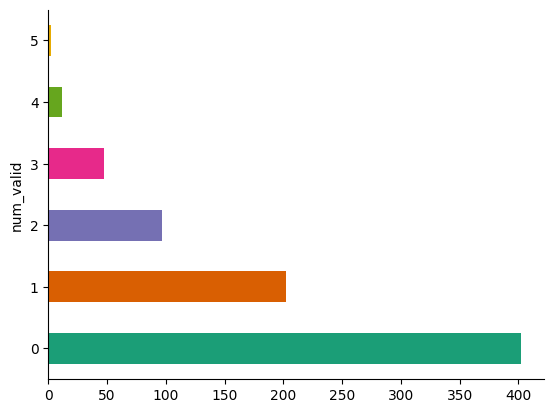

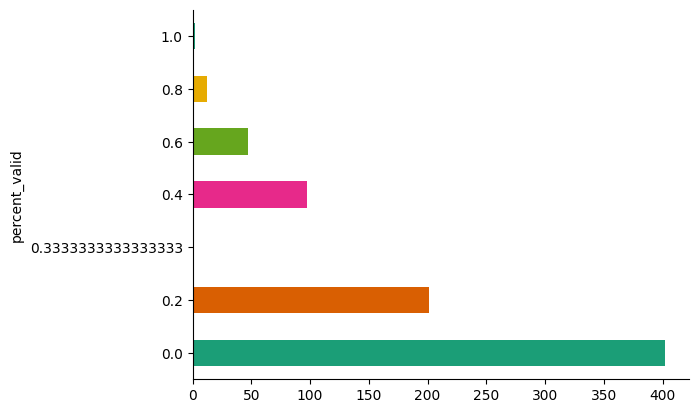

In [ ]:
print_stats(results_xlm_roberta_5)

1. Valid candidates of all the dataset: 984 (1.291 valids/context)
2. Number of contexts with valid candidates: 459 (60.199999999999996%)
3. Avg Score (% of TRUE of the candidate) of all tha dataset:  6.800000000000001% (10.8% excluding 0 valids)


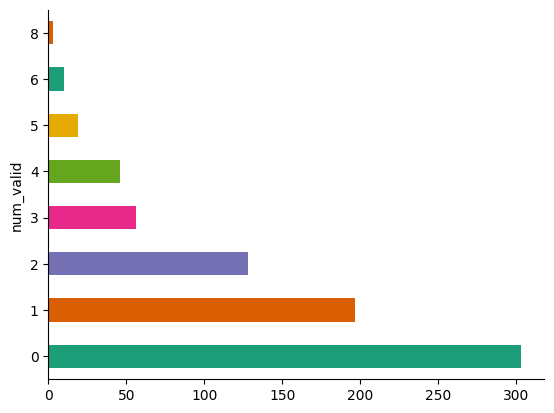

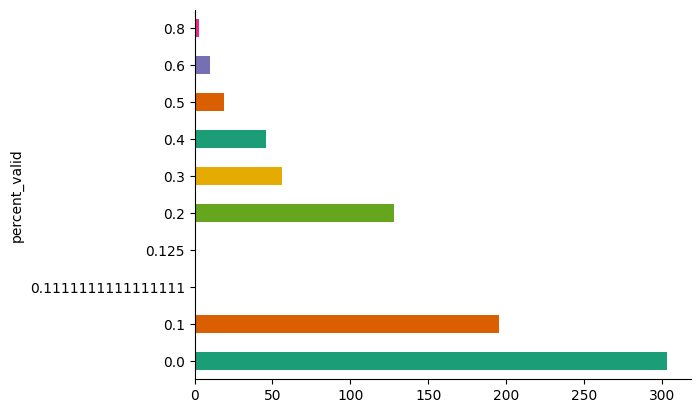

In [ ]:
print_stats(results_xlm_roberta_10)

1. Valid candidates of all the dataset: 2334 (3.063 valids/context)
2. Number of contexts with valid candidates: 614 (80.60000000000001%)
3. Avg Score (% of TRUE of the candidate) of all tha dataset:  3.0% (3.5999999999999996% excluding 0 valids)


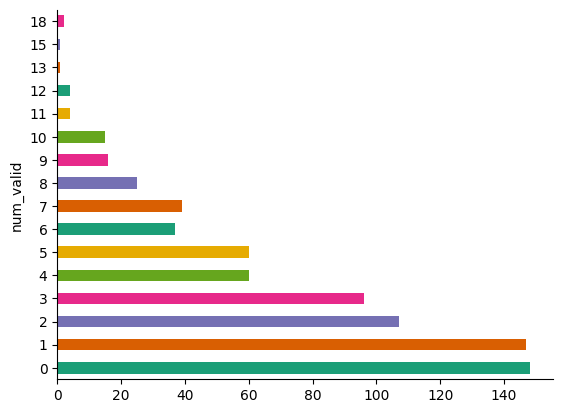

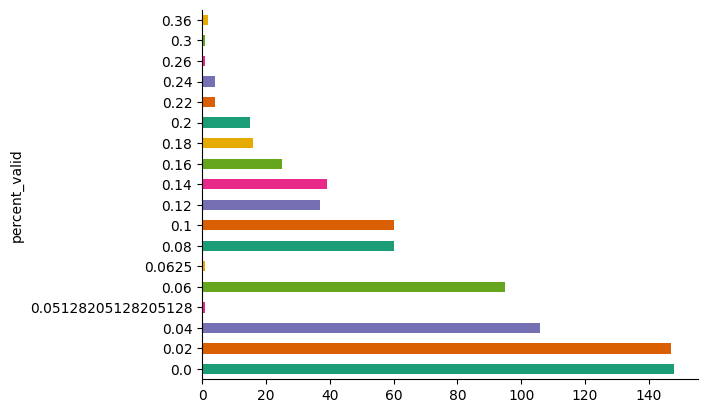

In [ ]:
print_stats(results_xlm_roberta_50)

### Examples

In [ ]:
evaluate_substitutes(swords_data, substitutes_by_target, xlm_roberta, is_transformer=True, is_fasttext=False, top_k=50, verbose=True, debugging=True)

50


Target: press
Context: "Noriega has closed every independent newspaper, radio and television station and arrested, tortured or forced into exile a long list of reporters," the statement declared.

It added: "In Cuba, public enemy No. 1 of press freedoms in the hemisphere, repression of journalists both Cuban and foreign is worse than ever."
And in Nicaragua, promises of press freedom by the Sandinistas "have not materialized."
Substitutes of 'press':
journalist (70%), newspaper (60%), communication (30%), press (0%), medium (0%), all (0%), news (0%), democratic (0%), civil (0%), political (0%), the (0%), academic (0%), cultural (0%), our (0%), basic (0%), fundamental (0%), human (0%), religious (0%), most (0%), professional (0%), information (0%), free (0%), these (0%), editorial (0%), legal (0%), economic (0%), other (0%), journal (0%), many (0%), individual (0%), international (0%), public (0%), national (0%), press (0%), liberal (0%), scientific (0%), traditional (0%), personal

,target,avg_score,num_valid,percent_valid
t:288b94f02f153614ee0dc6474368f2e15ddff00c,press,0.032,3,0.06
t:903b731500e20dcfbdab21a501e8721e28f9b15f,house,0.024,2,0.04
t:9a3b5ea9b9e5a57e305f916e4d83109321bcbaab,page,0.008,1,0.02
